# Analysis of the autism data

In [ ]:
run init.ipynb

In [ ]:
df =  pd.read_csv("/Users/samperochon/Duke/work/notes_on_stats/df_all.csv")
#df =  pd.read_csv("/home01/sam/df_all.csv")

df['study'] = df['path'].apply(lambda x: x.split('/')[-3] if x.split('/')[-3] in S2K_STUDIES else x.split('/')[-4])
data = Dataset(df=df, 
               missing_data_handling='encoding', 
               imputation_method='without', 
               sampling_method='without',
               outcome_column='diagnosis',
                features_name = CVA_COLUMNS, 
                scale_data=True,
                use_missing_indicator_variables=False,
               verbosity=4,
               scenario='papers',
               proportion_train=1)

# Features selection

Encoding 459 (train) and 0 (test) missing values with -5.
Predicting diagnosis based on 51 features using ebm approach.
Performing 16 fold cross-validation.
0 dewndjin
16-fold Cross-Validation.
Size Train: 430 (390 NT 40 ASD) Test: 29 (26 NT 3 ASD)
1 dewndjin
2 dewndjin
3 dewndjin
4 dewndjin
5 dewndjin
6 dewndjin
7 dewndjin
8 dewndjin
9 dewndjin
10 dewndjin
11 dewndjin
12 dewndjin
13 dewndjin
14 dewndjin
15 dewndjin


AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)
0   0.83   0.362        0.881             0.136                  0.923                           0.395               0.258     0.797                                   0.333                                              0.674                                                        0.81                                            0.269                             0.96                                   0.326                             0.731                             0.04

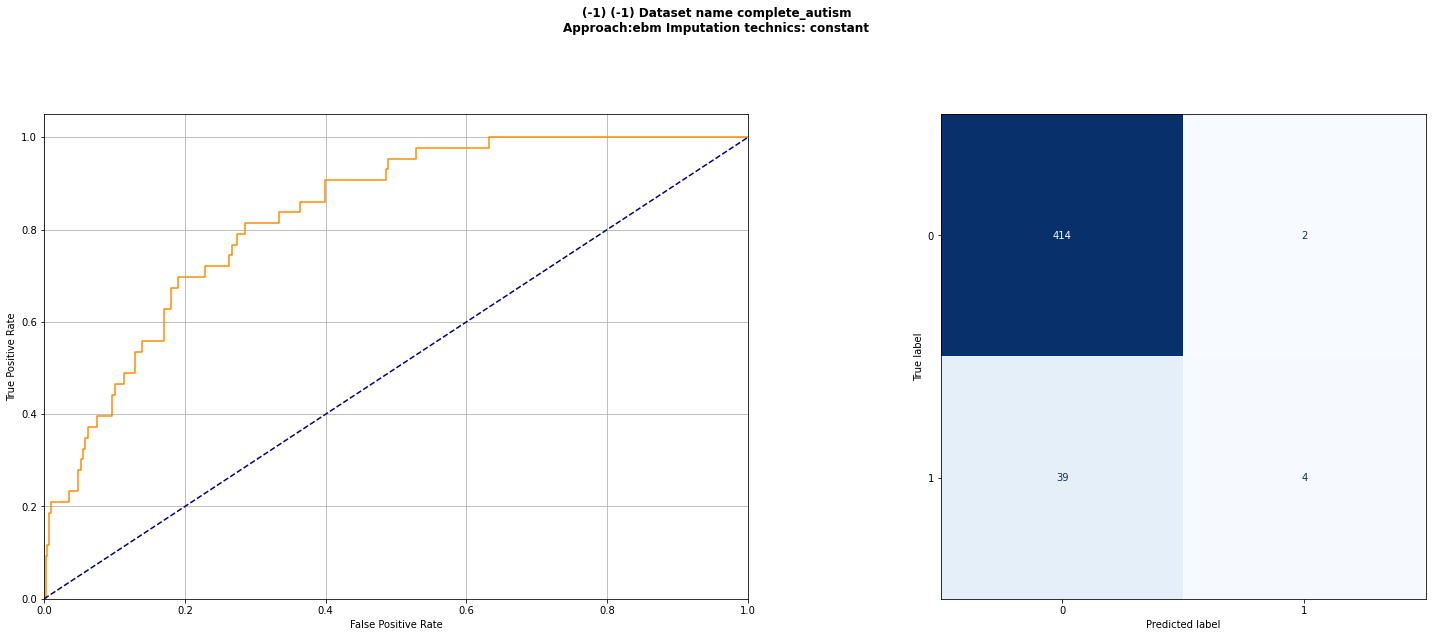

<!-- http://127.0.0.1:7926/140151923980816/ -->

In [3]:
from interpret.glassbox import ExplainableBoostingClassifier

set_of_features  = {}
features_importance = pd.DataFrame(columns=CVA_COLUMNS)

features = features_dict['ebm']['papers']

for n_features in range(15):

    exp = Experiments(data.dataset_name,
                  dataset=data, 
                    approach='ebm', 
                    previous_experiment=None,        
                    verbosity=4, 
                    debug=True, 
                    save_experiment=False)

    exp.fit_predict(num_cv=16)
    exp.plot()

if exp.approach == 'ebm':

    # Store 15 best features for each scenario
    ebm_global = exp.model.explain_global()
    ordered_features = np.array(ebm_global.feature_names)[np.argsort(ebm_global._internal_obj['overall']['scores'])]
    ordered_features = [f for f in ordered_features if ' x ' not in f]

    set_of_features = ordered_features[-15:]
    dict_feature_importance = {feature_name:score/np.max(ebm_global._internal_obj['overall']['scores']) for feature_name, score in zip(DEFAULT_PREDICTORS, ebm_global._internal_obj['overall']['scores']) }

    scenario_feature_importance = pd.DataFrame(dict_feature_importance, index=[0])
    features_importance = features_importance.append(scenario_feature_importance)

elif exp.approach == 'xgboost':

    scenario_feature_importance = pd.DataFrame(exp.model.get_booster().get_score(importance_type='weight', fmap=''), index=[scenario])
    features_importance = features_importance.append(scenario_feature_importance/scenario_feature_importance.max().max())
    set_of_features = pd.DataFrame(exp.model.get_booster().get_score(importance_type='weight', fmap=''), index=[0]).transpose()[0].sort_values(ascending=False).index[:15]

    
      
from interpret import show
ebm_local = exp.model.explain_local(exp.dataset.X_train, exp.dataset.y_train)
show(ebm_local)

# Test on different hyperparameters

In [ ]:
features_dict = {'ebm': {'young': ['BB_gaze_percent_right',
                   'FP_postural_sway_derivative',
                   'RT_postural_sway_derivative',
                   'BB_gaze_silhouette_score',
                   'RT_postural_sway',
                   'S_gaze_percent_right',
                   'BB_postural_sway',
                   'PWB_postural_sway_derivative',
                   'average_response_to_name_delay',
                   'MML_postural_sway',
                   'FP_gaze_silhouette_score',
                   'PWB_postural_sway',
                   'FP_gaze_speech_correlation',
                   'name_call_response_binary',
                   'proportion_of_name_call_responses'],
      'papers': ['S_gaze_silhouette_score',
                   'FP_postural_sway',
                   'average_delay_to_pop',
                   'BB_gaze_silhouette_score',
                   'FP_gaze_speech_correlation',
                   'PWB_postural_sway',
                   'RT_postural_sway',
                   'S_gaze_percent_right',
                   'MML_postural_sway_derivative',
                   'BB_gaze_percent_right',
                   'name_call_response_binary',
                   'MML_postural_sway',
                   'BB_postural_sway',
                   'proportion_of_name_call_responses',
                   'RT_postural_sway_derivative'],
          'all': ['DIGRRL_postural_sway_derivative',
                   'MML_postural_sway_derivative',
                   'FP_gaze_silhouette_score',
                   'PWB_postural_sway_derivative',
                   'MML_postural_sway',
                   'std_error',
                   'BB_postural_sway',
                   'number_of_touches',
                   'PWB_postural_sway',
                   'number_of_target',
                   'S_gaze_silhouette_score',
                   'BB_gaze_percent_right',
                   'S_gaze_percent_right',
                   'PB_postural_sway_derivative',
                   'PB_postural_sway']},
     'xgboost': {'young': ['FP_gaze_speech_correlation', 'proportion_of_name_call_responses', 'average_response_to_name_delay', 'MML_postural_sway', 'BB_gaze_silhouette_score', 'DIGC_postural_sway_derivative', 'S_gaze_percent_right', 'PWB_postural_sway', 'FB_postural_sway_derivative', 'BB_gaze_percent_right', 'DIGRRL_postural_sway_derivative', 'average_force_applied', 'std_delay_to_pop', 'DIGC_postural_sway', 'RT_postural_sway'],
                  'papers': ['average_response_to_name_delay', 'FB_postural_sway', 'MML_postural_sway', 'BB_gaze_silhouette_score', 'S_gaze_percent_right', 'BB_postural_sway', 'proportion_of_name_call_responses', 'RT_postural_sway', 'FB_postural_sway_derivative', 'BB_gaze_percent_right', 'FP_gaze_speech_correlation', 'DIGC_postural_sway', 'DIGC_postural_sway_derivative', 'PWB_postural_sway', 'std_error'],
                  'all': ['BB_gaze_percent_right', 'S_gaze_percent_right', 'PB_postural_sway', 'std_error', 'MML_postural_sway', 'FP_gaze_silhouette_score', 'ST_postural_sway', 'number_of_target', 'average_response_to_name_delay', 'FP_gaze_speech_correlation', 'number_of_touches', 'PWB_postural_sway', 'DIGRRL_postural_sway_derivative', 'S_gaze_silhouette_score', 'BB_postural_sway']}}

features = features_dict['ebm']['papers']

from interpret.glassbox import ExplainableBoostingClassifier

# best features are at the end pf the list
features = features_dict['ebm']['papers']

for n_features in range(15):
    
    if n_features == 0 :
        predictors = CVA_COLUMNS
    else:
        predictors = features[-n_features:]
    
    df =  pd.read_csv("/Users/samperochon/Duke/work/notes_on_stats/df_all.csv")
    #df =  pd.read_csv("/home01/sam/df_all.csv")

    df['study'] = df['path'].apply(lambda x: x.split('/')[-3] if x.split('/')[-3] in S2K_STUDIES else x.split('/')[-4])
    data = Dataset(df=df, 
                   missing_data_handling='encoding', 
                   imputation_method='without', 
                   sampling_method='without',
                   outcome_column='diagnosis',
                    features_name = predictors, 
                    scale_data=True,
                    use_missing_indicator_variables=False,
                   verbosity=4,
                   scenario='papers',
                   proportion_train=1)



    exp = Experiments(data.dataset_name,
                  dataset=data, 
                    approach='ebm', 
                    previous_experiment=None,        
                    verbosity=4, 
                    debug=True, 
                    save_experiment=False)

    exp.fit_predict(num_cv=16)
    exp.plot()

Post-processing inital df (removing columns with no cva features, encoding srings, compute administrations order, compute condensed S/NS variables)... 
Removing 1459/1956 keeping only subject in studies: ['ARC', 'P1'].
Removing 12/497 keeping first admin.
Removing 26/485 keeping only subject with diagnosis: [0, 1].
459 administrations left.


id
diagnosis     
0.0        416
1.0         43

Splitting dataset into test and train set.
Encoding 459 (train) and 0 (test) missing values with -5.
Predicting diagnosis based on 51 features
Splitting dataset into test and train set.
Encoding 459 (train) and 0 (test) missing values with -5.
Encoding 459 (train) and 0 (test) missing values with -5.
Predicting diagnosis based on 51 features using ebm approach.
Performing 16 fold cross-validation.
16-fold Cross-Validation.
Size Train: 430 (390 NT 40 ASD) Test: 29 (26 NT 3 ASD)


In [19]:
from xgboost import XGBClassifier, plot_importance, plot_tree
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show

import torch


model = ExplainableBoostingClassifier(feature_names=self.features_name, 
                                        max_bins=256,
                                        max_interaction_bins=256,
                                        binning='quantile',
                                        mains='all',
                                        interactions=40,
                                        outer_bags=8,
                                        inner_bags=0,
                                        learning_rate=0.01,
                                        validation_size=0.15,
                                        early_stopping_rounds=50,
                                        early_stopping_tolerance=0.0001,
                                        max_rounds=10000,
                                        min_samples_leaf=2,
                                        max_leaves=3,
                                        n_jobs=-2,
                                        random_state=RANDOM_STATE)

ExplainableBoostingClassifier(feature_names=['BB_gaze_percent_right',
                                             'BB_gaze_silhouette_score',
                                             'S_gaze_percent_right',
                                             'S_gaze_silhouette_score',
                                             'FP_gaze_speech_correlation',
                                             'FP_gaze_silhouette_score',
                                             'proportion_of_name_call_responses',
                                             'average_response_to_name_delay',
                                             'name_call_response_binary',
                                             'FB_postural_sway',
                                             'FB_postural_sway_derivative',
                                             'DI...
                                             'continuous', 'continuous',
                                             'continuous', 'continu

In [ ]:
 ebm_local = self.model.explain_local(self.dataset.X_train, self.dataset.y_train)
        show(ebm_global)
        show(ebm_local)

Predicting diagnosis based on 29 features
Splitting dataset into test and train set.
Encoding 459 (train) and 0 (test) missing values with -5.


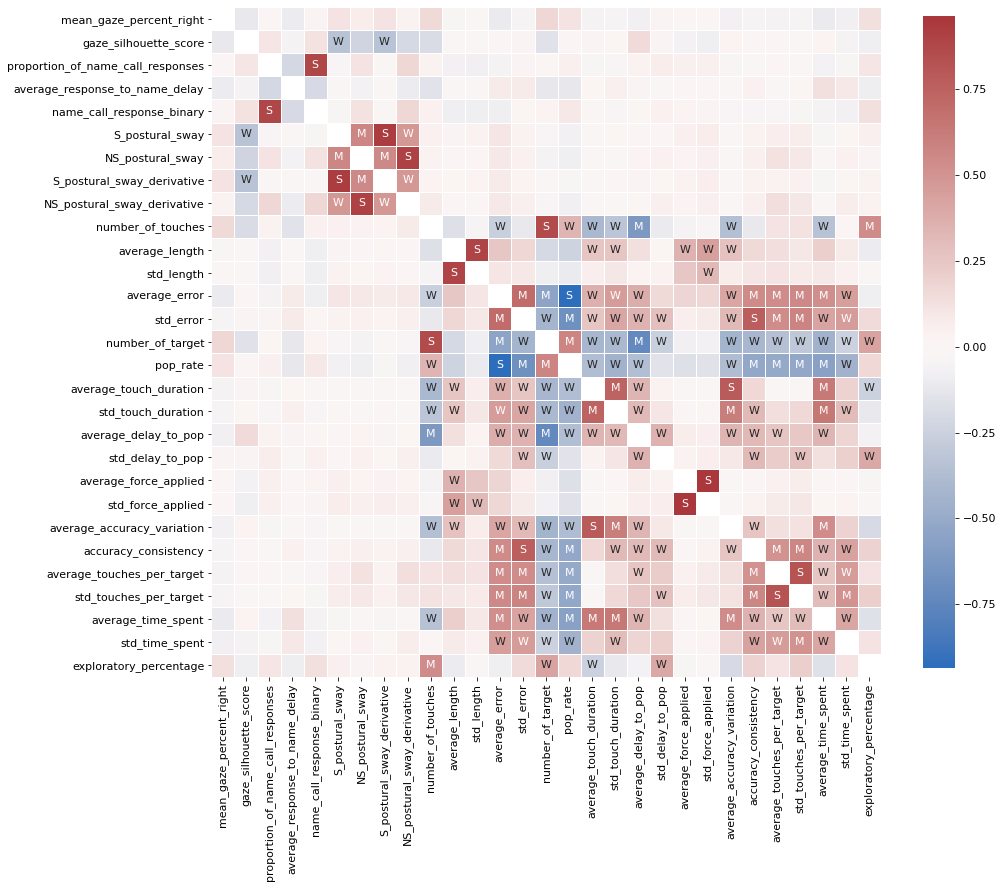

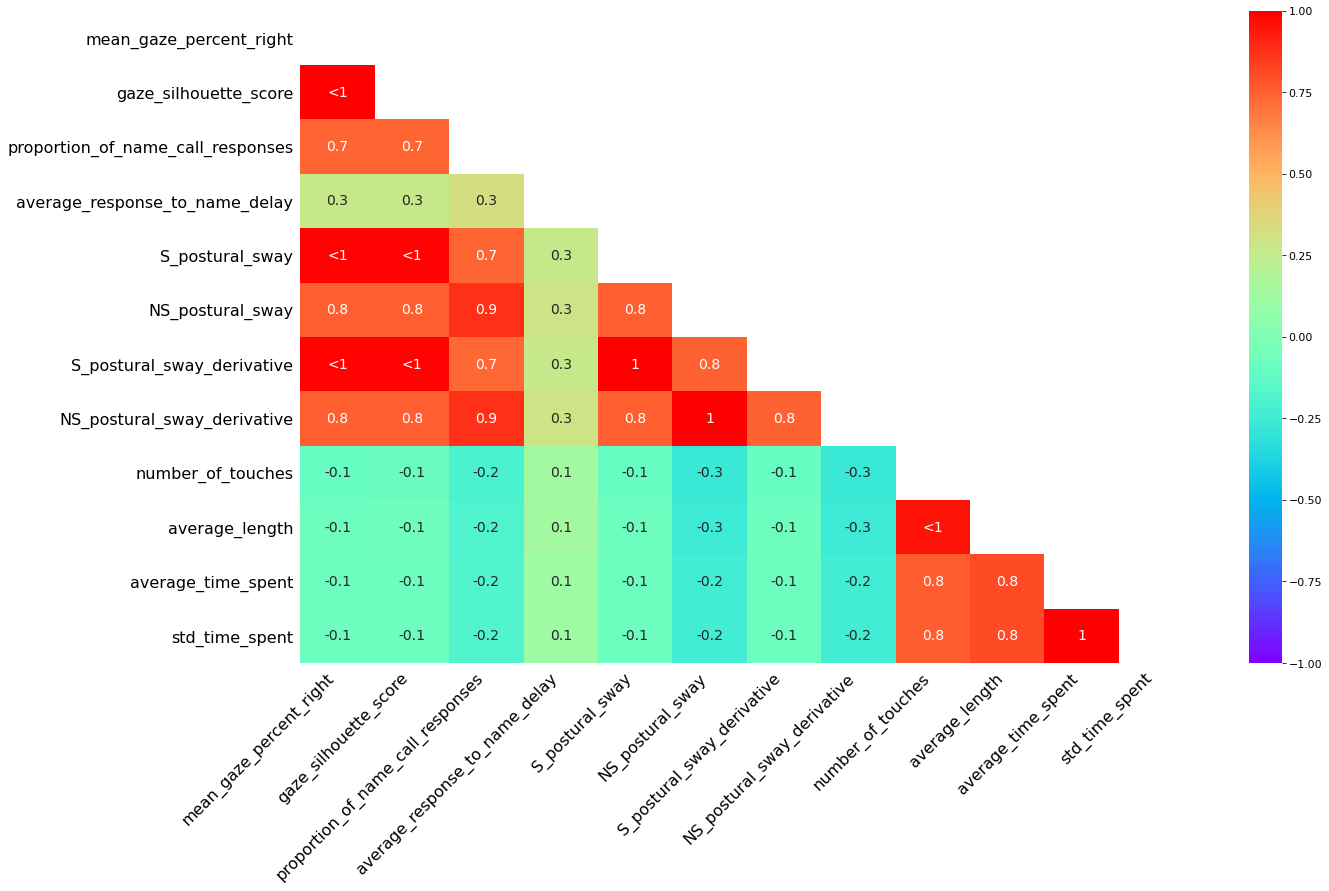

In [21]:
import missingno as msno
data.features_name = DEFAULT_PREDICTORS
df_X = df[data.features_name]
# Computes feature correlation
df_corr = df_X.corr(method="pearson")
labels = np.where(np.abs(df_corr)>0.75, "S",
                  np.where(np.abs(df_corr)>0.5, "M",
                           np.where(np.abs(df_corr)>0.25, "W", "")))

# Plot correlation matrix
plt.figure(figsize=(15, 15))
sns.heatmap(df_corr, mask=np.eye(len(df_corr)), square=True,
            center=0, annot=labels, fmt='', linewidths=.5,
            cmap="vlag", cbar_kws={"shrink": 0.8});

#plt.figure(figsize=(15, 15))
#df.isna().mean().sort_values().plot(kind="bar", figsize=(15, 4),
#                                    title="Percentage of missing values per feature");

    
features_for_missing_correlations = ['mean_gaze_percent_right',
                             'gaze_silhouette_score',
                             'proportion_of_name_call_responses',
                             'average_response_to_name_delay',
                             'S_postural_sway',
                             'NS_postural_sway',
                             'S_postural_sway_derivative',
                             'NS_postural_sway_derivative',
                             'number_of_touches',
                             'average_length',
                             'average_time_spent',
                             'std_time_spent']
df_X = df[features_for_missing_correlations]
msno.heatmap(df_X, cmap='rainbow');


Text(0, 0.5, 'Number of administration with this pattern missing.')

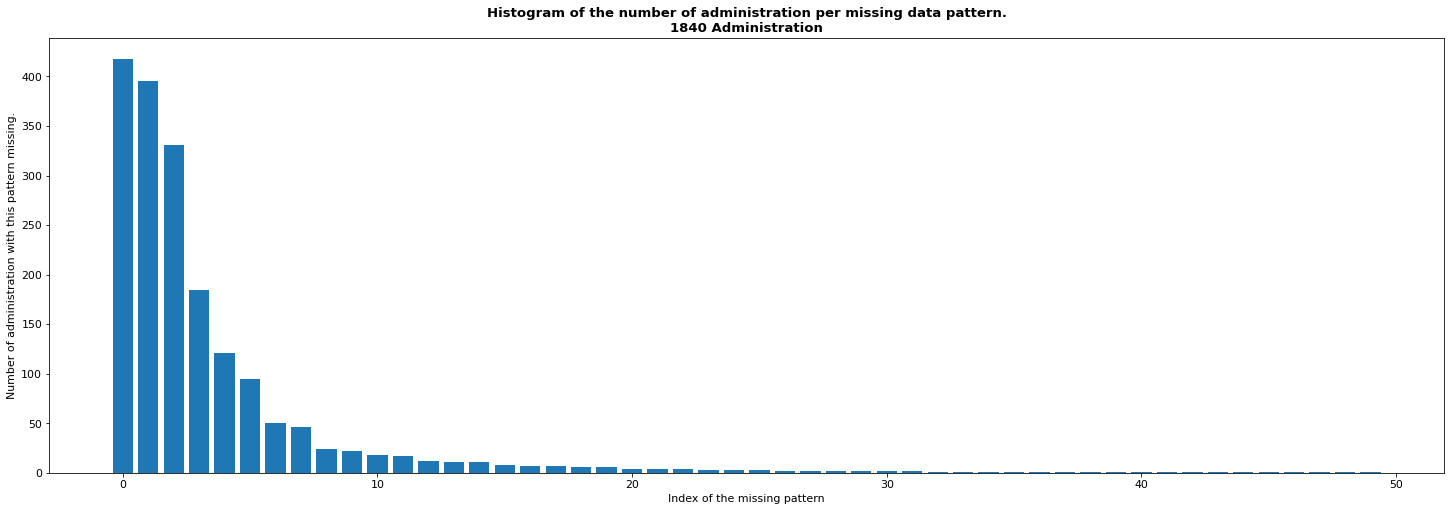

In [99]:
variables_of_interest = DEFAULT_PREDICTORS


X  = data.df[variables_of_interest]
dataset = X.copy()

vars = dataset.dtypes.index.values
n_var = dataset.shape[1]
# mean and covariance estimates
# ideally, this is done with a maximum likelihood estimator
gmean = dataset.mean()
gcov = dataset.cov()

# set up missing data patterns
r = 1 * dataset.isnull()
mdp = np.dot(r, list(map(lambda x: pow(2, x), range(n_var))))
sorted_mdp = sorted(np.unique(mdp))
n_pat = len(sorted_mdp)
correct_mdp = list(map(lambda x: sorted_mdp.index(x), mdp))
data.df["mdp"] = pd.Series(correct_mdp, index=dataset.index)

plt.figure(figsize=(25, 8))
plt.bar(x=np.arange((len(data.df["mdp"].value_counts().index))), height=data.df["mdp"].value_counts().to_numpy())
plt.title("Histogram of the number of administration per missing data pattern.\n{} Administration".format(len(data.df)), weight='bold');plt.xlabel("Index of the missing pattern"); plt.ylabel("Number of administration with this pattern missing.")

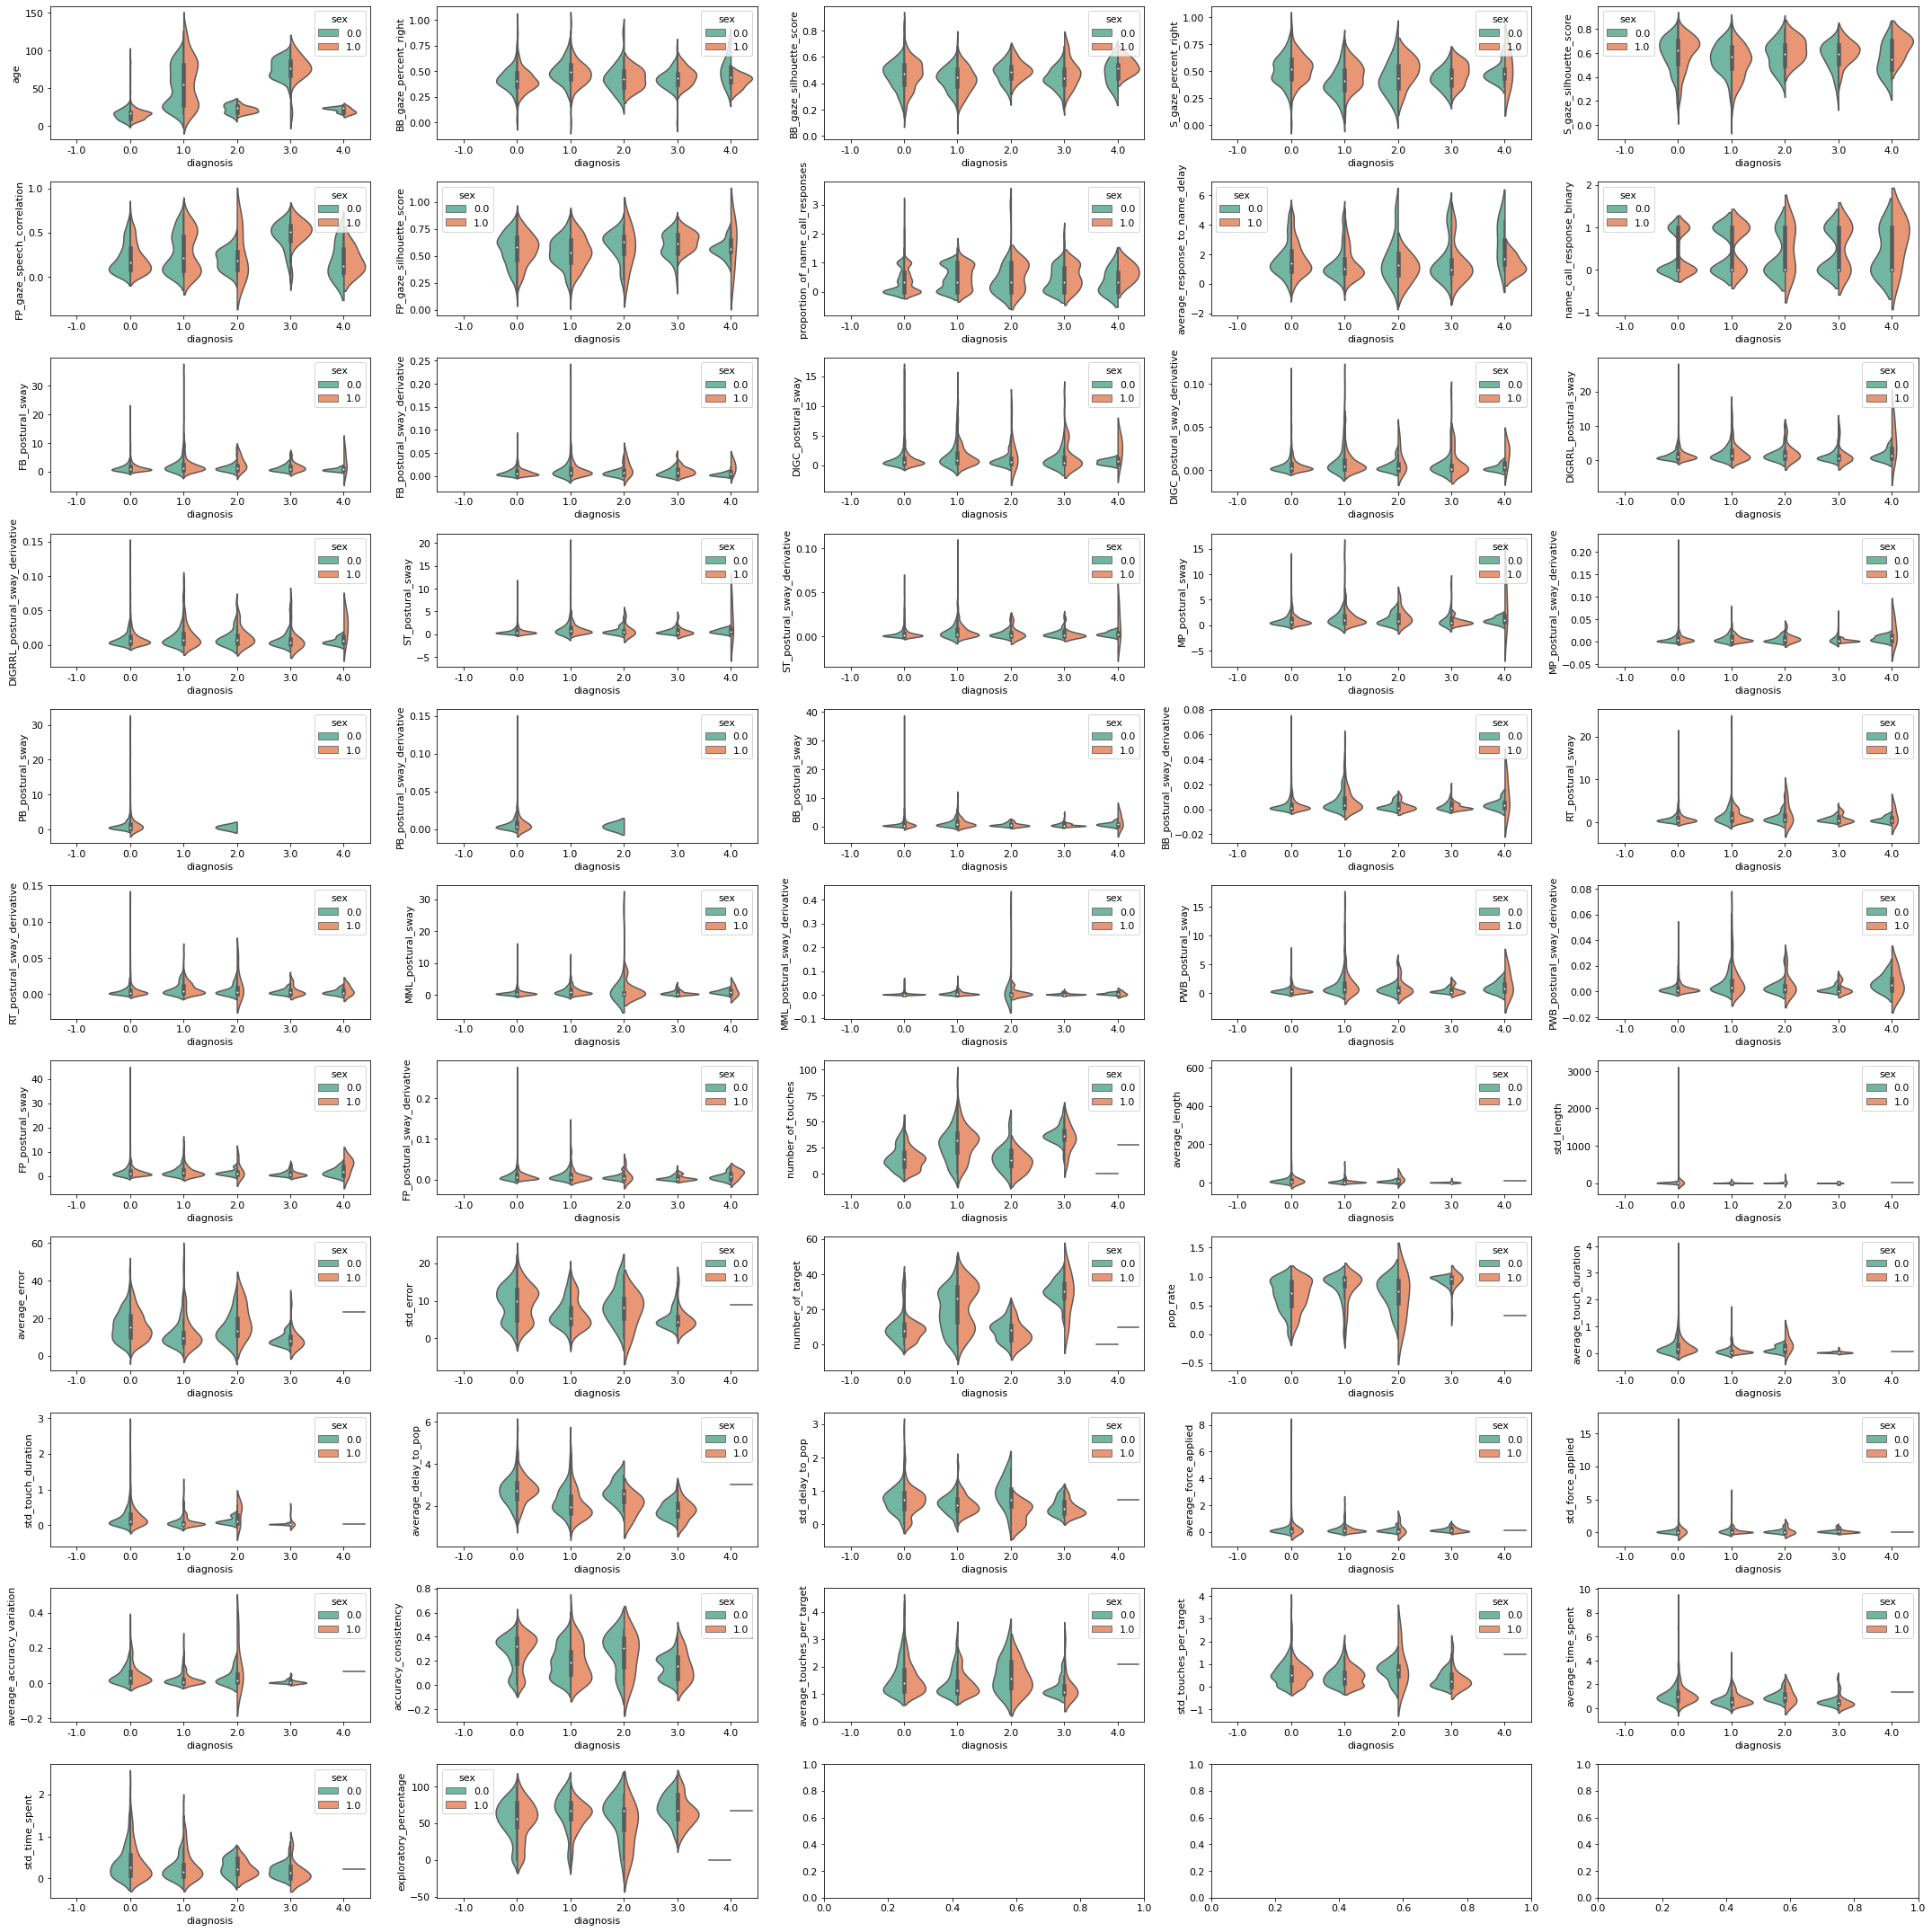

In [70]:
selected_features = ['age'] + CVA_COLUMNS

# Create a figure with 3 x 2 subplots
fig, axes = plt.subplots(ncols=5, nrows=len(selected_features)//5 +1, figsize=(30, 30))
# Loop through these features and plot entries from each feature against `Latitude`
for col, ax in zip(selected_features, axes.ravel()):
    sns.violinplot(data=df, y=col, x='diagnosis', hue='sex', palette="Set2",
                   split=True, ax=ax)
plt.tight_layout()

In [100]:
variables_of_interest = CVA_COLUMNS


X  = data.df[variables_of_interest]
dataset = X.copy()

vars = dataset.dtypes.index.values
n_var = dataset.shape[1]
# mean and covariance estimates
# ideally, this is done with a maximum likelihood estimator
gmean = dataset.mean()
gcov = dataset.cov()

# set up missing data patterns
r = 1 * dataset.isnull()
mdp = np.dot(r, list(map(lambda x: pow(2, x), range(n_var))))
sorted_mdp = sorted(np.unique(mdp))
n_pat = len(sorted_mdp)
correct_mdp = list(map(lambda x: sorted_mdp.index(x), mdp))
data.df["mdp"] = pd.Series(correct_mdp, index=dataset.index)

In [101]:
print("Number of missing patterns: {} (over {} theoretically possible; 2^K)".format(n_pat, 2**len(variables_of_interest)))

Number of missing patterns: 210 (over 2251799813685248 theoretically possible; 2^K)


Text(0.5, 1.0, 'Features missing for the most frequent patterns. 1840 adm (1154 NT, 412 ASD)')

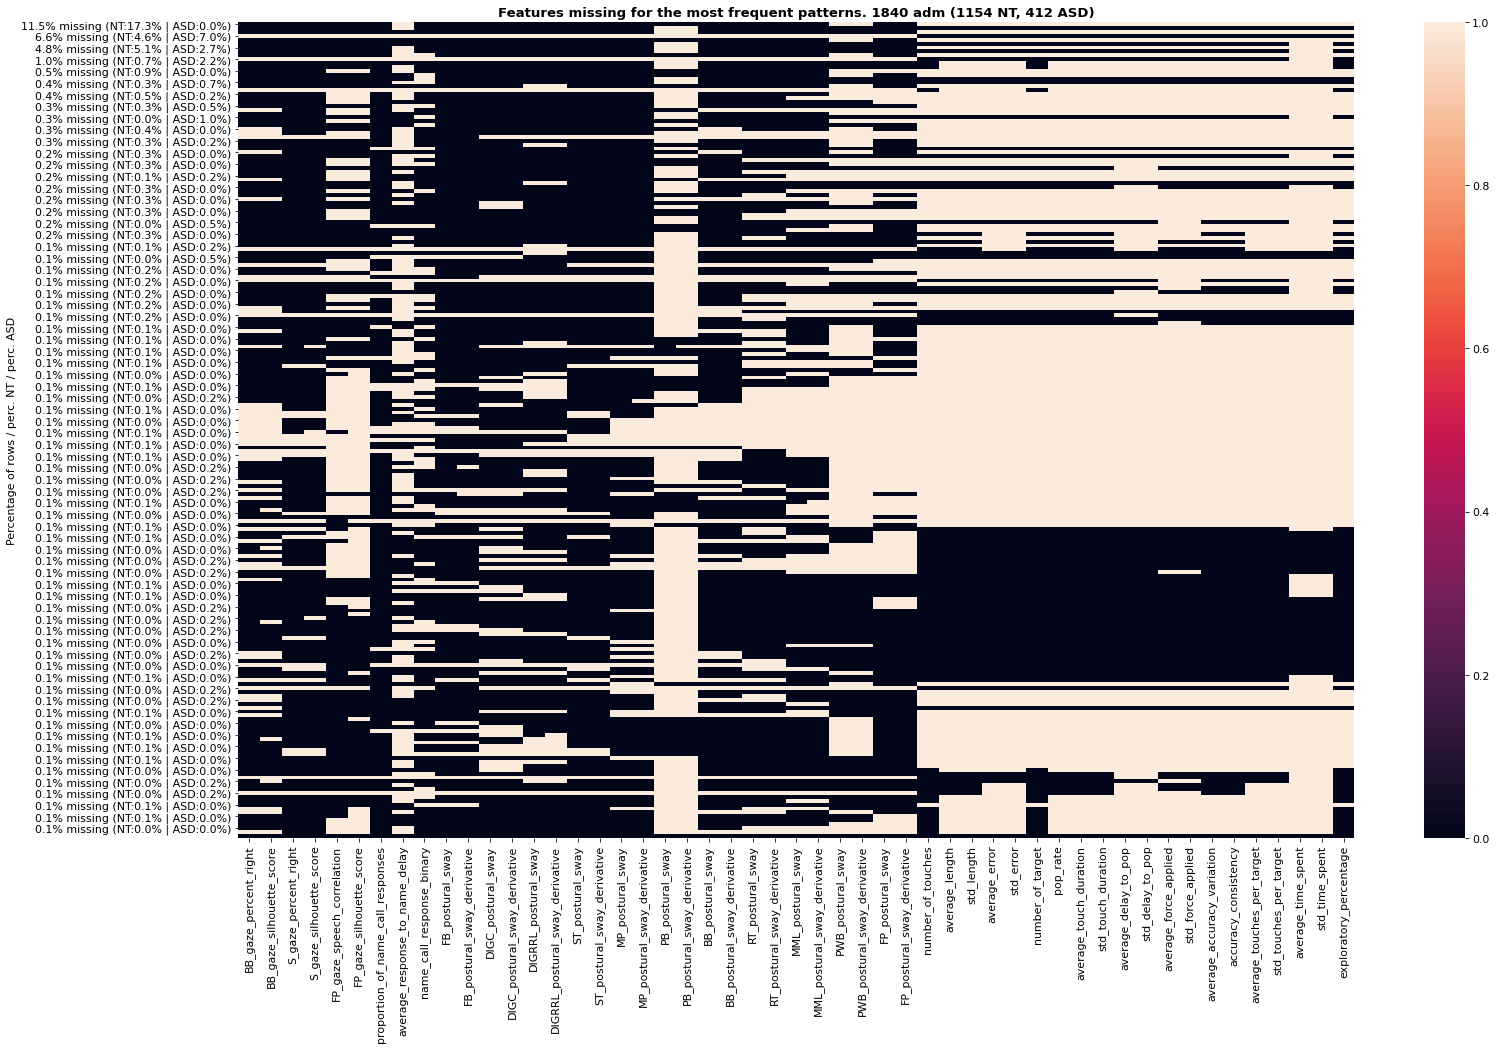

In [102]:

matrix = pd.DataFrame(
            data=np.zeros(shape=(len(data.df["mdp"].value_counts().index), len(variables_of_interest)+1)),
            columns=variables_of_interest+['Percentage of rows'],
            index=data.df["mdp"].unique(),
        ).sort_index()

for pattern in sorted(data.df["mdp"].unique())[1:]:
    d = data.df.loc[data.df['mdp']==pattern, ['diagnosis'] + variables_of_interest]
    missing_columns = list(d.columns[d.isnull().any()])
    matrix.loc[pattern, missing_columns] = 1
    matrix.loc[pattern, 'Percentage of rows'] = np.round(len(d)/len(data.df)*100,2)
    #matrix.loc[pattern, 'Percentage of rows (autism)'] = np.round(len(d[d['diagnosis']==0])/len(data.df[data.df['diagnosis']==0])*100,2)
    #matrix.loc[pattern, 'Percentage of rows (NT)'] = np.round(len(d[d['diagnosis']==1])/len(data.df[data.df['diagnosis']==1])*100,2)
    matrix.loc[pattern, 'Percentage of rows / perc. NT / perc. ASD'] = "{}% missing (NT:{}% | ASD:{}%)".format(np.round(len(d)/len(data.df)*100,1), np.round(len(d[d['diagnosis']==0])/len(data.df[data.df['diagnosis']==0])*100,1), np.round(len(d[d['diagnosis']==1])/len(data.df[data.df['diagnosis']==1])*100,1))
matrix.sort_values('Percentage of rows', ascending=False, inplace=True)
plt.figure(figsize=(25, 15))
sns.heatmap(matrix.set_index('Percentage of rows / perc. NT / perc. ASD').loc[:, variables_of_interest].astype(int))
plt.title("Features missing for the most frequent patterns. {} adm ({} NT, {} ASD)".format(len(data.df), len(data.df[data.df['diagnosis']==0]), len(data.df[data.df['diagnosis']==1])), weight='bold')

<AxesSubplot:ylabel='Percentage of rows / perc. NT / perc. ASD'>

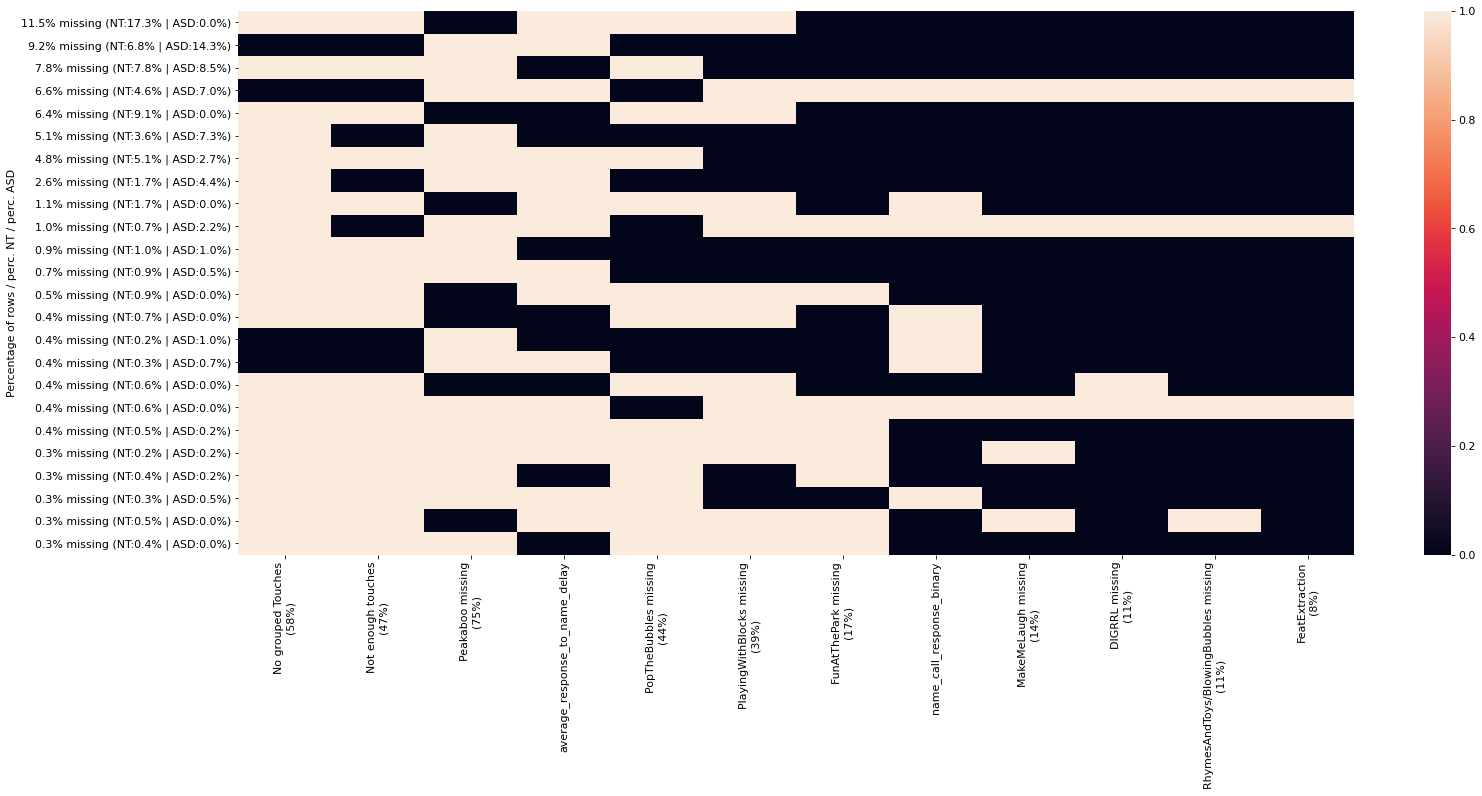

In [103]:
matrix = matrix.loc[matrix['Percentage of rows'] >.3, :].transpose()

new_df = matrix.loc[['Percentage of rows / perc. NT / perc. ASD'], :].copy()
duplicated_rows = matrix[matrix.duplicated(keep=False)]

grouped_features_label = {0:"FeatExtraction", 
                          1: "RhymesAndToys/BlowingBubbles missing", 
                          2: "MakeMeLaugh missing", 
                          3: "DIGRRL missing", 
                          4: "FunAtThePark missing", 
                          5: "Peakaboo missing", 
                          6: "PlayingWithBlocks missing", 
                          7: "PopTheBubbles missing", 
                          8: "Not enough touches", 
                          9: "No grouped Touches", 
                         }
def df_missing_features(df, features, having_features_missing=True):
    if having_features_missing:
        return df.loc[df.drop(index=df.dropna(subset=features, how='all').index).index, :]
    else:
        return df.dropna(subset=features, how='all')
    
    
grouped_features = {}
for idx, (i, f) in enumerate(duplicated_rows.groupby(list(duplicated_rows))):
    grouped_features[idx]=[]
    for col in f.index:
        grouped_features[idx].append(col)    
    
for i, feats in grouped_features.items():
    grouped_features_label[i] += "\n({}%)".format(int(len(df_missing_features(data.df, features=feats, having_features_missing=True))/len(data.df)*100))
    
    
for idx, (i, f) in enumerate(duplicated_rows.groupby(list(duplicated_rows))):
    index = ""
    for col in f.index:
        index+=col+"\n"
    index = index[:-1]
    new_df = new_df.append(pd.DataFrame(data=f.iloc[:1].to_numpy().astype(int), index=[grouped_features_label[idx]], columns=f.columns))
    

    
    
new_df = new_df.append(matrix[~matrix.duplicated(keep=False)].drop(index=['Percentage of rows','Percentage of rows / perc. NT / perc. ASD'])).transpose()
new_df.set_index('Percentage of rows / perc. NT / perc. ASD', inplace=True)
new_df = new_df.loc[:,list(new_df.sum(axis=0).sort_values(ascending=False).index)]

plt.figure(figsize=(25, 10))
sns.heatmap(new_df.astype(int))

# Feature selection

In [ ]:
features = CVA_COLUMNS



Encoding 459 (train) and 0 (test) missing values with -5.
16-fold Cross-Validation.
Size Train: 430 (390 NT 40 ASD) Test: 29 (26 NT 3 ASD)
Train shape: (430, 29)
16-fold Cross-Validation.
Size Train: 430 (390 NT 40 ASD) Test: 29 (26 NT 3 ASD)
Train shape: (430, 29)
16-fold Cross-Validation.
Size Train: 430 (390 NT 40 ASD) Test: 29 (26 NT 3 ASD)
Train shape: (430, 29)
16-fold Cross-Validation.
Size Train: 430 (390 NT 40 ASD) Test: 29 (26 NT 3 ASD)
Train shape: (430, 29)
16-fold Cross-Validation.
Size Train: 430 (390 NT 40 ASD) Test: 29 (26 NT 3 ASD)
Train shape: (430, 29)
16-fold Cross-Validation.
Size Train: 430 (390 NT 40 ASD) Test: 29 (26 NT 3 ASD)
Train shape: (430, 29)
16-fold Cross-Validation.
Size Train: 430 (390 NT 40 ASD) Test: 29 (26 NT 3 ASD)
Train shape: (430, 29)
16-fold Cross-Validation.
Size Train: 430 (390 NT 40 ASD) Test: 29 (26 NT 3 ASD)
Train shape: (430, 29)
16-fold Cross-Validation.
Size Train: 430 (390 NT 40 ASD) Test: 29 (26 NT 3 ASD)
Train shape: (430, 29)
16-fol

AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)
0  0.842   0.374        0.874             0.146                  0.921                           0.431               0.219     0.871                                    0.35                                              0.488                                                       0.911                                            0.362                            0.945                                   0.512                             0.638                            0.055

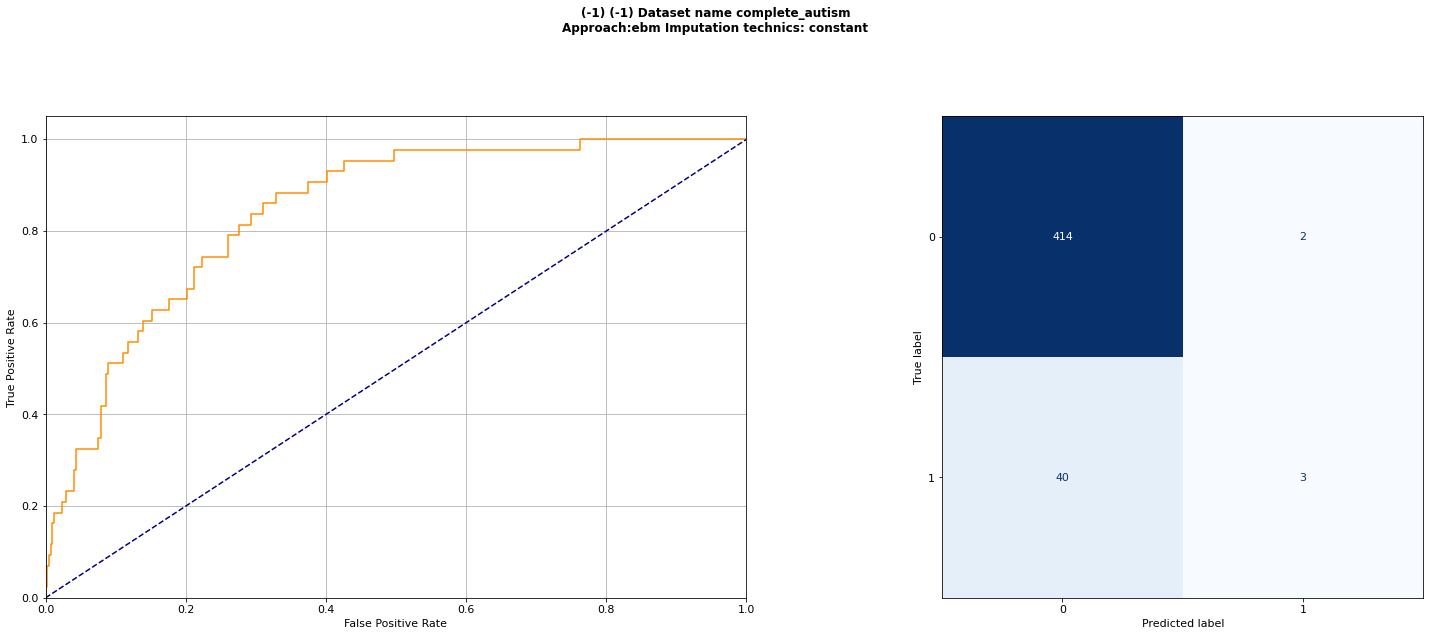

<!-- http://127.0.0.1:7739/140455133707536/ -->

In [20]:
exp = Experiments(data.dataset_name,
                  dataset=data, 
                    approach='ebm', 
                    previous_experiment=None,        
                    verbosity=1, 
                    debug=True, 
                    save_experiment=False)
    
exp.fit_predict(num_cv=16)
exp.plot()

## Preliminary. Feature selection based on importance map using NAM, EBM and XGBOOST

AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)
0  0.999   0.998        0.999             0.982                    1.0                           0.982               0.982     0.984                                   0.965                                              0.954                                                         1.0                                              1.0                            0.975                                   0.046                               0.0                            0.025

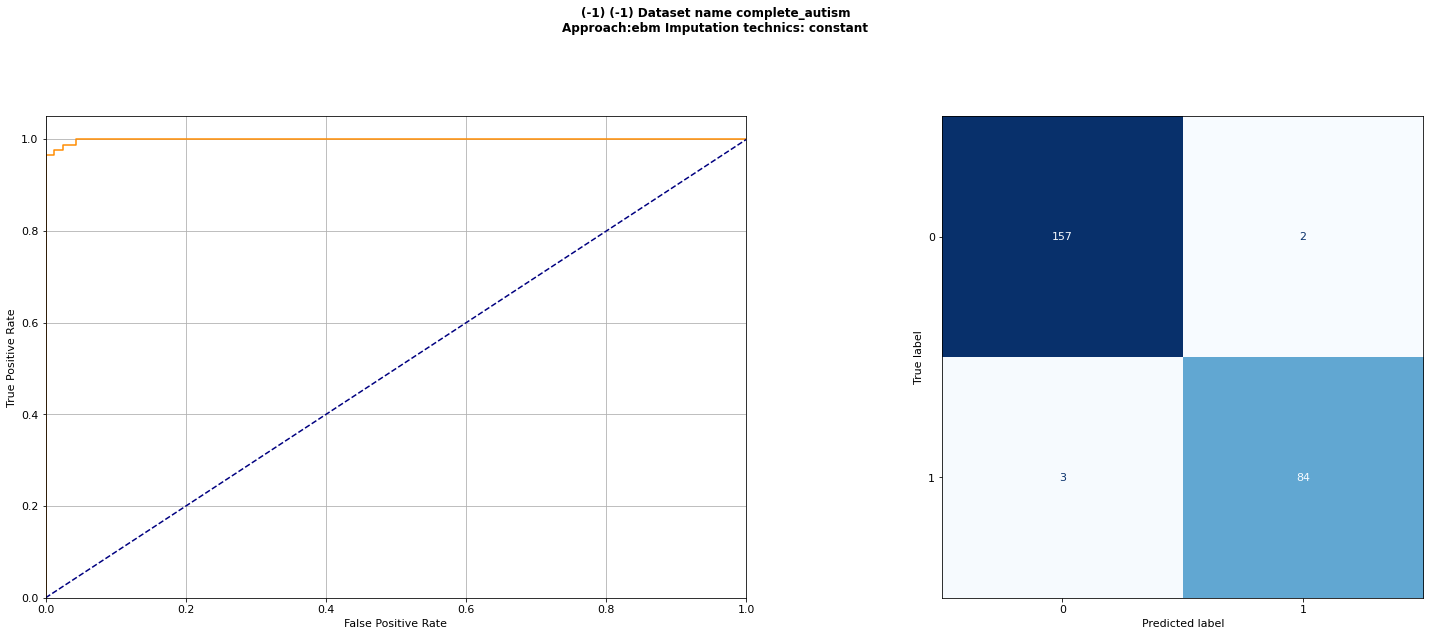

<!-- http://127.0.0.1:7491/140318642959504/ -->

<!-- http://127.0.0.1:7491/140318656471120/ -->

AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)
0    1.0     1.0          1.0               1.0                    1.0                             1.0                 1.0     0.996                                   0.986                                              0.977                                                         1.0                                              1.0                            0.995                                   0.023                               0.0                            0.005

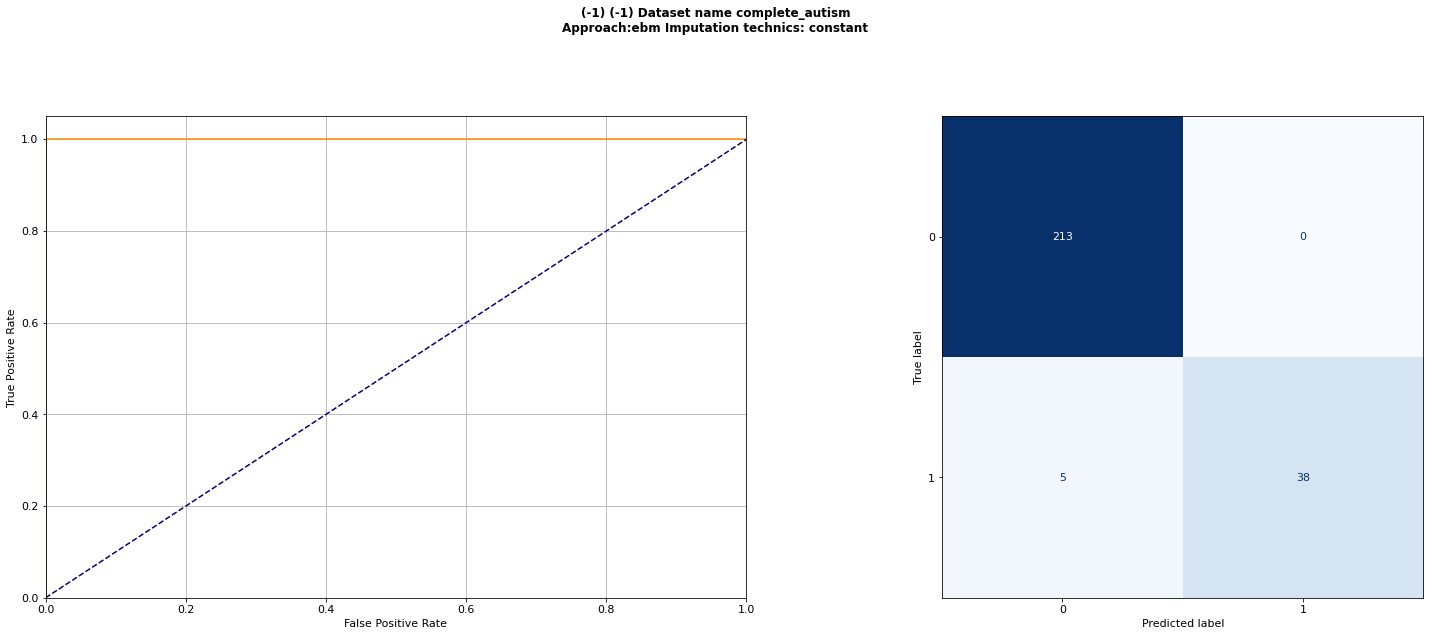

<!-- http://127.0.0.1:7491/140319506414416/ -->

<!-- http://127.0.0.1:7491/140318639365200/ -->

AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)
0  0.959   0.926         0.98             0.727                  0.999                           0.853               0.686     0.921                                   0.797                                              0.857                                                       0.944                                            0.845                            0.948                                   0.143                             0.155                            0.052

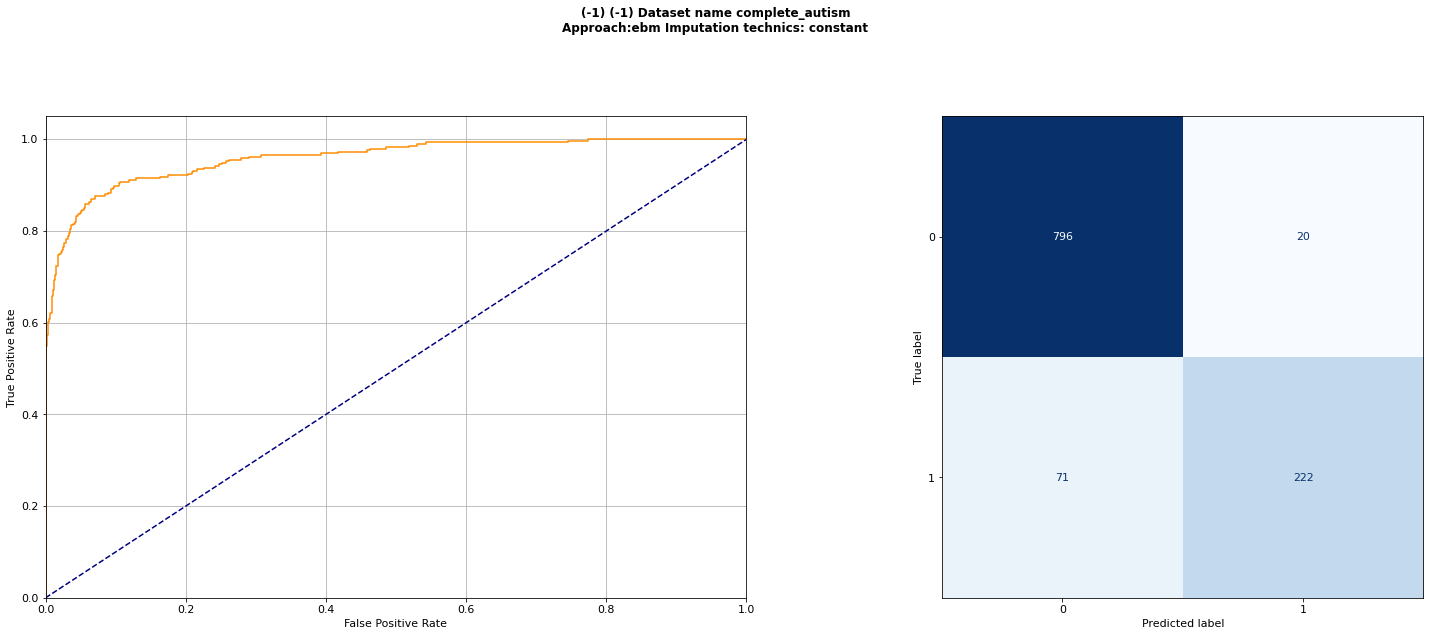

<!-- http://127.0.0.1:7491/140318656063888/ -->

<!-- http://127.0.0.1:7491/140319506414992/ -->

AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)
0  0.995   0.994        0.995             0.899                    1.0                           0.974               0.879      0.97                                   0.941                                              0.991                                                       0.952                                            0.948                            0.992                                   0.009                             0.052                            0.008

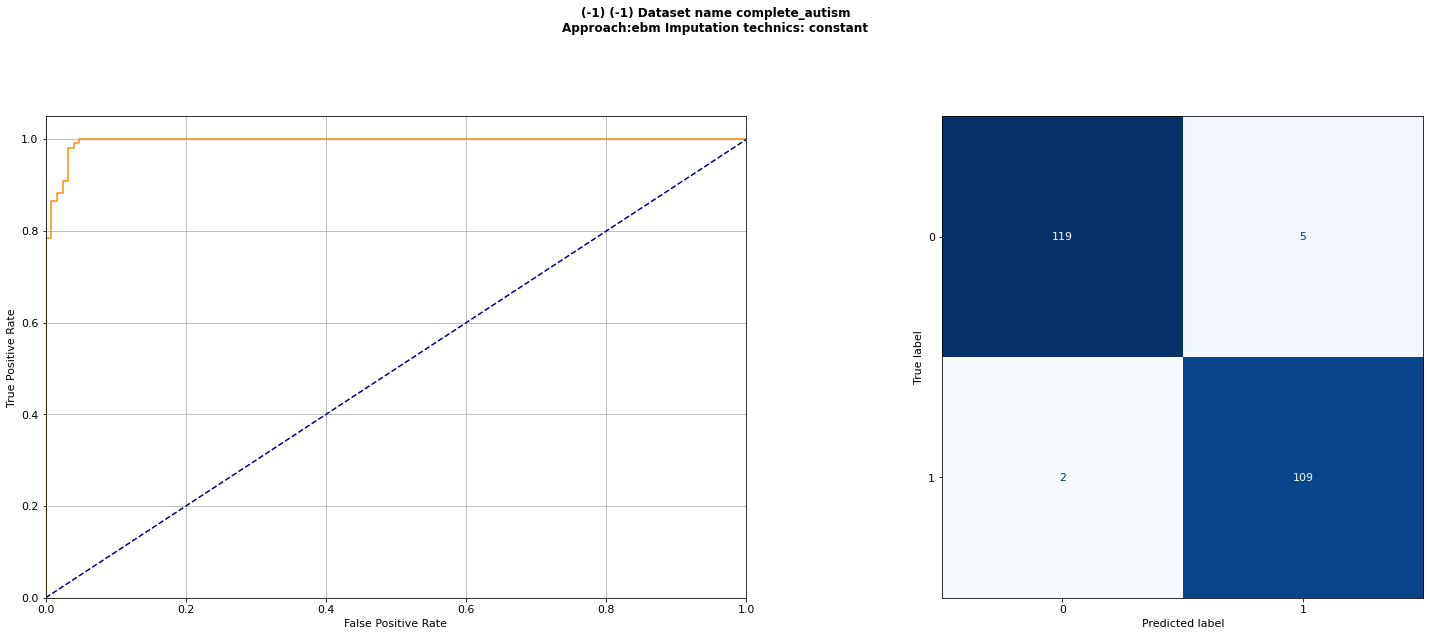

<!-- http://127.0.0.1:7491/140317883182800/ -->

<!-- http://127.0.0.1:7491/140318632016272/ -->

AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)
0  0.997   0.993        0.999             0.939                    1.0                           0.964               0.927     0.976                                   0.942                                              0.988                                                       0.971                                             0.93                            0.995                                   0.012                              0.07                            0.005

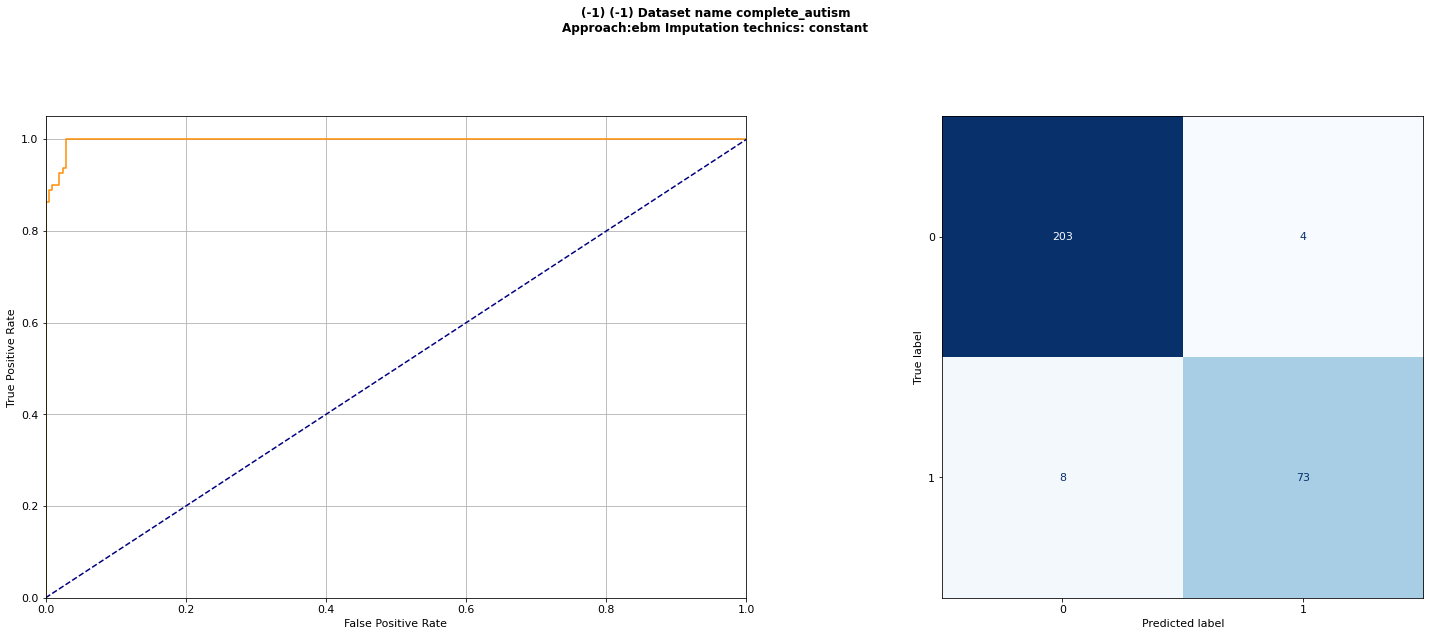

<!-- http://127.0.0.1:7491/140318632017168/ -->

<!-- http://127.0.0.1:7491/140317891185232/ -->

In [305]:
from interpret.glassbox import ExplainableBoostingClassifier

set_of_features  = {}
features_importance = pd.DataFrame(columns=DEFAULT_PREDICTORS)

for scenario in ['young', 'papers', 'all', 'asd_td_age_matched_n_balanced', 'asd_td_age_matched_n_unbalanced']:
    
    df =  pd.read_csv("/Users/samperochon/Duke/work/notes_on_stats/df_all.csv")
    data = Dataset(df=df, 
                   missing_data_handling='encoding', 
                   imputation_method='without', 
                   sampling_method='without',
                   outcome_column='diagnosis',
                    features_name = DEFAULT_PREDICTORS, 
                    scale_data=False,
                    use_missing_indicator_variables=False,
                   verbosity=0,
                   scenario=scenario,
                   proportion_train=1)
    
    exp = Experiments(data.dataset_name,
                  dataset=data, 
                    approach='ebm', 
                    previous_experiment=None,        
                    verbosity=1, 
                    debug=True, 
                    save_experiment=False)
    
    exp.fit_predict()
    exp.plot()
    
    
    # Store 15 best features for each scenario
    ebm_global = exp.model.explain_global()
    ordered_features = np.array(ebm_global.feature_names)[np.argsort(ebm_global._internal_obj['overall']['scores'])]
    ordered_features = [f for f in ordered_features if ' x ' not in f]
    
    set_of_features[scenario] = ordered_features[-15:]

    

    dict_feature_importance = {feature_name:score/np.max(ebm_global._internal_obj['overall']['scores']) for feature_name, score in zip(DEFAULT_PREDICTORS, ebm_global._internal_obj['overall']['scores']) }
        
    scenario_feature_importance = pd.DataFrame(dict_feature_importance, index=[scenario])
    features_importance = features_importance.append(scenario_feature_importance)

    
    ebm_local = exp.model.explain_local(data.X_train, data.y_train)
    show(ebm_local)


    

# Analysis of missing data patterns 

In [280]:
df = pd.read_csv("/Users/samperochon/Duke/work/notes_on_stats/df_all.csv")

df['stimuli_version'] = df['path'].apply(lambda path: path.split('/')[-2])
df.loc[~df['stimuli_version'].isin(['Older_Than_18', '12_Months', '9_Months', '6_Months']), 'stimuli_version'] = 'Older_Than_18'



data = Dataset(df=df, 
                   use_missing_indicator_variables=False,
                   missing_data_handling='encoding', 
                   imputation_method='without', 
                   sampling_method='without',
                   outcome_column='diagnosis',
                   features_name=CVA_COLUMNS,#+ CLINICAL_COLUMNS + VALIDITY_COLUMNS,
                   scenario=None,#'asd_td_age_matched_n_balanced',
                   proportion_train=1)
data.filter(administration={'complete': True})

Post-processing inital df (removing columns with no cva features, encoding srings, compute administrations order, compute condensed S/NS variables)... 
Predicting diagnosis based on 51 features
Splitting dataset into test and train set.
Encoding 1956 (train) and 0 (test) missing values with -5.
Removing 116/1956 incomplete administrations.
1840 administrations left.


id
diagnosis      
-1.0        141
 0.0       1154
 1.0        412
 2.0         40
 3.0         82
 4.0         11

Splitting dataset into test and train set.
Encoding 1840 (train) and 0 (test) missing values with -5.


Predicting diagnosis based on 29 features
Splitting dataset into test and train set.
Encoding 1840 (train) and 0 (test) missing values with -5.


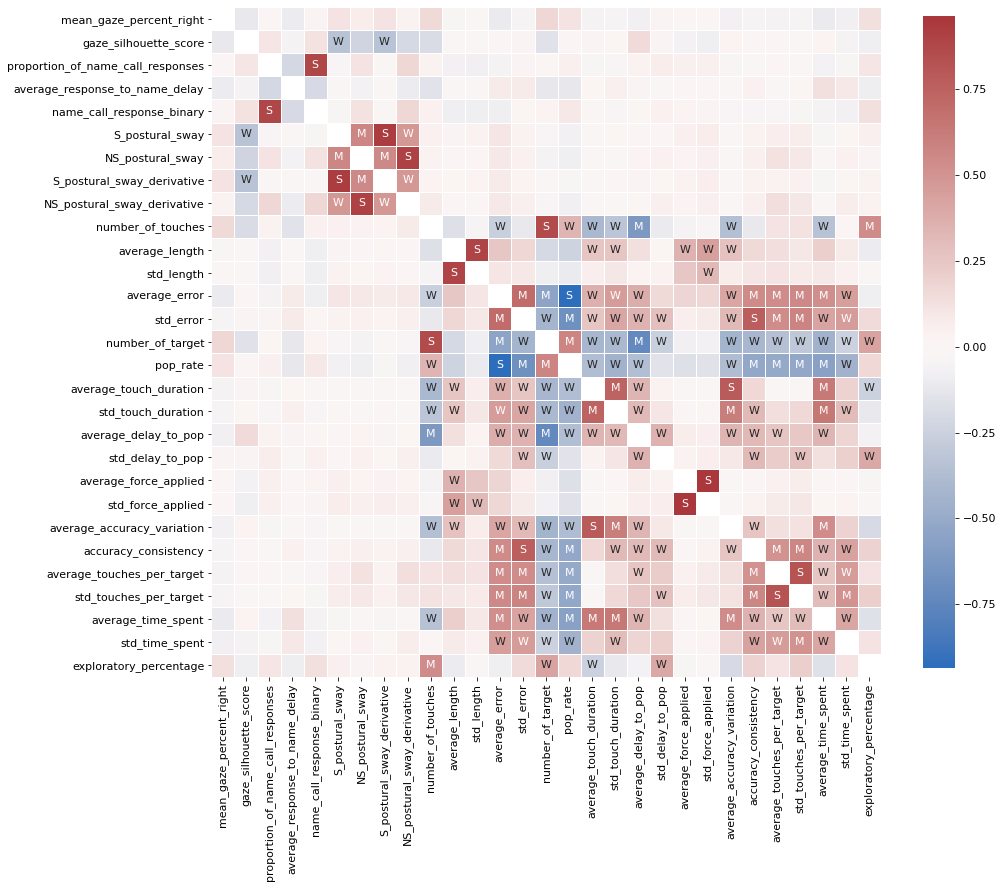

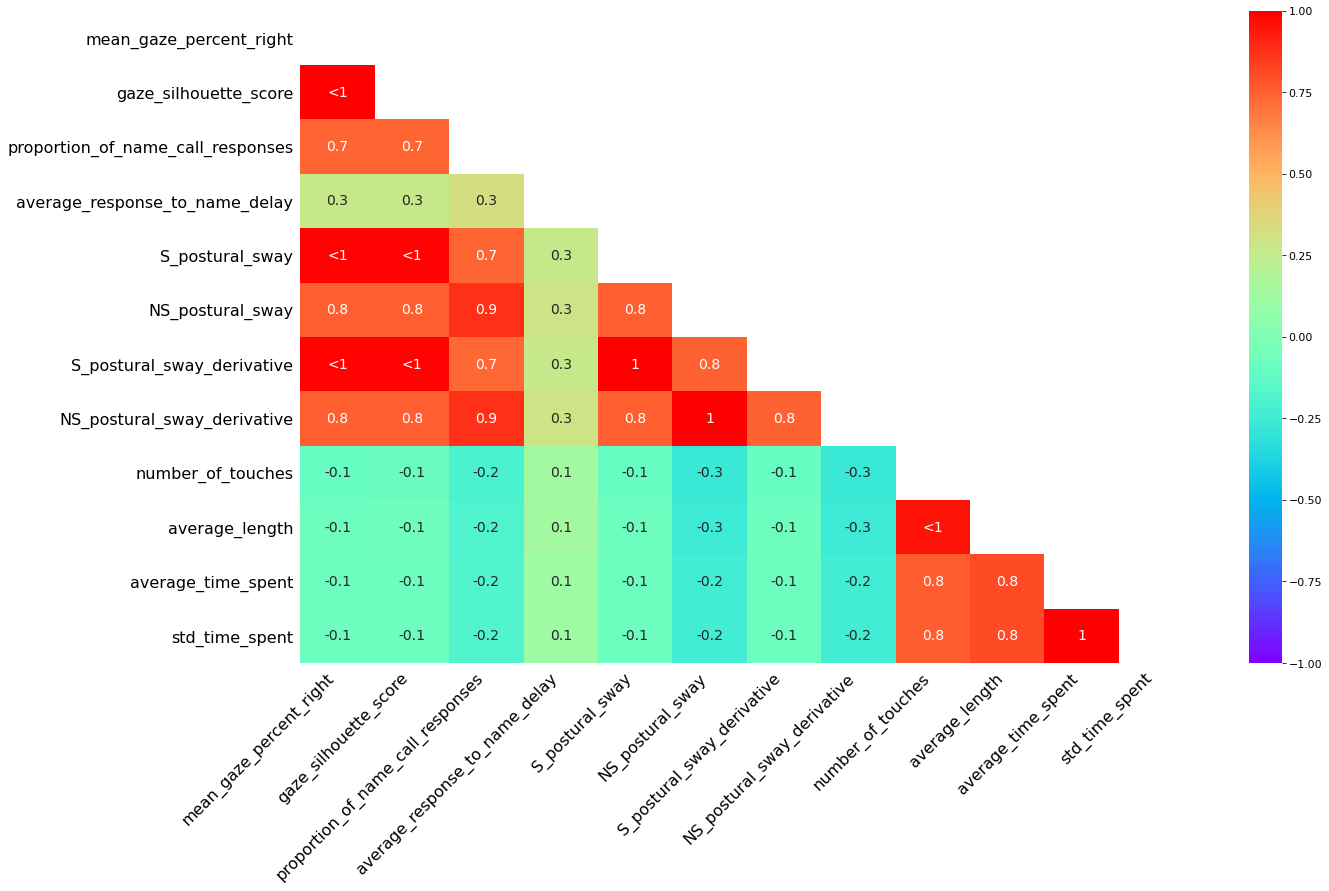

In [97]:
import missingno as msno
data.features_name = DEFAULT_PREDICTORS
df_X = df[data.features_name]
# Computes feature correlation
df_corr = df_X.corr(method="pearson")
labels = np.where(np.abs(df_corr)>0.75, "S",
                  np.where(np.abs(df_corr)>0.5, "M",
                           np.where(np.abs(df_corr)>0.25, "W", "")))

# Plot correlation matrix
plt.figure(figsize=(15, 15))
sns.heatmap(df_corr, mask=np.eye(len(df_corr)), square=True,
            center=0, annot=labels, fmt='', linewidths=.5,
            cmap="vlag", cbar_kws={"shrink": 0.8});

#plt.figure(figsize=(15, 15))
#df.isna().mean().sort_values().plot(kind="bar", figsize=(15, 4),
#                                    title="Percentage of missing values per feature");

    
features_for_missing_correlations = ['mean_gaze_percent_right',
                             'gaze_silhouette_score',
                             'proportion_of_name_call_responses',
                             'average_response_to_name_delay',
                             'S_postural_sway',
                             'NS_postural_sway',
                             'S_postural_sway_derivative',
                             'NS_postural_sway_derivative',
                             'number_of_touches',
                             'average_length',
                             'average_time_spent',
                             'std_time_spent']
df_X = df[features_for_missing_correlations]
msno.heatmap(df_X, cmap='rainbow');


Text(0, 0.5, 'Number of administration with this pattern missing.')

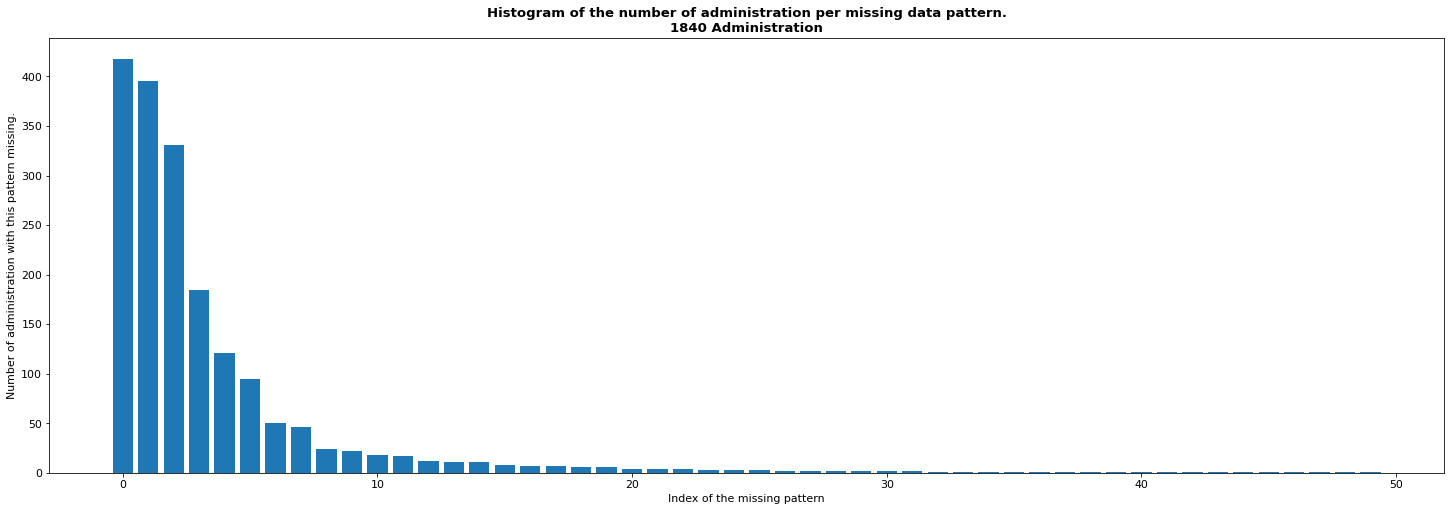

In [99]:
variables_of_interest = DEFAULT_PREDICTORS


X  = data.df[variables_of_interest]
dataset = X.copy()

vars = dataset.dtypes.index.values
n_var = dataset.shape[1]
# mean and covariance estimates
# ideally, this is done with a maximum likelihood estimator
gmean = dataset.mean()
gcov = dataset.cov()

# set up missing data patterns
r = 1 * dataset.isnull()
mdp = np.dot(r, list(map(lambda x: pow(2, x), range(n_var))))
sorted_mdp = sorted(np.unique(mdp))
n_pat = len(sorted_mdp)
correct_mdp = list(map(lambda x: sorted_mdp.index(x), mdp))
data.df["mdp"] = pd.Series(correct_mdp, index=dataset.index)

plt.figure(figsize=(25, 8))
plt.bar(x=np.arange((len(data.df["mdp"].value_counts().index))), height=data.df["mdp"].value_counts().to_numpy())
plt.title("Histogram of the number of administration per missing data pattern.\n{} Administration".format(len(data.df)), weight='bold');plt.xlabel("Index of the missing pattern"); plt.ylabel("Number of administration with this pattern missing.")

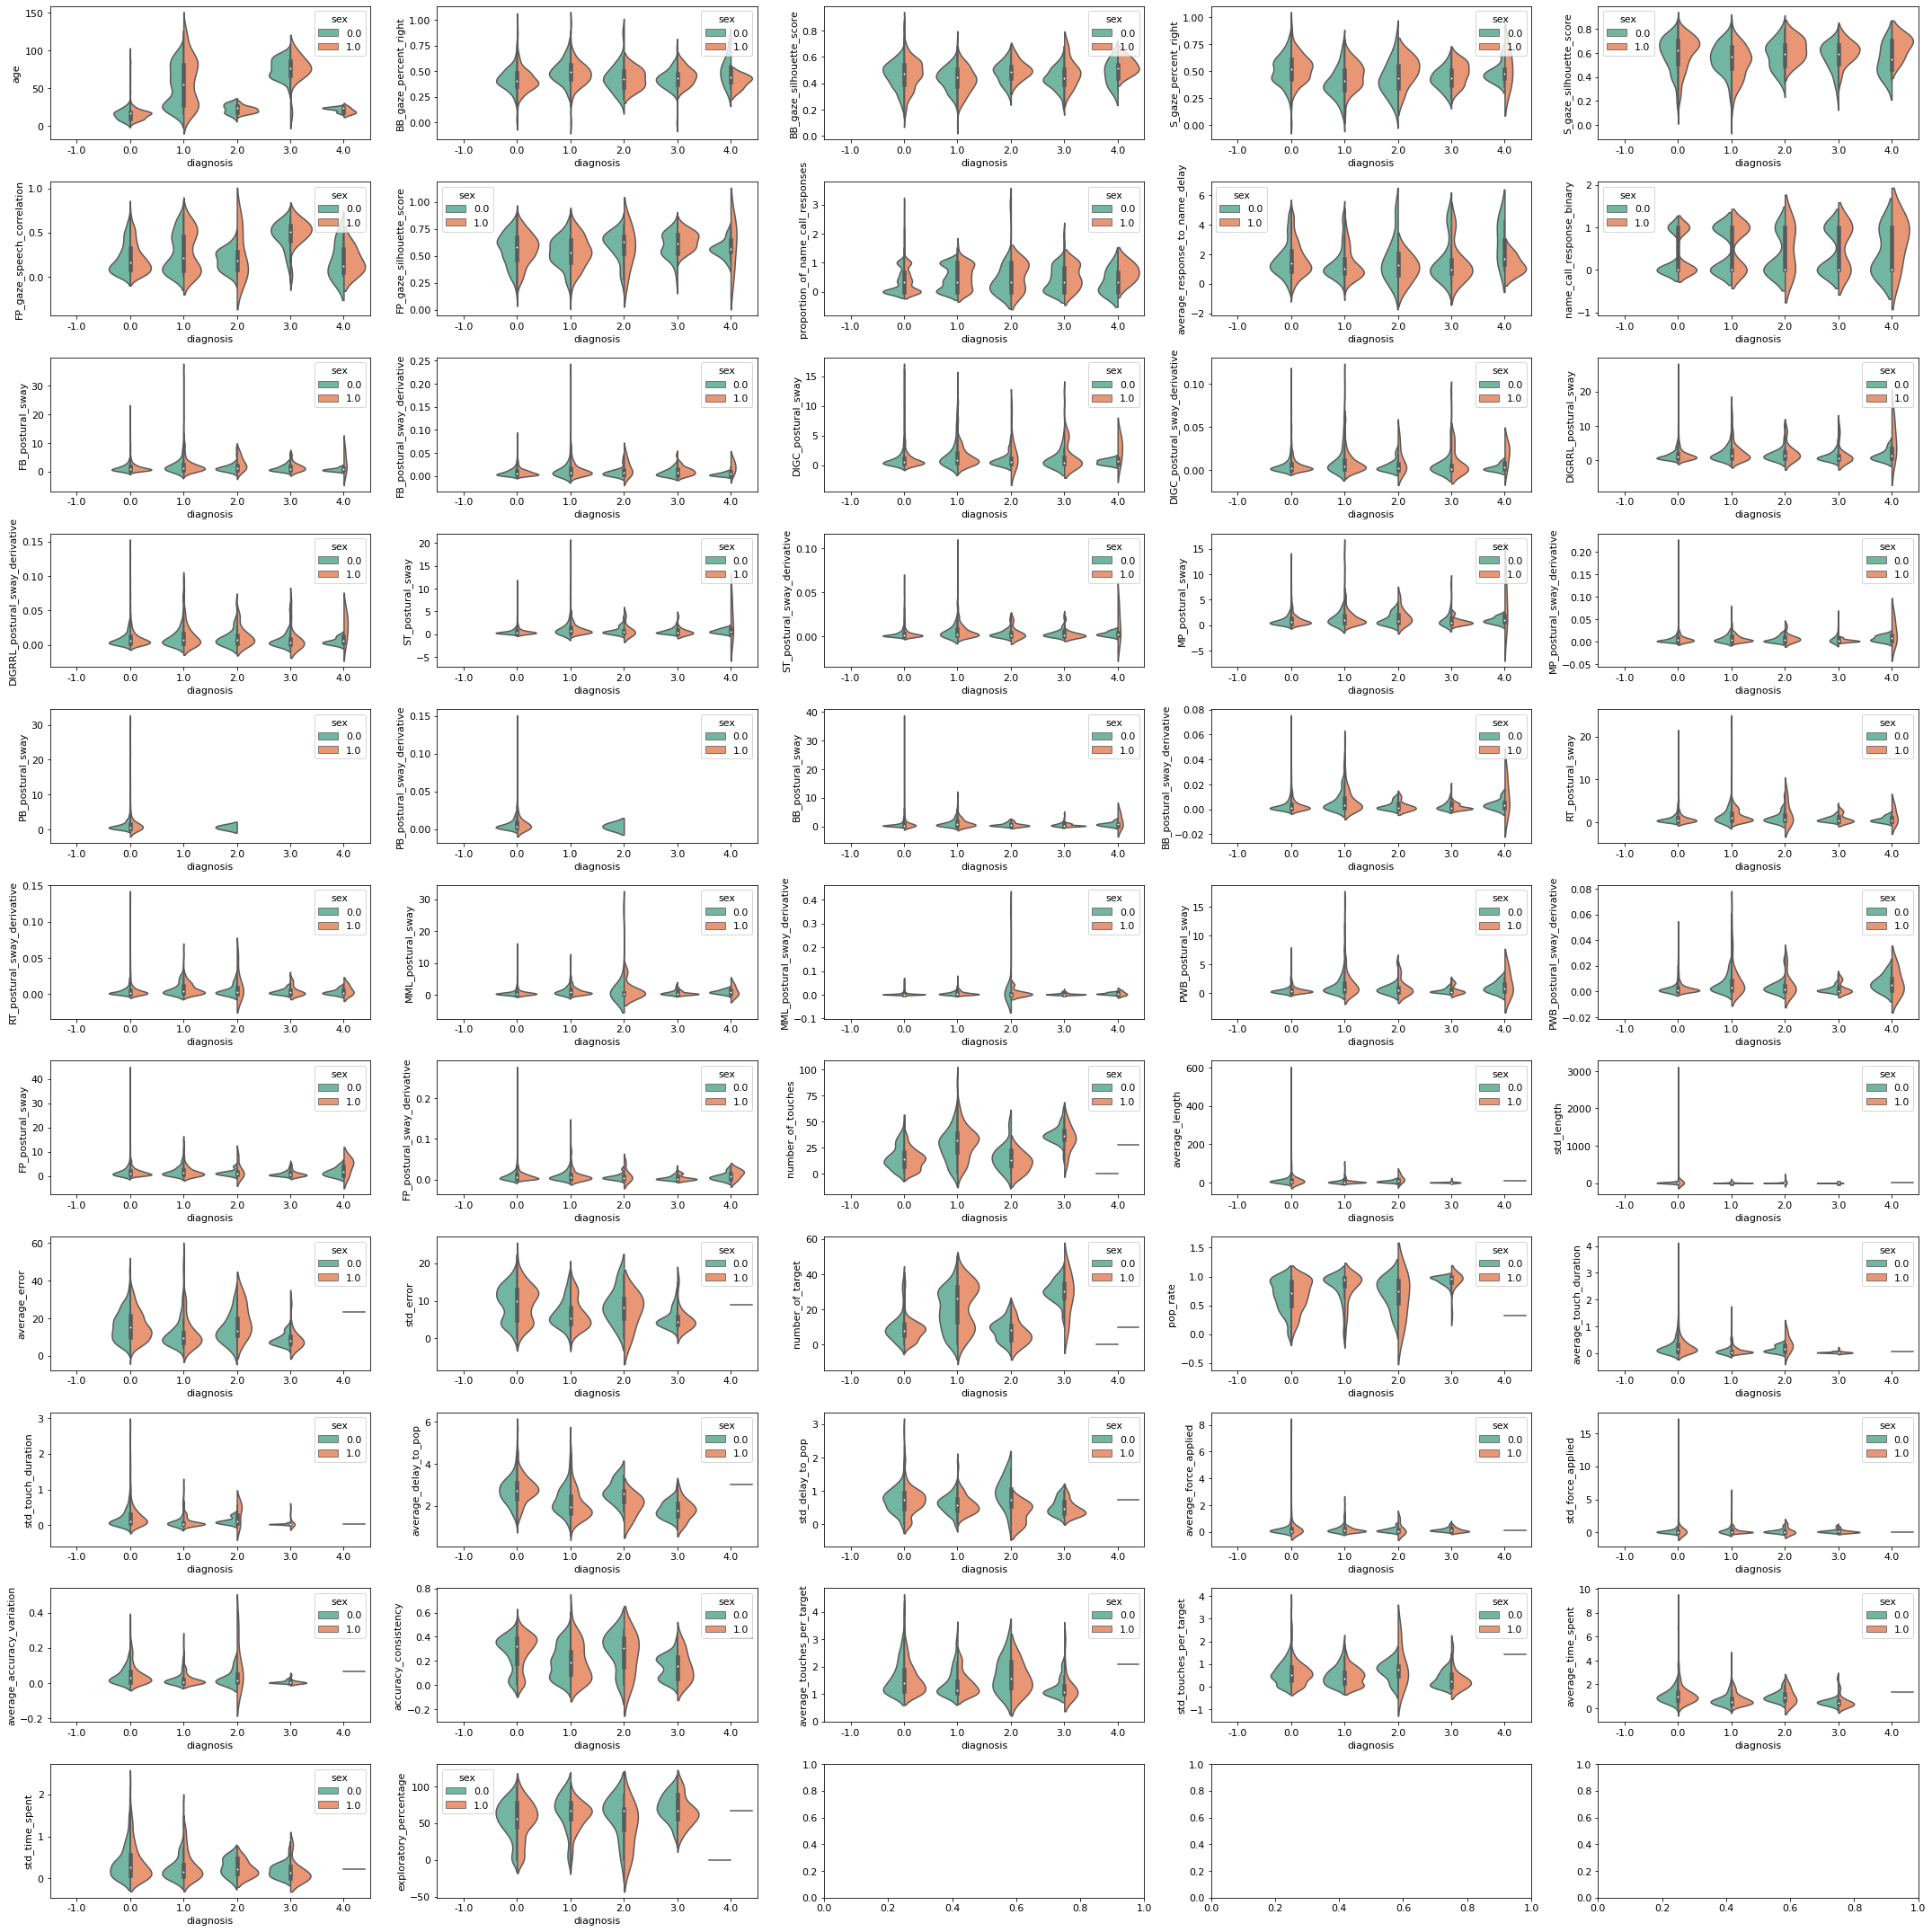

In [70]:
selected_features = ['age'] + CVA_COLUMNS

# Create a figure with 3 x 2 subplots
fig, axes = plt.subplots(ncols=5, nrows=len(selected_features)//5 +1, figsize=(30, 30))
# Loop through these features and plot entries from each feature against `Latitude`
for col, ax in zip(selected_features, axes.ravel()):
    sns.violinplot(data=df, y=col, x='diagnosis', hue='sex', palette="Set2",
                   split=True, ax=ax)
plt.tight_layout()

In [100]:
variables_of_interest = CVA_COLUMNS


X  = data.df[variables_of_interest]
dataset = X.copy()

vars = dataset.dtypes.index.values
n_var = dataset.shape[1]
# mean and covariance estimates
# ideally, this is done with a maximum likelihood estimator
gmean = dataset.mean()
gcov = dataset.cov()

# set up missing data patterns
r = 1 * dataset.isnull()
mdp = np.dot(r, list(map(lambda x: pow(2, x), range(n_var))))
sorted_mdp = sorted(np.unique(mdp))
n_pat = len(sorted_mdp)
correct_mdp = list(map(lambda x: sorted_mdp.index(x), mdp))
data.df["mdp"] = pd.Series(correct_mdp, index=dataset.index)

In [101]:
print("Number of missing patterns: {} (over {} theoretically possible; 2^K)".format(n_pat, 2**len(variables_of_interest)))

Number of missing patterns: 210 (over 2251799813685248 theoretically possible; 2^K)


Text(0.5, 1.0, 'Features missing for the most frequent patterns. 1840 adm (1154 NT, 412 ASD)')

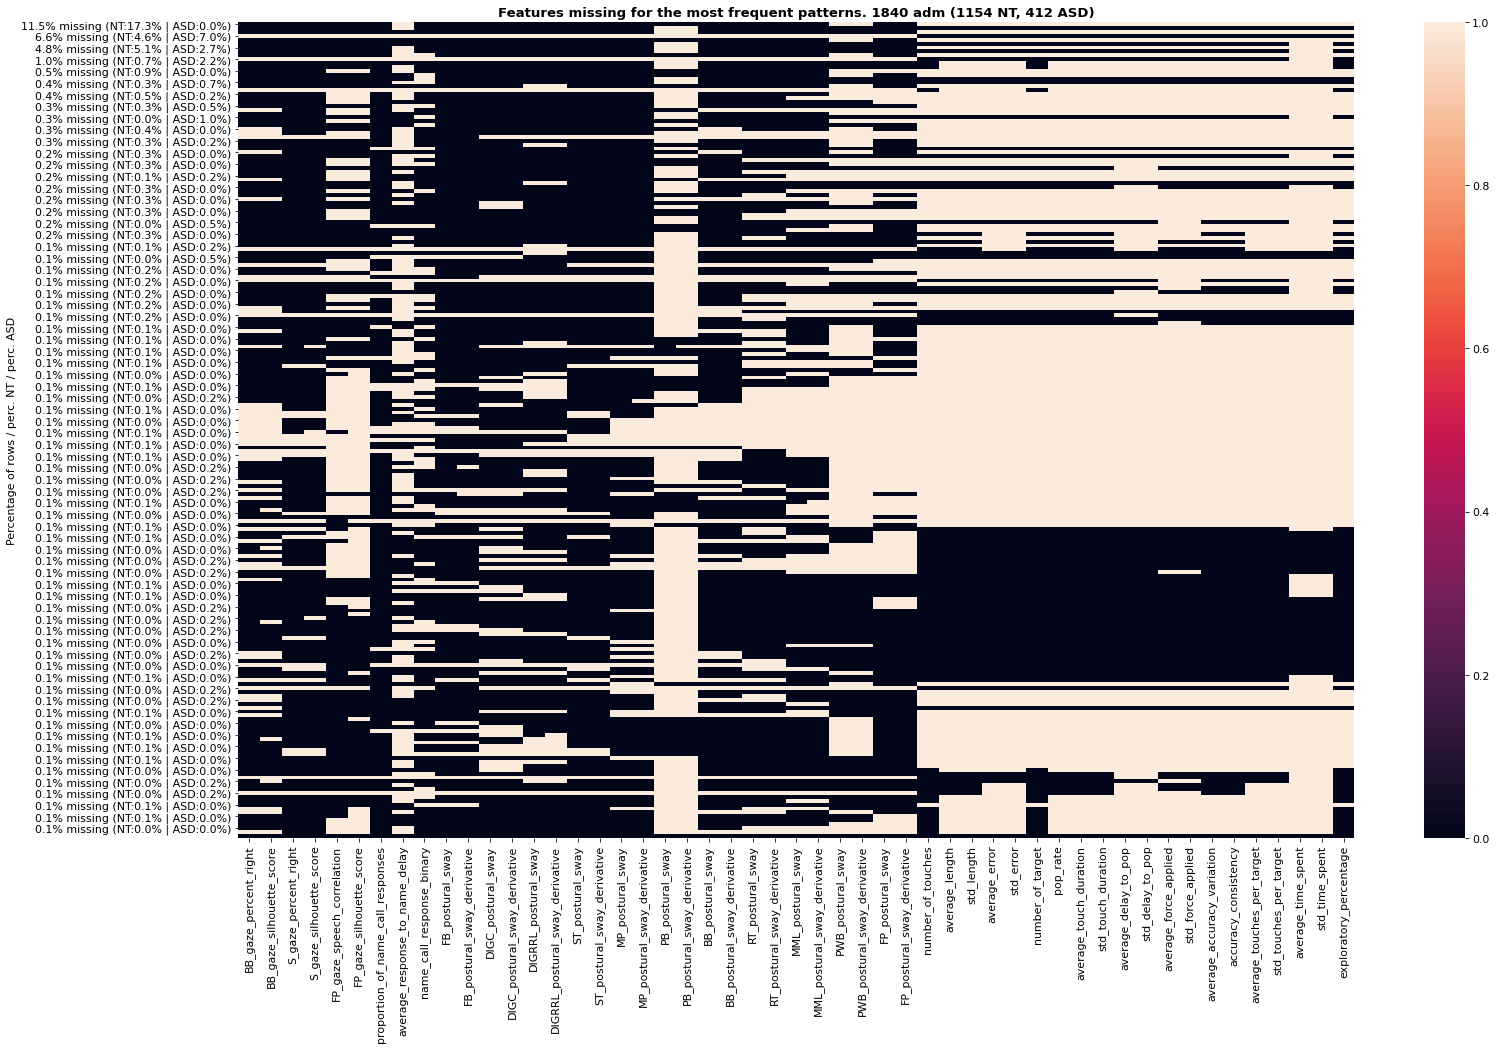

In [102]:

matrix = pd.DataFrame(
            data=np.zeros(shape=(len(data.df["mdp"].value_counts().index), len(variables_of_interest)+1)),
            columns=variables_of_interest+['Percentage of rows'],
            index=data.df["mdp"].unique(),
        ).sort_index()

for pattern in sorted(data.df["mdp"].unique())[1:]:
    d = data.df.loc[data.df['mdp']==pattern, ['diagnosis'] + variables_of_interest]
    missing_columns = list(d.columns[d.isnull().any()])
    matrix.loc[pattern, missing_columns] = 1
    matrix.loc[pattern, 'Percentage of rows'] = np.round(len(d)/len(data.df)*100,2)
    #matrix.loc[pattern, 'Percentage of rows (autism)'] = np.round(len(d[d['diagnosis']==0])/len(data.df[data.df['diagnosis']==0])*100,2)
    #matrix.loc[pattern, 'Percentage of rows (NT)'] = np.round(len(d[d['diagnosis']==1])/len(data.df[data.df['diagnosis']==1])*100,2)
    matrix.loc[pattern, 'Percentage of rows / perc. NT / perc. ASD'] = "{}% missing (NT:{}% | ASD:{}%)".format(np.round(len(d)/len(data.df)*100,1), np.round(len(d[d['diagnosis']==0])/len(data.df[data.df['diagnosis']==0])*100,1), np.round(len(d[d['diagnosis']==1])/len(data.df[data.df['diagnosis']==1])*100,1))
matrix.sort_values('Percentage of rows', ascending=False, inplace=True)
plt.figure(figsize=(25, 15))
sns.heatmap(matrix.set_index('Percentage of rows / perc. NT / perc. ASD').loc[:, variables_of_interest].astype(int))
plt.title("Features missing for the most frequent patterns. {} adm ({} NT, {} ASD)".format(len(data.df), len(data.df[data.df['diagnosis']==0]), len(data.df[data.df['diagnosis']==1])), weight='bold')

<AxesSubplot:ylabel='Percentage of rows / perc. NT / perc. ASD'>

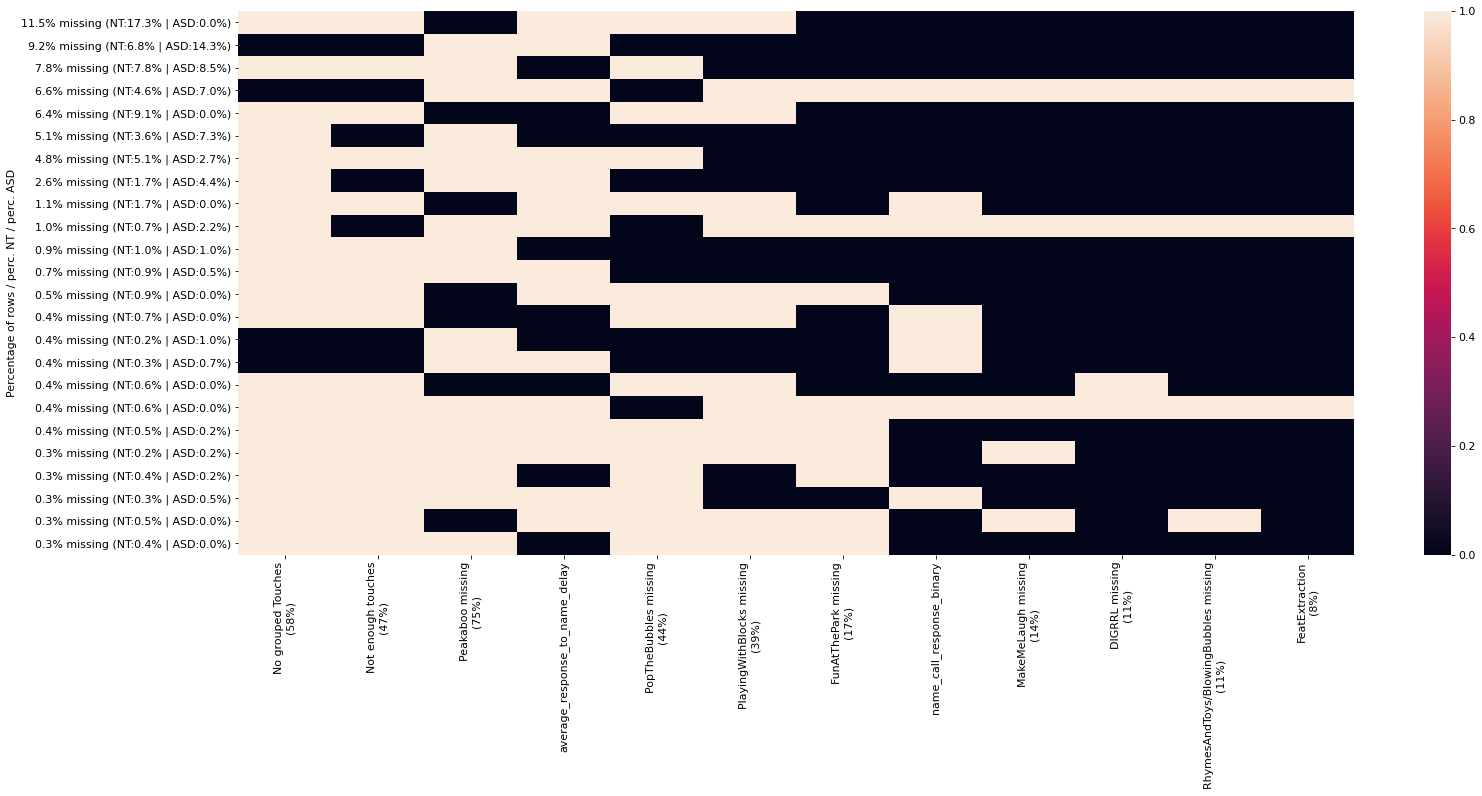

In [103]:
matrix = matrix.loc[matrix['Percentage of rows'] >.3, :].transpose()

new_df = matrix.loc[['Percentage of rows / perc. NT / perc. ASD'], :].copy()
duplicated_rows = matrix[matrix.duplicated(keep=False)]

grouped_features_label = {0:"FeatExtraction", 
                          1: "RhymesAndToys/BlowingBubbles missing", 
                          2: "MakeMeLaugh missing", 
                          3: "DIGRRL missing", 
                          4: "FunAtThePark missing", 
                          5: "Peakaboo missing", 
                          6: "PlayingWithBlocks missing", 
                          7: "PopTheBubbles missing", 
                          8: "Not enough touches", 
                          9: "No grouped Touches", 
                         }
def df_missing_features(df, features, having_features_missing=True):
    if having_features_missing:
        return df.loc[df.drop(index=df.dropna(subset=features, how='all').index).index, :]
    else:
        return df.dropna(subset=features, how='all')
    
    
grouped_features = {}
for idx, (i, f) in enumerate(duplicated_rows.groupby(list(duplicated_rows))):
    grouped_features[idx]=[]
    for col in f.index:
        grouped_features[idx].append(col)    
    
for i, feats in grouped_features.items():
    grouped_features_label[i] += "\n({}%)".format(int(len(df_missing_features(data.df, features=feats, having_features_missing=True))/len(data.df)*100))
    
    
for idx, (i, f) in enumerate(duplicated_rows.groupby(list(duplicated_rows))):
    index = ""
    for col in f.index:
        index+=col+"\n"
    index = index[:-1]
    new_df = new_df.append(pd.DataFrame(data=f.iloc[:1].to_numpy().astype(int), index=[grouped_features_label[idx]], columns=f.columns))
    

    
    
new_df = new_df.append(matrix[~matrix.duplicated(keep=False)].drop(index=['Percentage of rows','Percentage of rows / perc. NT / perc. ASD'])).transpose()
new_df.set_index('Percentage of rows / perc. NT / perc. ASD', inplace=True)
new_df = new_df.loc[:,list(new_df.sum(axis=0).sort_values(ascending=False).index)]

plt.figure(figsize=(25, 10))
sns.heatmap(new_df.astype(int))

## Adding the indicator variables to the dataframe

In [289]:

for i, feats in grouped_features.items():
    data.df['Z_grouped_{}'.format(i)] = 0
    data.df.loc[data.df.drop(index=data.df.dropna(subset=feats, how='all').index).index, 'Z_grouped_{}'.format(i)] = 1


# Little test 


In [35]:
"""Statistical hypothesis test for Missing Completely At Random (MCAR)"""
# Author: Rianne Schouten <https://rianneschouten.github.io/>
# Co-Author: Davina Zamanzadeh <https://davinaz.me/>

from logging import error
import numpy as np
import pandas as pd
from math import pow
from scipy.stats import chi2, ttest_ind

from typing import List, Union
Matrix = Union[pd.DataFrame, np.ndarray]


class MCARTest:
    """
    Statistical hypothesis test for Missing Completely At Random (MCAR)

    Performs Little's MCAR test (see `Little, R.J.A. (1988)`_). Null hypothesis: data is Missing Completely At Random (MCAR). Alternative hypothesis: data is not MCAR.

    .. _`Little, R.J.A. (1988)`: https://www.tandfonline.com/doi/abs/10.1080/01621459.1988.10478722

    Parameters
    ----------
    method : str, {"little", "ttest"}, default : "little"
        Whether to perform a chi-square test on the entire dataset ("little") or separate t-tests for every combination of variables ("ttest"). 

    See also
    --------
    :class:`~pyampute.exploration.md_patterns.mdPatterns` : Displays missing data patterns in incomplete datasets
    
    :class:`~pyampute.ampute.MultivariateAmputation` : Transformer for generating multivariate missingness in complete datasets

    Notes
    -----
    We advise to use Little's MCAR test carefully. Rejecting the null hypothesis may not always mean that data is not MCAR, nor is accepting the null hypothesis a guarantee that data is MCAR. See `Schouten et al. (2021)`_ for a thorough discussion of missingness mechanisms. 

    .. _`Schouten et al. (2021)`: https://journals.sagepub.com/doi/full/10.1177/0049124118799376

    Examples
    --------
    >>> import pandas as pd
    >>> from pyampute.exploration.mcar_statistical_tests import MCARTest
    >>> data_mcar = pd.read_table("data/missingdata_mcar.csv")
    >>> mt = MCARTest(method="little")
    >>> print(mt.little_mcar_test(data_mcar))
    0.17365464213775494    
    """

    def __init__(self, method: str = "little"):
        self.method = method

    def __call__(self, data: Matrix) -> float:
        if self.method == "little":
            return self.little_mcar_test(data)
        elif self.method == "ttest":
            return self.mcar_t_tests(data)
        else:
            error(
                f"Chose {self.method} as test method, which is not supported. Please choose from [little, ttest]."
            )

    @staticmethod
    def little_mcar_test(X: Matrix) -> float:
        """
        Implementation of Little's MCAR test
        
        Parameters
        ----------
        X : Matrix of shape `(n, m)`
            Dataset with missing values. `n` rows (samples) and `m` columns (features).

        Returns
        -------
        pvalue : float
            The p-value of a chi-square hypothesis test. Null hypothesis: data is Missing Completely At Random (MCAR). Alternative hypothesis: data is not MCAR.
        """

        dataset = X.copy()
        vars = dataset.dtypes.index.values
        n_var = dataset.shape[1]

        # mean and covariance estimates
        # ideally, this is done with a maximum likelihood estimator
        gmean = dataset.mean()
        gcov = dataset.cov()

        # set up missing data patterns
        r = 1 * dataset.isnull()
        mdp = np.dot(r, list(map(lambda x: pow(2, x), range(n_var))))
        sorted_mdp = sorted(np.unique(mdp))
        n_pat = len(sorted_mdp)
        correct_mdp = list(map(lambda x: sorted_mdp.index(x), mdp))
        dataset["mdp"] = pd.Series(correct_mdp, index=dataset.index)

        # calculate statistic and df
        pj = 0
        d2 = 0
        for i in range(n_pat):
            dataset_temp = dataset.loc[dataset["mdp"] == i, vars]
            select_vars = ~dataset_temp.isnull().any()
            pj += np.sum(select_vars)
            select_vars = vars[select_vars]
            means = dataset_temp[select_vars].mean() - gmean[select_vars]
            select_cov = gcov.loc[select_vars, select_vars]
            mj = len(dataset_temp)
            parta = np.dot(
                means.T, np.linalg.solve(select_cov, np.identity(select_cov.shape[1]))
            )
            d2 += mj * (np.dot(parta, means))

        df = pj - n_var

        # perform test and save output
        pvalue = 1 - chi2.cdf(d2, df)

        return pvalue

    @staticmethod
    def mcar_t_tests(X: Matrix) -> pd.DataFrame:
        """
        Performs t-tests for MCAR for each pair of features.

        Parameters
        ----------
        X : Matrix of shape `(n, m)`
            Dataset with missing values. `n` rows (samples) and `m` columns (features).

        Returns
        -------
        pvalues : pandas DataFrame of shape `(m, m)`
            The p-values of t-tests for each pair of features. Null hypothesis for cell :math:`pvalues[h,j]`: data in feature :math:`h` is Missing Completely At Random (MCAR) with respect to feature :math:`j` for all :math:`h,j` in :math:`{1,2,...m}`. Diagonal values do not exist. 
        """
        dataset = X.copy()
        vars = dataset.dtypes.index.values
        mcar_matrix = pd.DataFrame(
            data=np.zeros(shape=(dataset.shape[1], dataset.shape[1])),
            columns=vars,
            index=vars,
        )

        for var in vars:
            for tvar in vars:
                part_one = dataset.loc[dataset[var].isnull(), tvar].dropna()
                part_two = dataset.loc[~dataset[var].isnull(), tvar].dropna()
                mcar_matrix.loc[var, tvar] = ttest_ind(
                    part_one, part_two, equal_var=False
                ).pvalue

        return mcar_matrix[mcar_matrix.notnull()]

In [288]:
data.df['stimuli_version'] = data.df['path'].apply(lambda path: path.split('/')[-2])
data.df.loc[~data.df['stimuli_version'].isin(['Older_Than_18', '12_Months', '9_Months', '6_Months']), 'stimuli_version'] = 'Older_Than_18'
data.df['stimuli_version'].value_counts()

Older_Than_18    1030
6_Months          108
9_Months           90
12_Months          60
Name: stimuli_version, dtype: int64

In [287]:
grouped_features

{1: ['BB_gaze_percent_right',
  'BB_gaze_silhouette_score',
  'BB_postural_sway',
  'BB_postural_sway_derivative',
  'RT_postural_sway',
  'RT_postural_sway_derivative'],
 2: ['MML_postural_sway', 'MML_postural_sway_derivative'],
 3: ['DIGRRL_postural_sway', 'DIGRRL_postural_sway_derivative'],
 4: ['FP_gaze_speech_correlation',
  'FP_gaze_silhouette_score',
  'FP_postural_sway',
  'FP_postural_sway_derivative'],
 5: ['PB_postural_sway', 'PB_postural_sway_derivative'],
 6: ['PWB_postural_sway', 'PWB_postural_sway_derivative'],
 7: ['number_of_touches', 'number_of_target', 'exploratory_percentage'],
 8: ['average_length',
  'std_length',
  'average_error',
  'std_error',
  'pop_rate',
  'average_touch_duration',
  'std_touch_duration',
  'average_delay_to_pop',
  'std_delay_to_pop',
  'average_force_applied',
  'std_force_applied',
  'average_accuracy_variation',
  'accuracy_consistency',
  'average_touches_per_target',
  'std_touches_per_target'],
 9: ['average_time_spent', 'std_time_sp

In [284]:
grouped_features
grouped_features_label = {0:"FeatExtraction", 
                          1: "RhymesAndToys/BlowingBubbles missing", 
                          2: "MakeMeLaugh missing", 
                          3: "DIGRRL missing", 
                          4: "FunAtThePark missing", 
                          5: "Peakaboo missing", 
                          6: "PlayingWithBlocks missing", 
                          7: "PopTheBubbles missing", 
                          8: "Not enough touches", 
                          9: "No grouped Touches", 
                         }

## Continuous Variables

In [296]:
variables_of_interest = list(grouped_features.values())
data.filter(administration={'complete':True, 'order': 'first'})

dict_check_1_0 = {9:[8],
                 10:[8, 9]}
    
    
vars = ['age', 'mullen_el',  'mullen_fm','mullen_rl','mullen_vr','mullen_elc_std','ados_total',  'ados_rrb',
         'ados_sa','srs_total_tscore', 'srs_social_awareness_tscore',
         'srs_social_motivation_tscore',
         'cbcl_scaleIV_score',
         'cbcl_asd_score',
         'mchat_total']


mcar_matrix = pd.DataFrame(
    data=np.zeros(shape=(len(vars), len(variables_of_interest))),
    columns=list(grouped_features.keys()),
    index=vars,
)


Removing 116/1956 incomplete administrations.
Removing 581/1840 keeping first admin.
1259 administrations left.


id
diagnosis     
-1.0        90
 0.0       792
 1.0       290
 2.0        27
 3.0        49
 4.0        11

Splitting dataset into test and train set.
Encoding 1259 (train) and 0 (test) missing values with -5.


In [290]:
for i, feats in grouped_features.items():
    for j, var in enumerate(vars):
        
        d = data.df.copy()
        
        # Removing the administration without the game by design (6, 9 nd 12 months versions), or playing with blocks
        if i in [6, 7, 8, 9]:
            d = d[d['stimuli_version']=='Older_Than_18']
            
        # removing the 18 Mo version for the Peakaboo features 
        elif i == 5:
            d = d[d['stimuli_version']!='Older_Than_18']

            
        
        if i in dict_check_1_0.keys():
            for idx_group_that_should_be_there in dict_check_1_0[i]:
                d = d[d['Z_grouped_{}'.format(idx_group_that_should_be_there)]==0]
                
        
        having = df_missing_features(d, feats, having_features_missing=False)[var].dropna()
        missing = df_missing_features(d, feats, having_features_missing=True)[var].dropna()
        
        if len(having) < 20 or len(missing) < 20:
            mcar_matrix.loc[var, i] = np.nan
            continue
            
        mcar_matrix.loc[var, i] = ttest_ind(having, missing, equal_var=False).pvalue


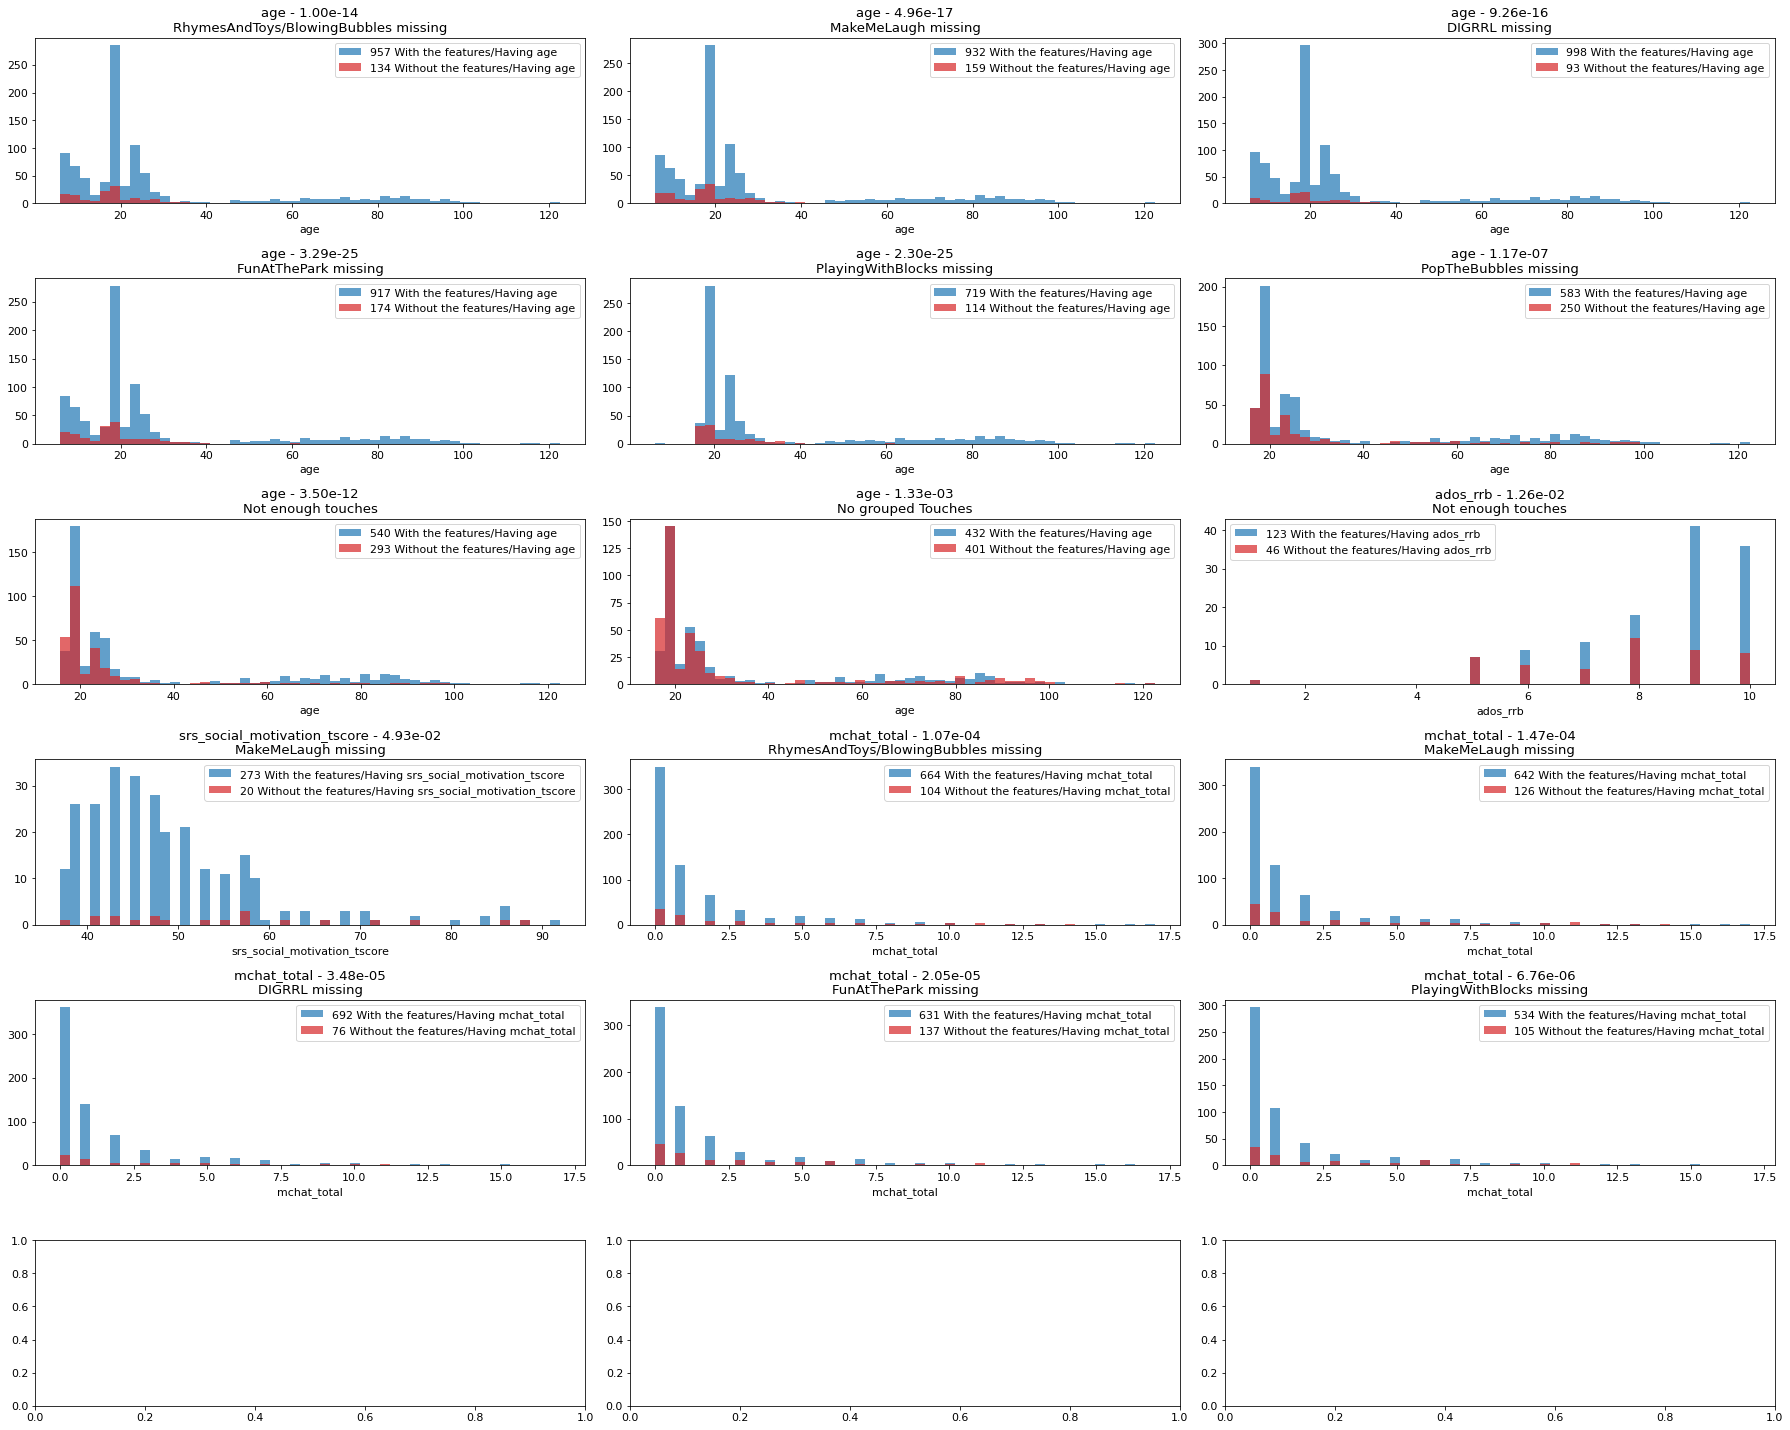

In [291]:
mask  = (mcar_matrix<0.05).astype(int)

locations = [(index, column) for index in mask.index for column in mask.columns if mask.loc[index, column]==1]

fig, axes = plt.subplots(len(locations)//3+1, 3, figsize=(25, 20));axes = axes.flatten()
for j, (var, idx) in enumerate(locations):
    feats = grouped_features[idx]
    
    d = data.df.copy()

    # Removing the administration without the game by design (6, 9 nd 12 months versions), or playing with blocks
    if idx in [6, 7, 8, 9]:
        d = d[d['stimuli_version']=='Older_Than_18']

    # removing the 18 Mo version for the Peakaboo features 
    elif idx == 5:
        d = d[d['stimuli_version']!='Older_Than_18']
    
    having = df_missing_features(d, feats, having_features_missing=False)[var].dropna()
    missing = df_missing_features(d, feats, having_features_missing=True)[var].dropna()
    
    _, bins, _ = axes[j].hist(having, density=False, bins = 50, color='tab:blue', label='{} With the features/Having {}'.format(len(having), var), alpha=.7)
    axes[j].hist(missing, bins = bins, density=False, color='tab:red', label='{} Without the features/Having {}'.format(len(missing), var), alpha=.7)
    axes[j].set_title("{} - {:.2e}\n{}".format(var, mcar_matrix.loc[var, idx], grouped_features_label[idx]));axes[j].set_xlabel(var)
    axes[j].legend()
plt.tight_layout()

### Categorical Variables

In [292]:
variables_of_interest = list(grouped_features.values())
vars = ['StateOfTheChild','SiblingsInTheRoom','ShotsVaccines','Distractions','FamilyMemberDistract','PetDistract',
        'PetNoiseDistract','DoorbellPhoneDistract','TVOnDistract','OtherDistract','SittingUp','Hungry','Diaper','AppTeamComment',
        'Comments','sex','diagnosis','ados_total','ados_rrb','ados_sa','mchat_result']

from scipy.stats import chi2_contingency
mcar_matrix = pd.DataFrame(data=np.zeros(shape=(len(vars), len(variables_of_interest))),
                            columns=list(grouped_features.keys()),
                            index=vars)

In [293]:
for i, feats in grouped_features.items():

    for j, var in enumerate(vars):
        
        d = data.df.copy()
        
        # Removing the administration without the game by design (6, 9 nd 12 months versions), or playing with blocks
        if idx in [6, 7, 8, 9]:
            d = d[d['stimuli_version']=='Older_Than_18']

        # removing the 18 Mo version for the Peakaboo features 
        elif idx == 5:
            d = d[d['stimuli_version']!='Older_Than_18']

            
        if i in dict_check_1_0.keys():
            for idx_group_that_should_be_there in dict_check_1_0[i]:
                d = d[d['Z_grouped_{}'.format(idx_group_that_should_be_there)]==0]
                
        
        having = df_missing_features(d, feats, having_features_missing=False)[var].dropna()
        missing = df_missing_features(d, feats, having_features_missing=True)[var].dropna()
        
        
        
        table = pd.crosstab(d['Z_grouped_{}'.format(i)], d[var]).to_numpy()
        
        stat, p, dof, expected = chi2_contingency(np.array(table))
        
        values_with = d[d['Z_grouped_{}'.format(i)]==0][var].dropna()
        values_without = d[d['Z_grouped_{}'.format(i)]==1][var].dropna()
        
        if len(values_with) < 20 or len(values_without) < 20:
            mcar_matrix.loc[var, i] = np.nan
            continue

    
        mcar_matrix.loc[var, i] = p
    

In [160]:
mcar_matrix

1             2             3             4             5             6             7             8         9
StateOfTheChild        2.799160e-04  6.390750e-04  6.036329e-01  1.505933e-03           NaN  5.372869e-04  2.033350e-01  1.258197e-01  0.079791
SiblingsInTheRoom      6.705183e-01  1.938933e-01  3.185526e-02  1.039875e-01           NaN  1.427149e-01  7.397738e-02  5.008430e-02  0.387312
ShotsVaccines          8.337939e-02  1.988749e-01           NaN  2.519561e-01           NaN  3.094360e-01  3.099734e-03  3.311007e-03  0.956003
Distractions           7.700515e-02  6.292630e-04  6.507420e-03  7.991370e-06           NaN  2.484558e-06  1.869810e-02  2.621904e-02  0.564456
FamilyMemberDistract   1.025997e-01  3.445160e-03  1.222215e-02  3.286809e-05           NaN  1.201312e-05  1.216711e-02  1.262169e-02  0.928582
PetDistract            4.325873e-01  5.189244e-01  2.881610e-01  5.852816e-01           NaN  5.558138e-01  8.443547e-01  7.250223e-01  1.000000
PetNoiseDistract       6.466728e-01  7.449701e-01  4.744511e-01  4.676072e-02           NaN  7.862448e-01  5.808497e-01  4.649732e-01  1.000000
DoorbellPhoneDistract  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00           NaN  1.000000e+00  1.000000e+00  1.000000e+00  1.000000
TVOnDistract           6.466728e-01  7.449701e-01  4.744511e-01  8.189563e-01           NaN  7.862448e-01  5.808497e-01  4.649732e-01  0.877979
OtherDistract          1.000000e+00  7.449701e-01  1.000000e+00  8.189563e-01           NaN  7.862448e-01  5.236724e-02  9.572224e-02  1.000000
SittingUp              1.702201e-21  3.987559e-28  7.988490e-31  2.949020e-36           NaN  2.793102e-34  1.617168e-07  1.013543e-06  0.269799
Hungry                 1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00           NaN  1.000000e+00  1.000000e+00  1.000000e+00  1.000000
Diaper                 1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00           NaN  1.000000e+00  1.000000e+00  1.000000e+00  1.000000
AppTeamComment                  NaN           NaN           NaN           NaN           NaN           NaN           NaN           NaN       NaN
Comments                        NaN  1.000000e+00           NaN  1.000000e+00           NaN  1.000000e+00  1.000000e+00  1.000000e+00  1.000000
sex                    2.163068e-01  3.643868e-01  5.178501e-02  2.813376e-01           NaN  6.199719e-01  9.683147e-01  8.249142e-01  0.470272
diagnosis              6.676656e-03  1.090146e-03  2.814789e-04  2.550849e-02  4.002607e-58  3.010779e-19  5.193506e-10  9.079442e-13  0.390797
ados_total                      NaN           NaN           NaN           NaN           NaN           NaN  9.161876e-01  5.701926e-01  0.683153
ados_rrb                        NaN           NaN           NaN           NaN           NaN           NaN  2.040574e-01  8.424078e-02  0.401764
ados_sa                         NaN           NaN           NaN           NaN           NaN           NaN  1.814838e-01  1.916365e-01  0.412671
mchat_result           3.082493e-05  4.593361e-06  3.555561e-08  4.646235e-06           NaN  8.597667e-07  1.407406e-01  1.419396e-02  1.000000

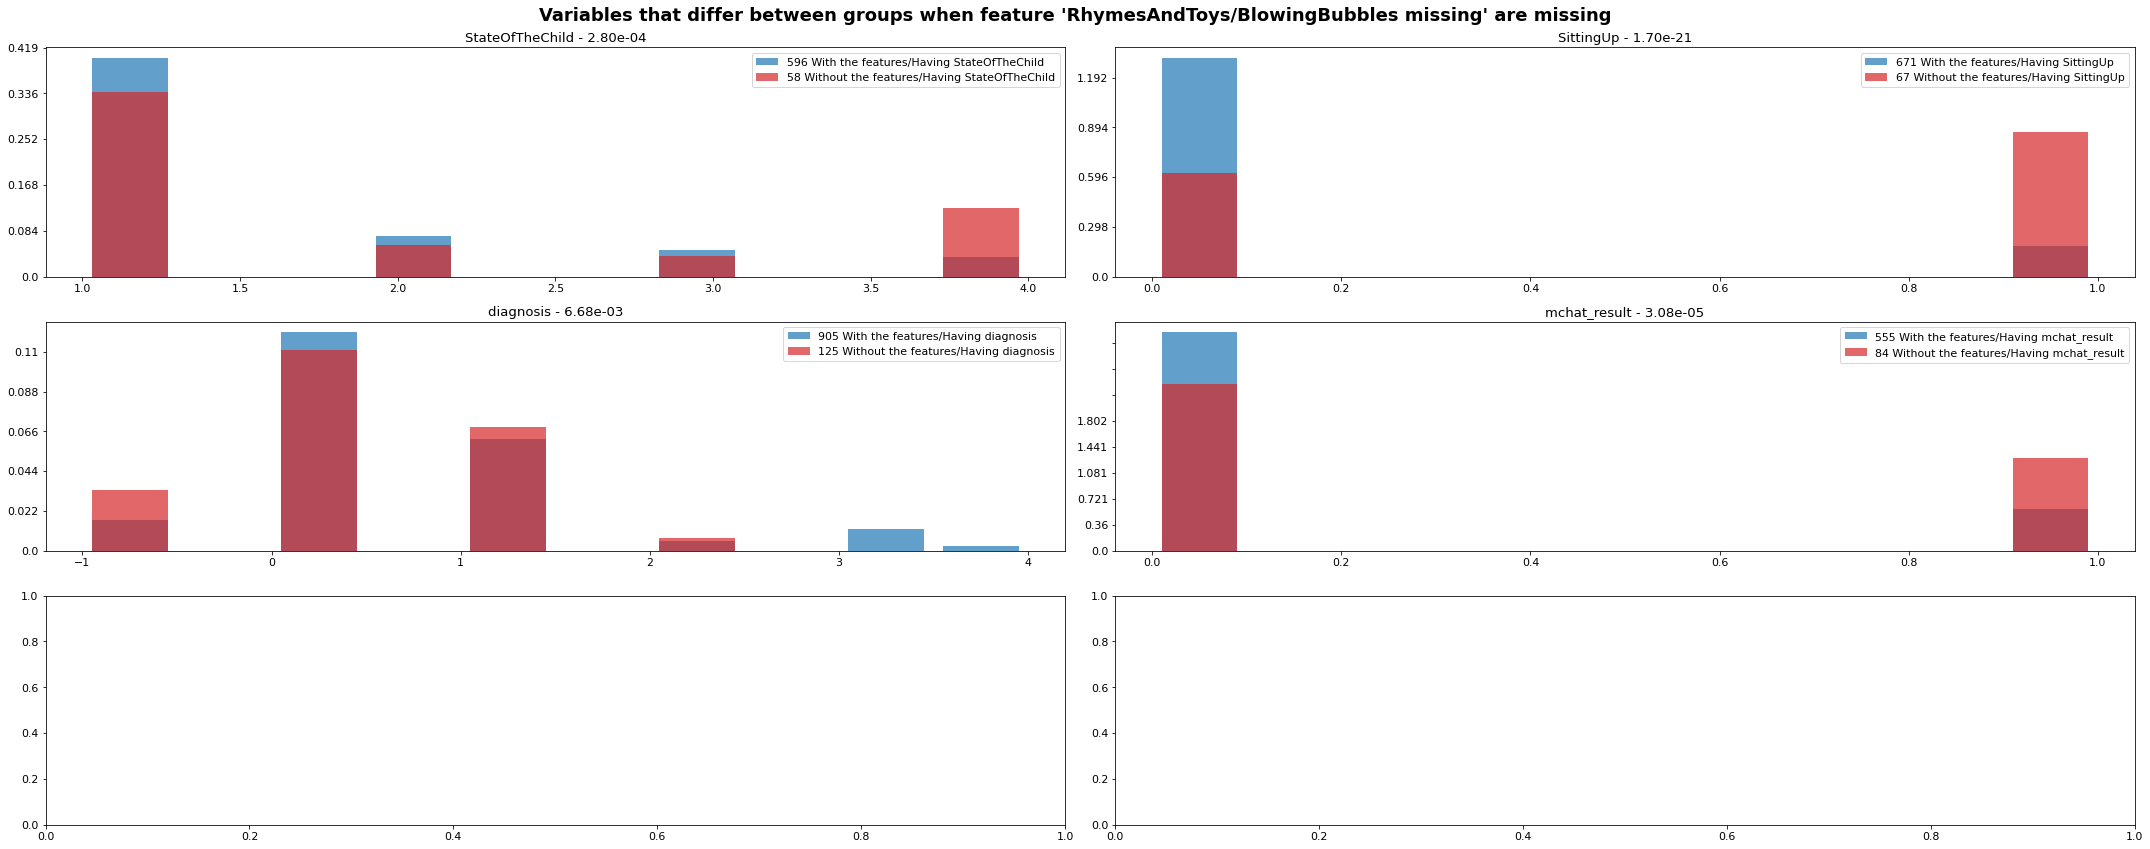

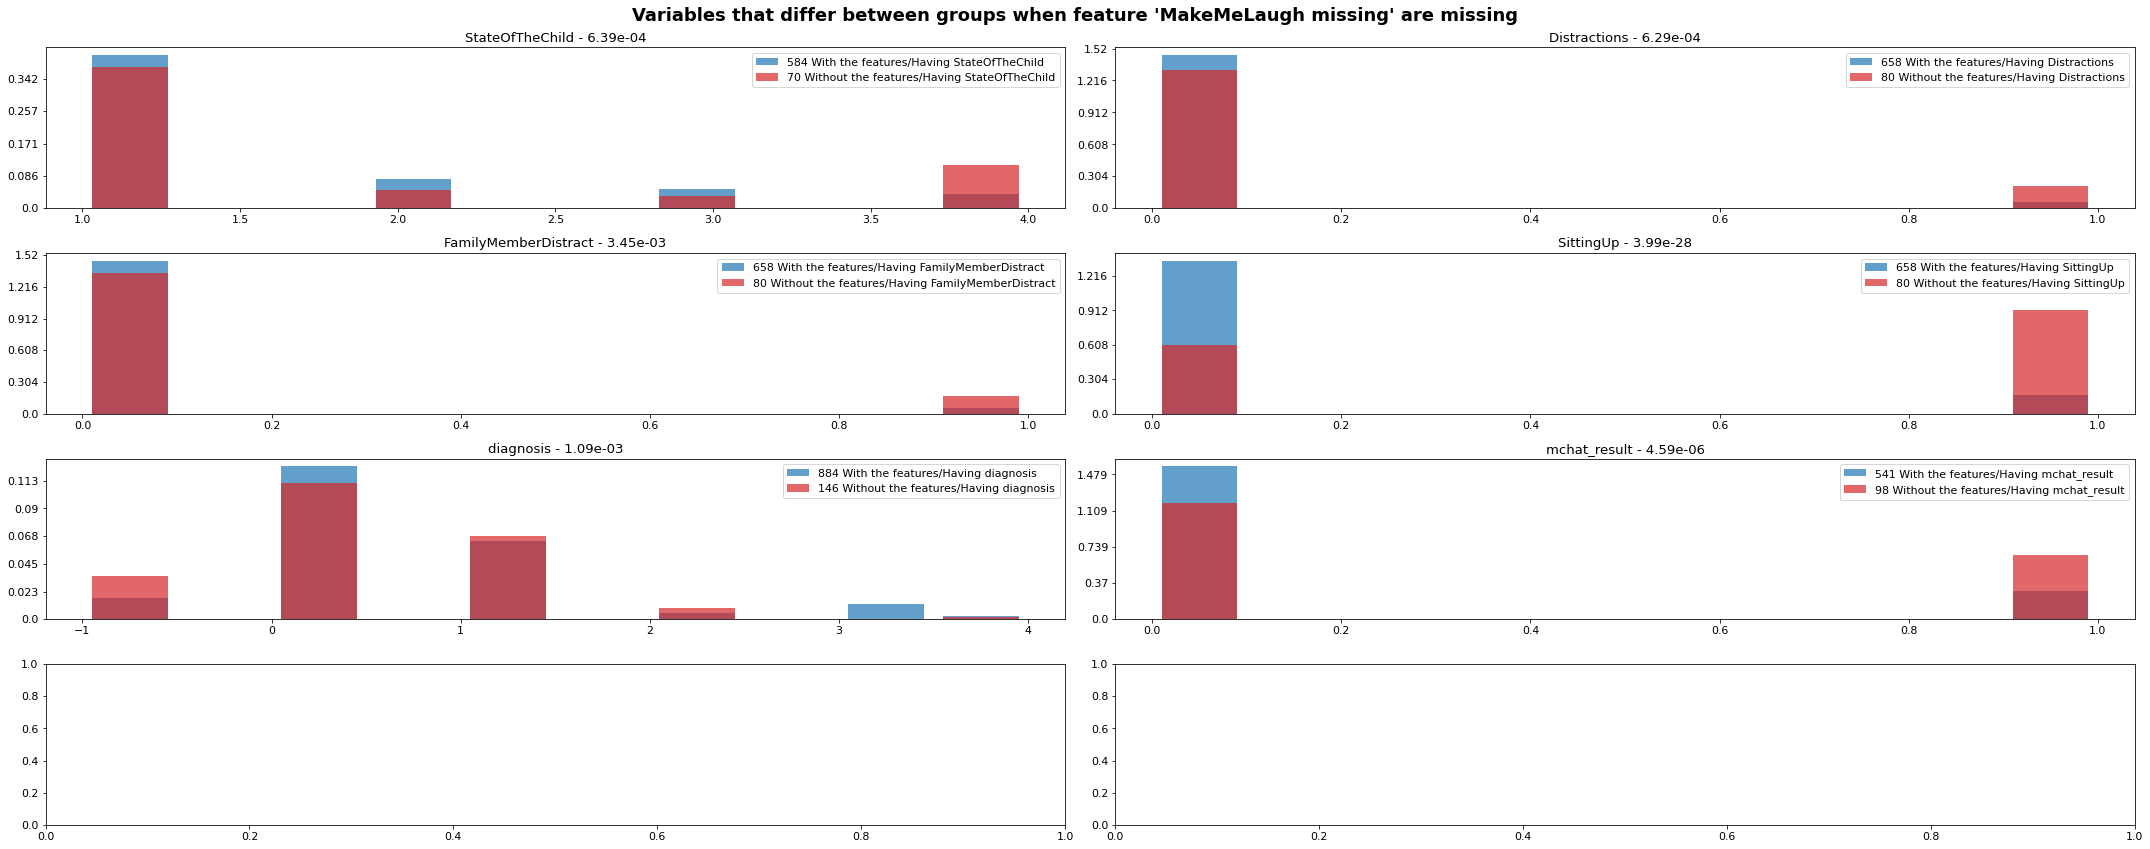

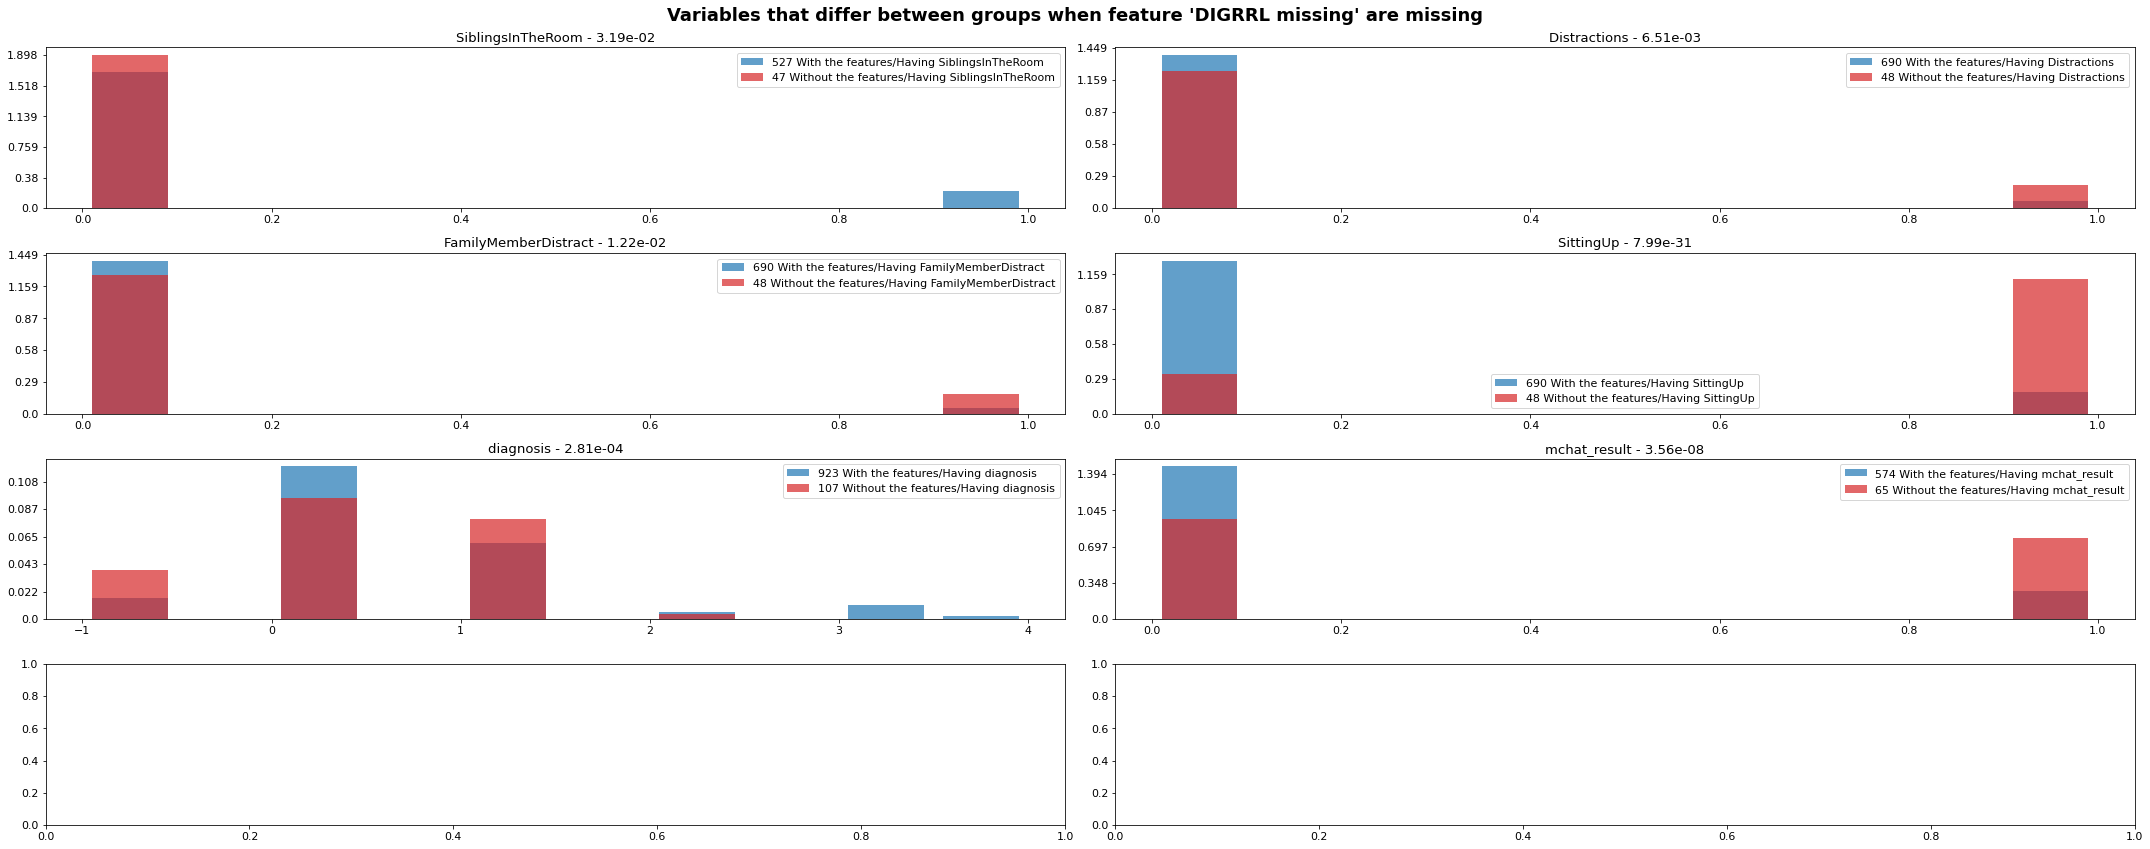

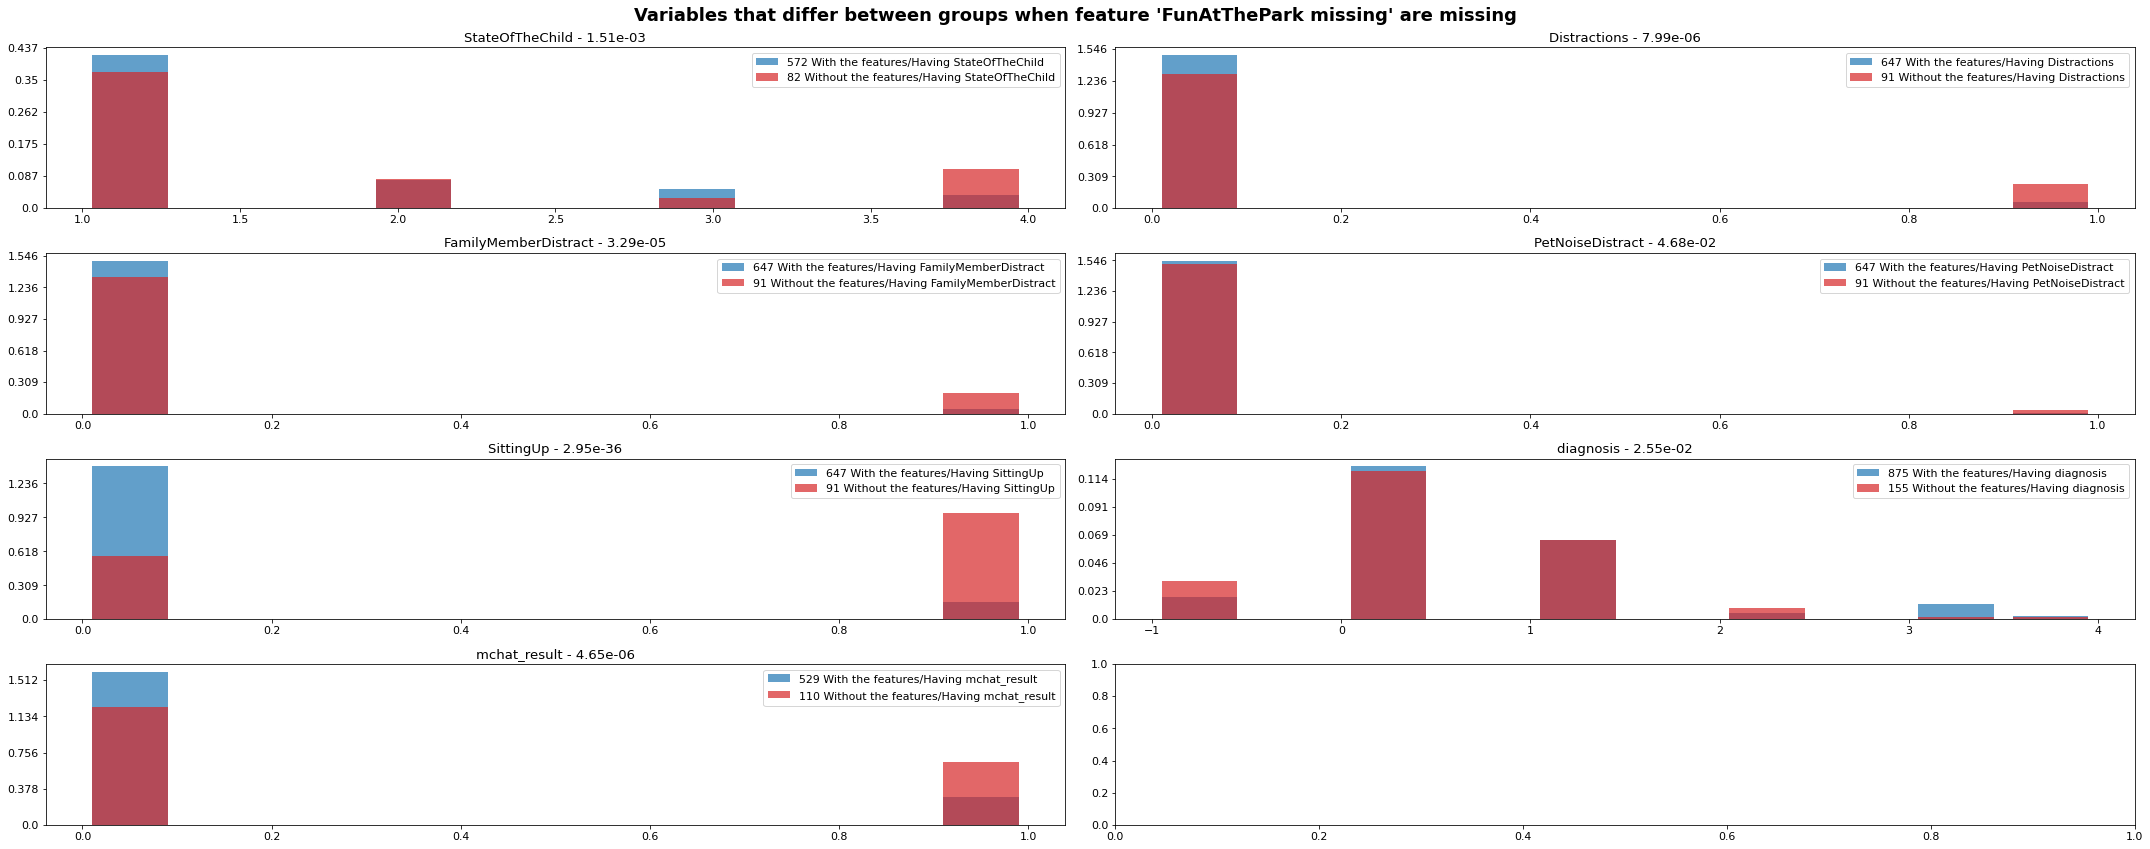

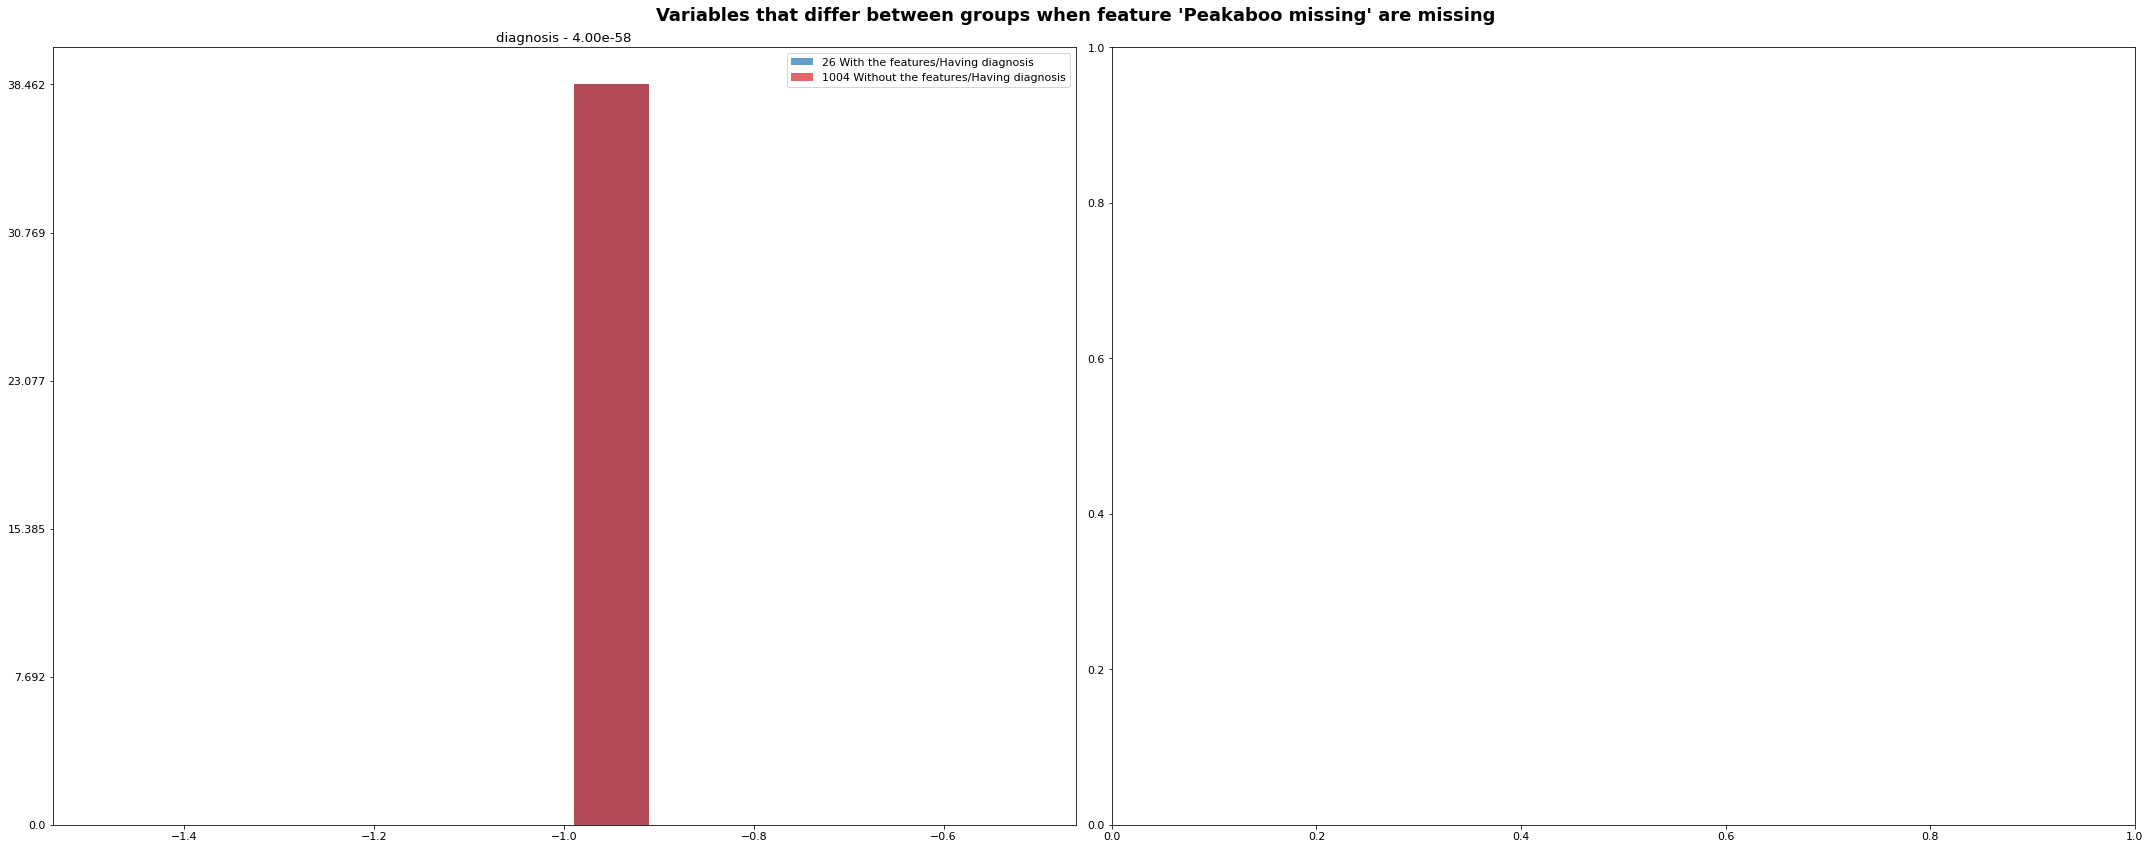

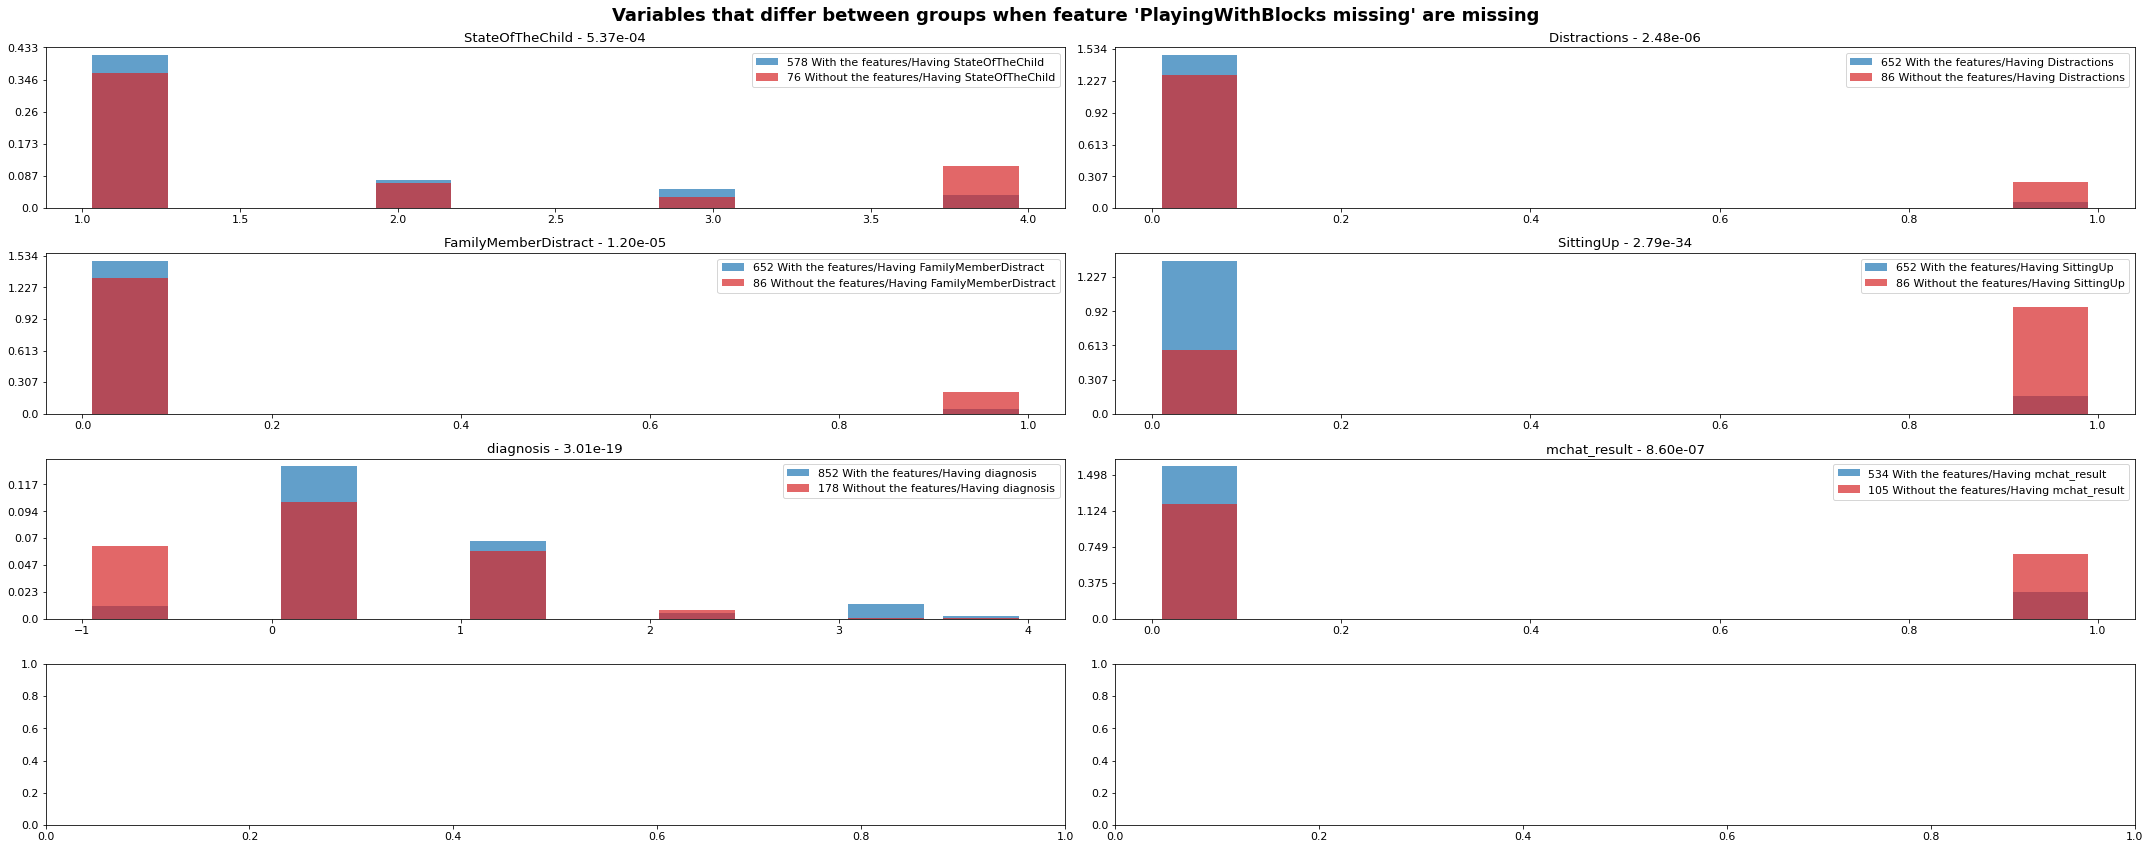

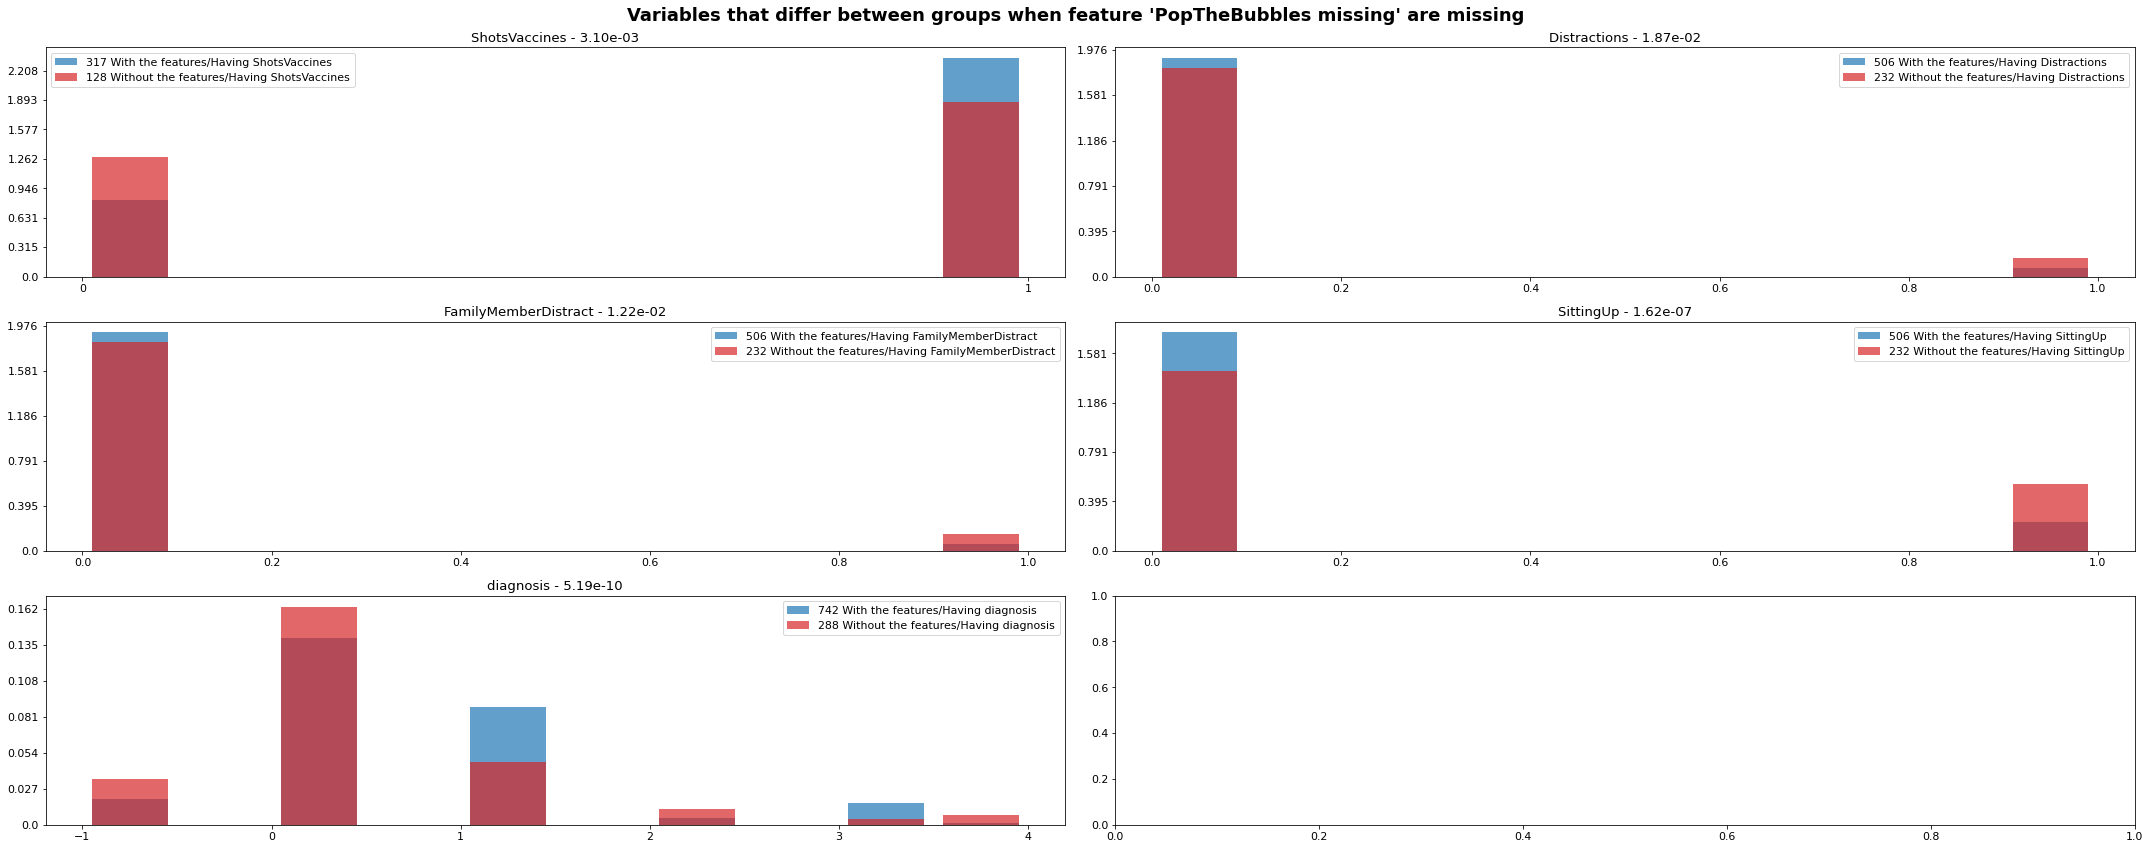

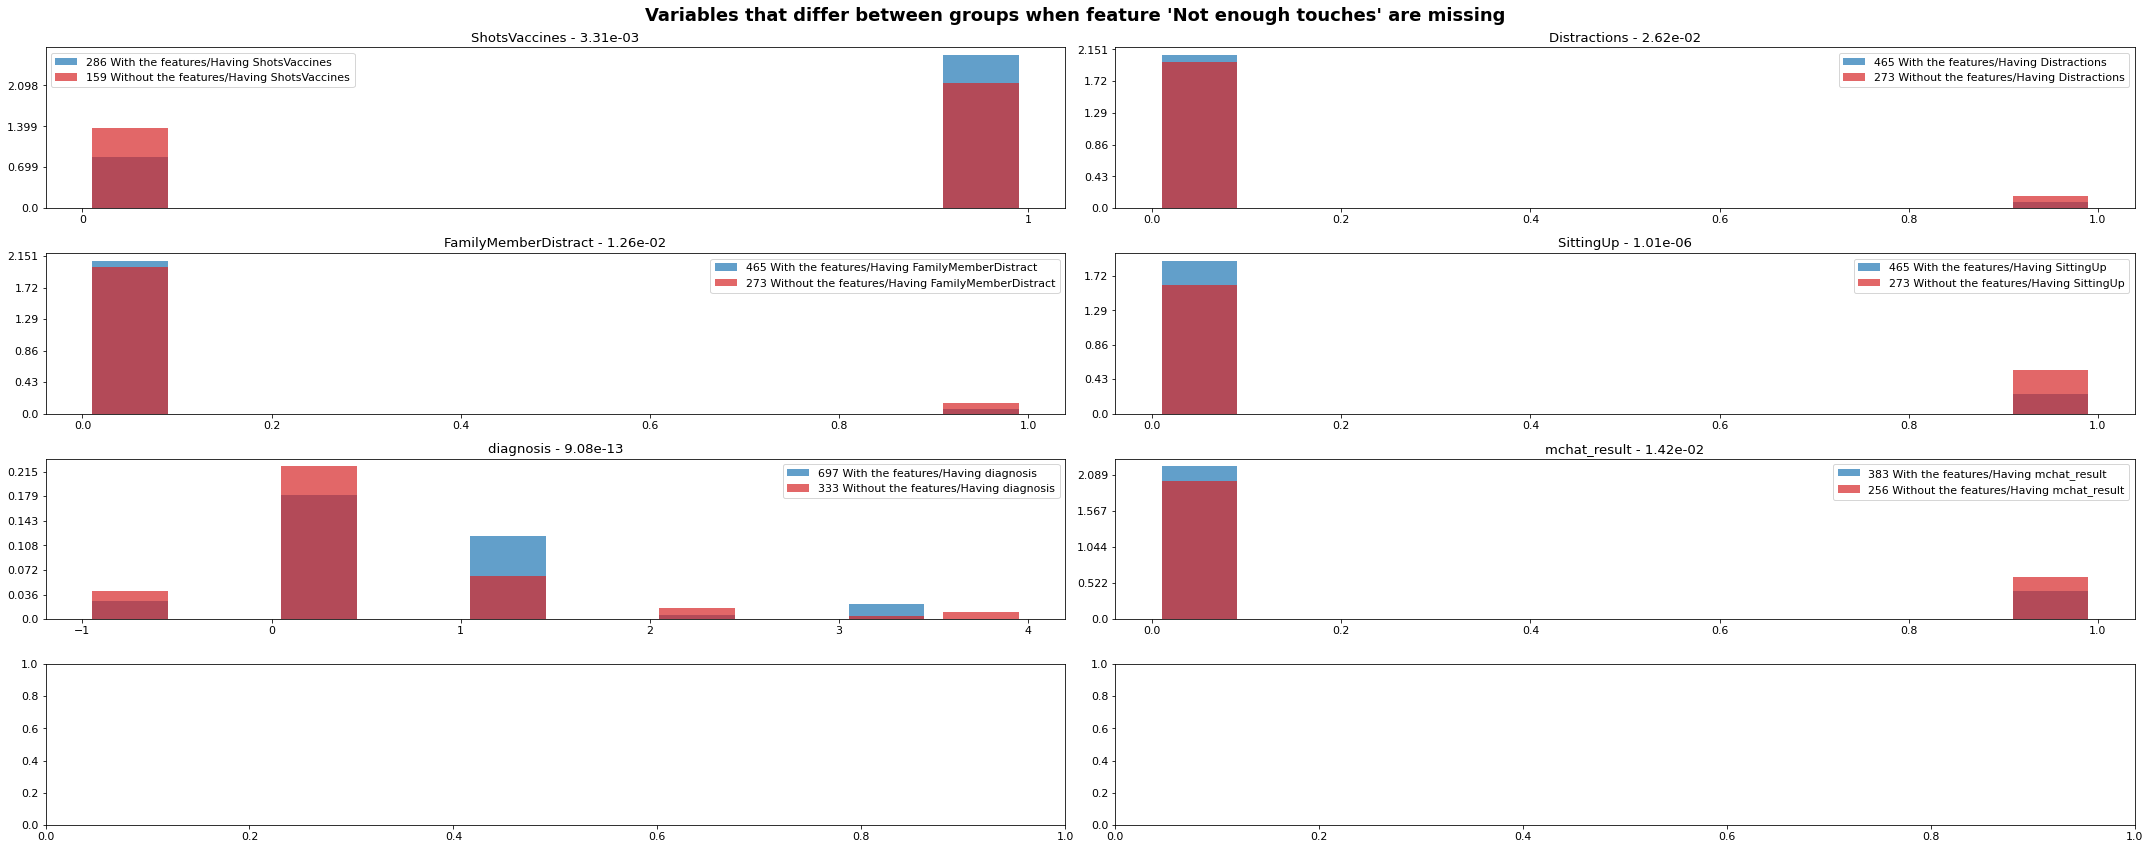

In [161]:
mask  = (mcar_matrix<0.05).astype(int)

locations = [(index, column) for index in mask.index for column in mask.columns if mask.loc[index, column]==1]
for i, row in mask.transpose().iterrows():
    
    variables_with_interactions = list(row[row==1].index)
    n_plot = len(variables_with_interactions)
    if n_plot==0:
        continue
        
        

    fig, axes = plt.subplots(n_plot//2+1, 2, figsize=(30, 12));axes = axes.flatten()
    fig.suptitle("Variables that differ between groups when feature '{}' are missing".format(grouped_features_label[i]), weight='bold', fontsize=18)
    for j, var in enumerate(variables_with_interactions):
        feats = grouped_features[i]
        
        d = data.df.copy()
    
        # Removing the administration without the game by design (6, 9 nd 12 months versions), or playing with blocks
        if idx in [6, 7, 8, 9]:
            d = d[d['stimuli_version']=='Older_Than_18']

        # removing the 18 Mo version for the Peakaboo features 
        elif idx == 5:
            d = d[d['stimuli_version']!='Older_Than_18']


        if i in dict_check_1_0.keys():
            for idx_group_that_should_be_there in dict_check_1_0[i]:
                d = d[d['Z_grouped_{}'.format(idx_group_that_should_be_there)]==0]
                
        
        having = d[d['Z_grouped_{}'.format(i)]==0][var].dropna()
        missing = d[d['Z_grouped_{}'.format(i)]==1][var].dropna()
        
        _, bins, _ = axes[j].hist(having,color='tab:blue',density=True, rwidth=.8, label='{} With the features/Having {}'.format(len(having), var), alpha=.7)
        axes[j].hist(missing, density=True, bins = bins, color='tab:red', rwidth=.8, label='{} Without the features/Having {}'.format(len(missing), var), alpha=.7)
        locs = axes[j].get_yticks(); axes[j].set_yticklabels(np.round(locs/len(having)*100,3))
        axes[j].set_title("{} - {:.2e}".format(var, mcar_matrix.loc[var, i]))
        axes[j].legend()
    plt.tight_layout();plt.show()

# Histogram of values of validity data columns


        # encode categorical variables
        df['diagnosis'].replace({'TD':0., 
                                'ASD':1., 
                                'DDLD':2., 
                                'ADHD':3.}, inplace = True)

        df['ethnicity'].replace({'Not Hispanic/Latino':0, 
                                'Hispanic/Latino':1, 
                                 'Unknown or not reported':np.nan}, inplace = True)

        df['race'].replace({'White':0., 
                    'White/Caucasian':0.,
                    'Black/African American':1., 
                    'More than one race':2.,
                    'American Indian/Alaskan Native':3.,
                    'Other':np.nan,
                    'Asian':np.nan,
                    'Unknown or not reported':np.nan,
                    'Unknown/Declined':np.nan,
                   }, inplace = True)

        df['sex'].replace({'M':0, 'F':1}, inplace=True)
        df['completed'].replace({'Complete (Do not readminister)':0, 'Partial (Do not readminister)':1, 'Incomplete (Readminister at next visit)':2}, inplace = True)

        df['StateOfTheChild'].replace({'In a calm and/or good mood':1, 'Slightly irritable':2, 'Somewhat distressed':3, 'Crying and/or tantrum':4}, inplace = True)
                

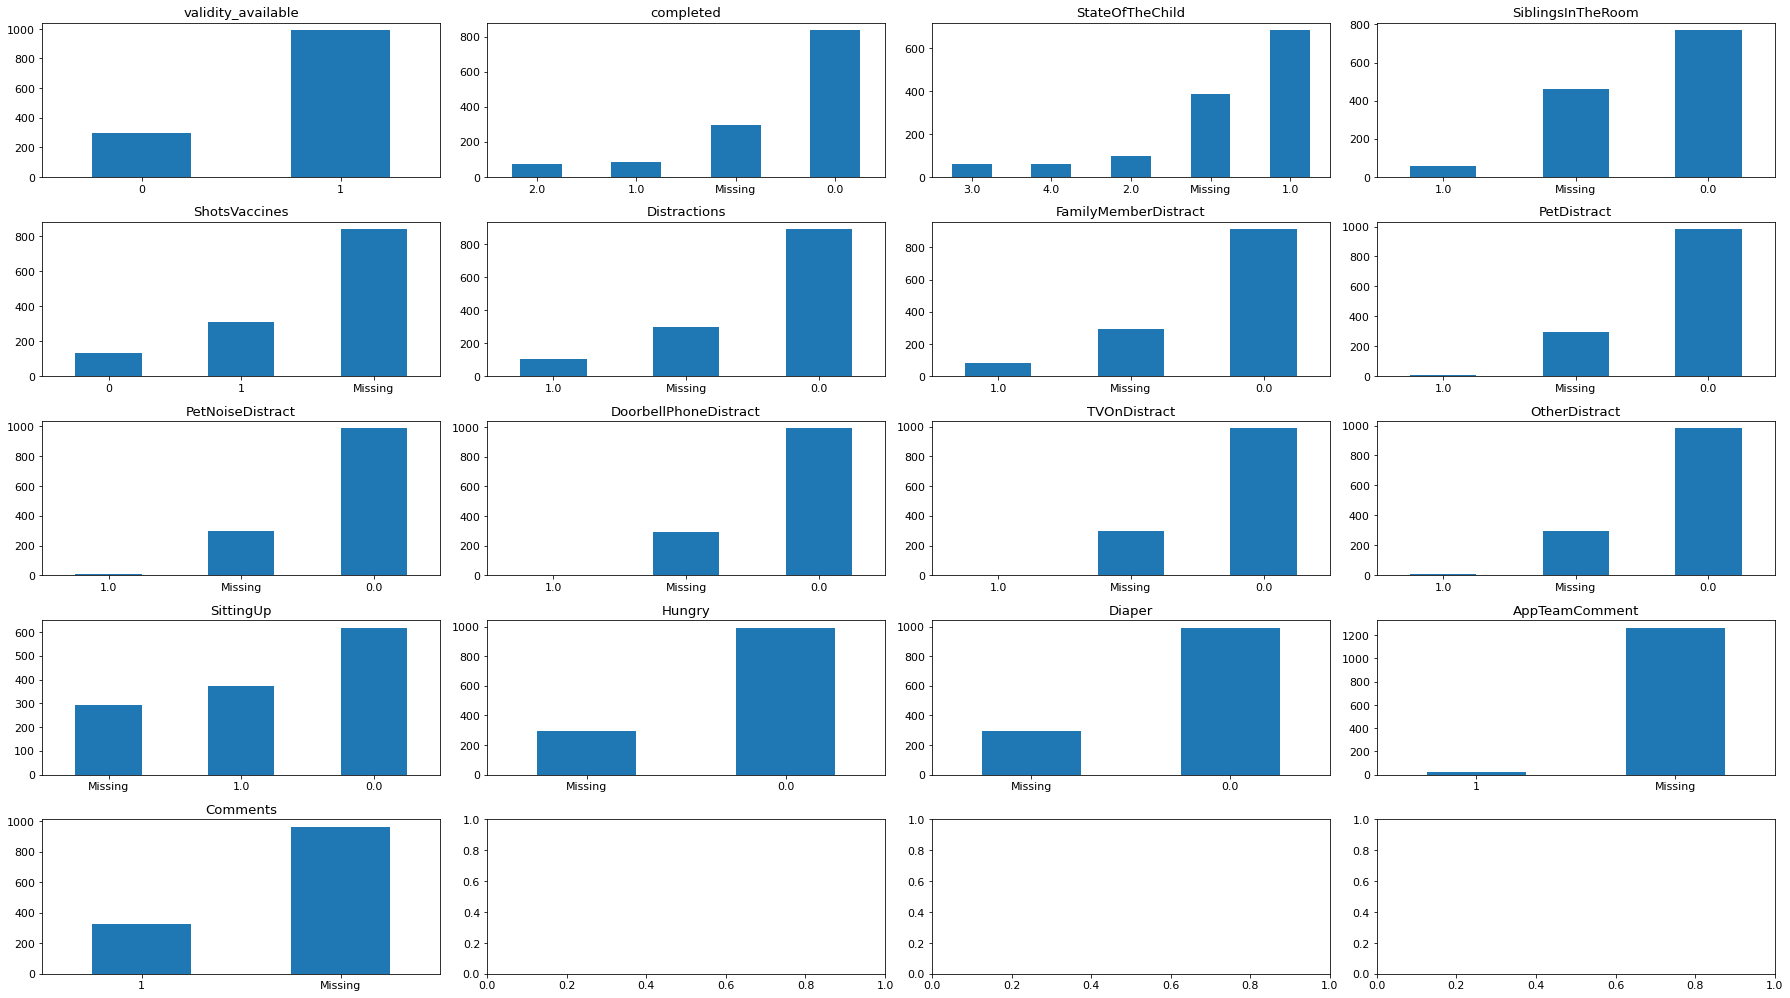

In [ ]:
n_plot = len(VALIDITY_COLUMNS)

fig, axes = plt.subplots(n_plot//4+1, 4, figsize=(25, 14)); axes=axes.flatten()

for i, col in enumerate(VALIDITY_COLUMNS):
    data.df[col].replace({np.nan:'Missing'}).value_counts().sort_values().plot(kind='bar', rot=0, ax=axes[i])
    axes[i].set_title(col)
    
plt.tight_layout()

diagnosis StateOfTheChild  Count
0        0.0               1    504
1        0.0               2     80
2        0.0               3     52
3        0.0               4     54
4        0.0         Missing     68
5        1.0               1    126
6        1.0               2     11
7        1.0               3      5
8        1.0               4      4
9        1.0         Missing     18

diagnosis  SittingUp  Count
0        0.0        0.0    434
1        0.0        1.0    324
2        1.0        0.0    127
3        1.0        1.0     37

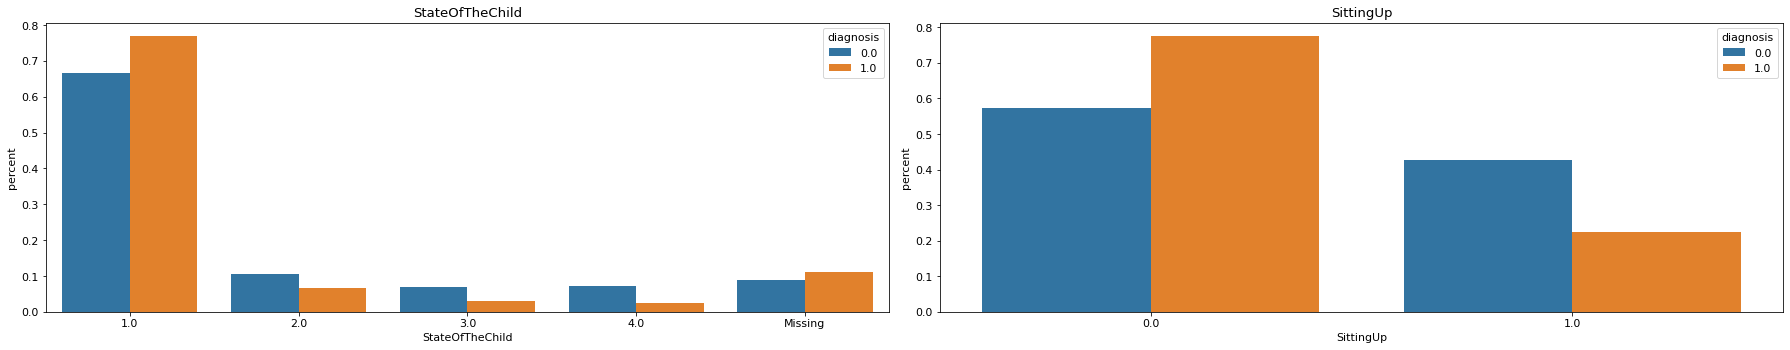

In [217]:

cols  = ['StateOfTheChild', 'SittingUp']
n_plot = 2

fig, axes = plt.subplots(1, 2, figsize=(25, 5)); axes=axes.flatten()

for i, col in enumerate(cols):
    
    df = data.df.copy()
    
    df = df[(df['diagnosis'].isin([0, 1])) & (df['validity_available']==1)]
    
    df[col].replace({np.nan:'Missing'}, inplace=True)
    
    pct3 = (df.groupby(['diagnosis', col]).size()/ df.groupby(['diagnosis']).size()).reset_index().rename({0:'percent'}, axis=1)
    display( df.groupby(['diagnosis', col]).size().reset_index().rename({0:'Count'}, axis=1))
    
    
    sns.barplot(x=col, hue='diagnosis', y='percent', data=pct3, ax=axes[i])


    axes[i].set_title(col)
    
plt.tight_layout()

# Prediction of the missing variables

In [49]:
for i, feats in grouped_features.items():
    data.df['Z_grouped_{}'.format(i)] = 0
    data.df.loc[data.df.drop(index=data.df.dropna(subset=feats, how='all').index).index, 'Z_grouped_{}'.format(i)] = 1

dict_check_1_0 = {9:[8],
                 10:[8, 9]}

touch_features =  ['number_of_touches','average_length','std_length','average_error','std_error','number_of_target','pop_rate',
 'average_touch_duration','std_touch_duration','average_delay_to_pop','std_delay_to_pop','average_force_applied','std_force_applied',
 'average_accuracy_variation','accuracy_consistency','average_touches_per_target', 'std_touches_per_target','average_time_spent','std_time_spent','exploratory_percentage']

In [254]:
grouped_features

{1: ['BB_gaze_percent_right',
  'BB_gaze_silhouette_score',
  'BB_postural_sway',
  'BB_postural_sway_derivative',
  'RT_postural_sway',
  'RT_postural_sway_derivative'],
 2: ['MML_postural_sway', 'MML_postural_sway_derivative'],
 3: ['DIGRRL_postural_sway', 'DIGRRL_postural_sway_derivative'],
 4: ['FP_gaze_speech_correlation',
  'FP_gaze_silhouette_score',
  'FP_postural_sway',
  'FP_postural_sway_derivative'],
 5: ['PB_postural_sway', 'PB_postural_sway_derivative'],
 6: ['PWB_postural_sway', 'PWB_postural_sway_derivative'],
 7: ['number_of_touches', 'number_of_target', 'exploratory_percentage'],
 8: ['average_length',
  'std_length',
  'average_error',
  'std_error',
  'pop_rate',
  'average_touch_duration',
  'std_touch_duration',
  'average_delay_to_pop',
  'std_delay_to_pop',
  'average_force_applied',
  'std_force_applied',
  'average_accuracy_variation',
  'accuracy_consistency',
  'average_touches_per_target',
  'std_touches_per_target'],
 9: ['average_time_spent', 'std_time_sp

RhymesAndToys/BlowingBubbles missing


AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)
0    1.0   0.996          1.0             0.983                    1.0                           0.986               0.955     0.996                                   0.981                                              0.981                                                       0.998                                            0.986                            0.998                                   0.019                             0.014                            0.002

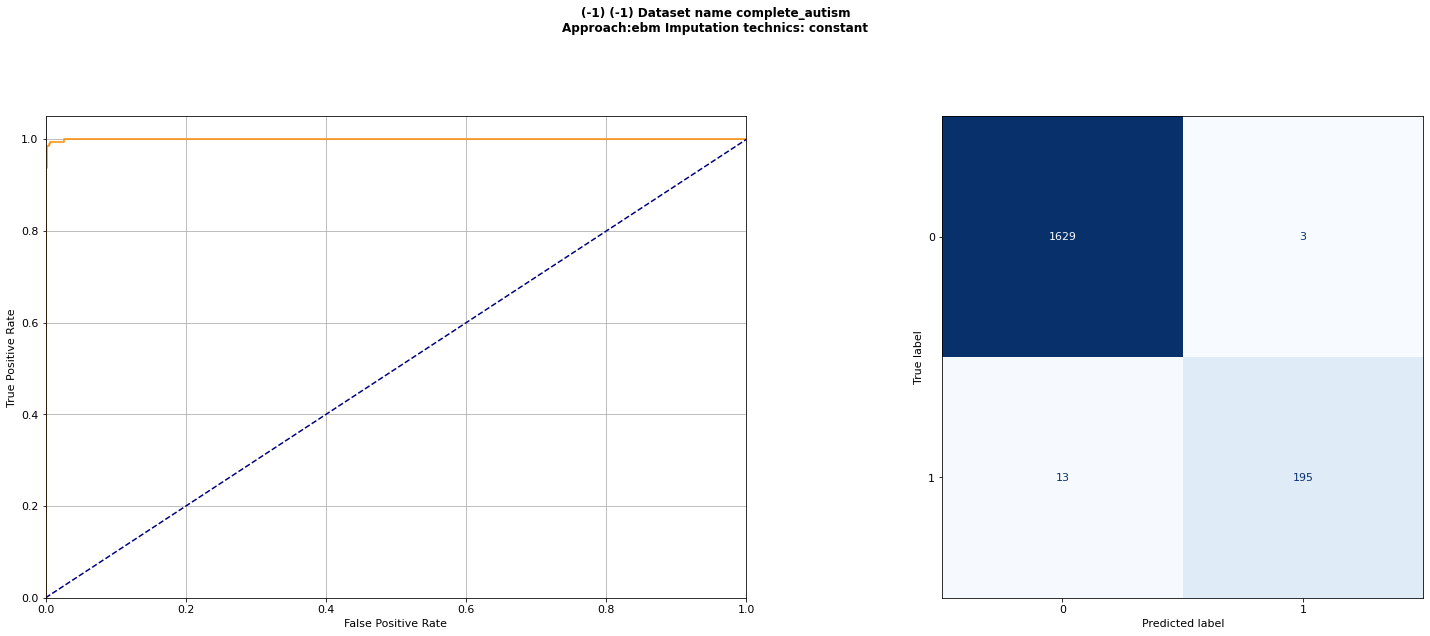

<!-- http://127.0.0.1:7491/140320285855696/ -->

<!-- http://127.0.0.1:7491/140320300229392/ -->

MakeMeLaugh missing


AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)
0  0.999   0.994          1.0             0.977                    1.0                           0.972                0.95     0.991                                   0.965                                              0.952                                                       0.998                                            0.988                            0.992                                   0.048                             0.012                            0.008

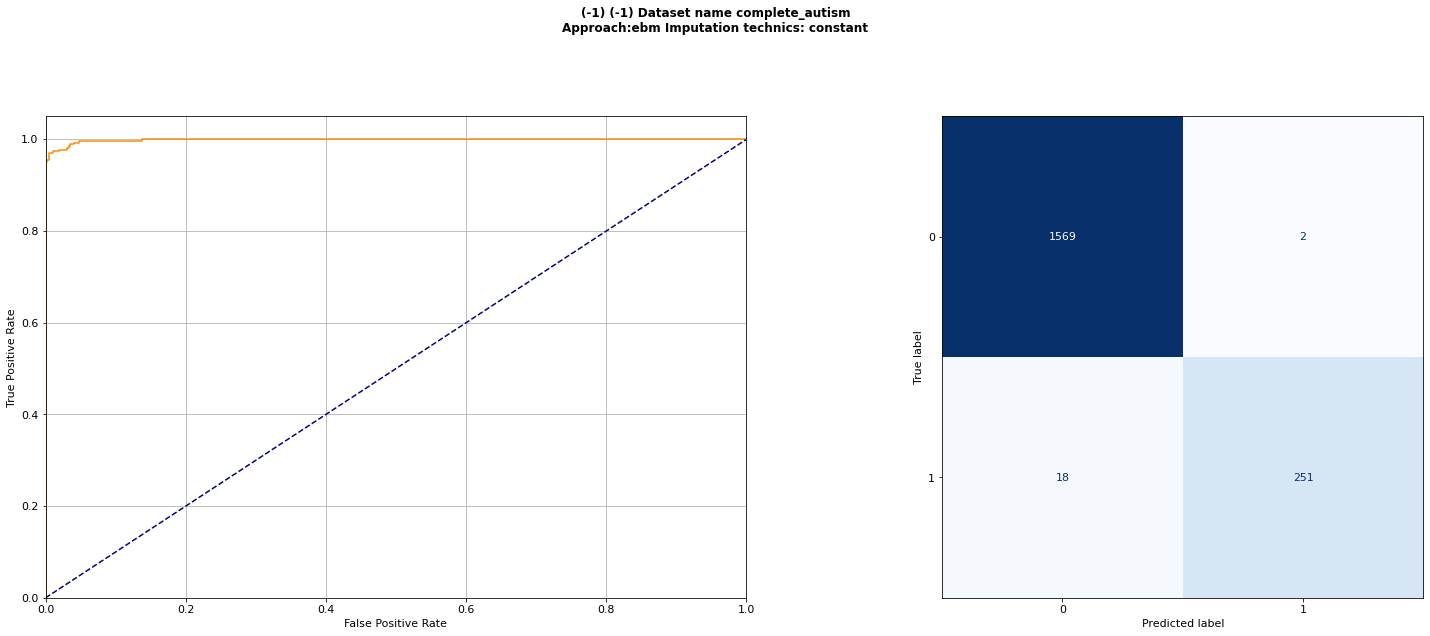

<!-- http://127.0.0.1:7491/140318354526928/ -->

<!-- http://127.0.0.1:7491/140320313597136/ -->

DIGRRL missing


AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)
0  0.999   0.994          1.0             0.977                    1.0                           0.957               0.951     0.989                                   0.949                                              0.977                                                       0.991                                            0.933                            0.997                                   0.023                             0.067                            0.003

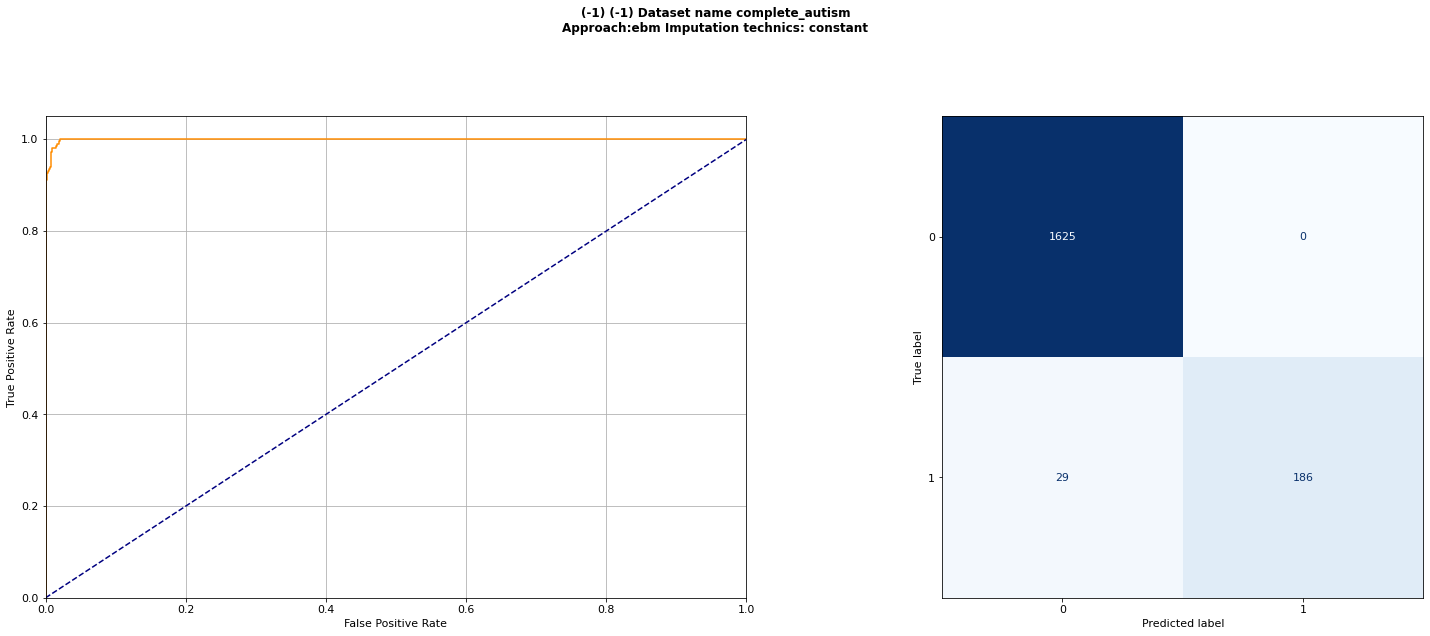

<!-- http://127.0.0.1:7491/140318640022608/ -->

<!-- http://127.0.0.1:7491/140318368139216/ -->

FunAtThePark missing


KeyboardInterrupt: 

In [241]:
from interpret import show

for idx_grouped_missing_features, missing_feats in grouped_features.items():
    if idx_grouped_missing_features==0:
        continue

    df = pd.read_csv("/Users/samperochon/Duke/work/notes_on_stats/df_all.csv")

    df['stimuli_version'] = df['path'].apply(lambda path: path.split('/')[-2])
    df.loc[~df['stimuli_version'].isin(['Older_Than_18', '12_Months', '9_Months', '6_Months']), 'stimuli_version'] = 'Older_Than_18'


    for i, feats in grouped_features.items():
        df['Z_grouped_{}'.format(i)] = 0
        df.loc[df.drop(index=df.dropna(subset=missing_feats, how='all').index).index, 'Z_grouped_{}'.format(i)] = 1
    del i 
    
    features_name = [feat for feat in CVA_COLUMNS + CLINICAL_COLUMNS + VALIDITY_COLUMNS (((idx_grouped_missing_features not in [8, 9, 10]) and (feat not in missing_feats)) or
                                                                                        ((idx_grouped_missing_features in [8, 9, 10]) and (feat not in touch_features)) or
                                                                                        (feat not in ['completed']))]
    data = Dataset(df=df, 
                       use_missing_indicator_variables=False,
                       missing_data_handling='encoding', 
                       imputation_method='without', 
                       sampling_method='without',
                       outcome_column='Z_grouped_{}'.format(idx_grouped_missing_features),
                       features_name=features_name, 
                       scenario=None,
                       verbosity=0, 
                       proportion_train=1)
    
    exp = Experiments(data.dataset_name,
              dataset=data, 
            approach='ebm', 
            resolution=RESOLUTION, 
            bandwidth=BANDWIDTH, 
            previous_experiment=None,        
            verbosity=1, 
            debug=True, 
            save_experiment=False)
        
    exp.dataset.filter(administration={'complete': True})
    
    print(grouped_features_label[idx_grouped_missing_features])
        
    # Removing the administration without the game by design (6, 9 nd 12 months versions), or playing with blocks
    if idx_grouped_missing_features in [6, 7, 8, 9]:
        exp.dataset.df = exp.dataset.df[exp.dataset.df['stimuli_version']=='Older_Than_18']

    # removing the 18 Mo version for the Peakaboo features 
    elif idx_grouped_missing_features == 5:
        exp.dataset.df = exp.dataset.df[exp.dataset.df['stimuli_version']!='Older_Than_18']
                
        
    if idx_grouped_missing_features in dict_check_1_0.keys():
        for idx_group_that_should_be_there in dict_check_1_0[idx_grouped_missing_features]:
            exp.dataset.df = exp.dataset.df[exp.dataset.df['Z_grouped_{}'.format(idx_group_that_should_be_there)]==0]
    exp.fit_predict()
    exp.plot()

    ebm_local = exp.model.explain_local(data.X_train, data.y_train)
    show(ebm_local)

# Prediction of social attributes

In [267]:
df = pd.read_csv("/Users/samperochon/Duke/work/notes_on_stats/df_all.csv")

df['stimuli_version'] = df['path'].apply(lambda path: path.split('/')[-2])
df.loc[~df['stimuli_version'].isin(['Older_Than_18', '12_Months', '9_Months', '6_Months']), 'stimuli_version'] = 'Older_Than_18'
CLINICAL_COLUMNS

['diagnosis',
 'mullen_el',
 'mullen_fm',
 'mullen_rl',
 'mullen_vr',
 'mullen_elc_std',
 'ados_total',
 'ados_rrb',
 'ados_sa',
 'srs_total_tscore',
 'srs_social_awareness_tscore',
 'srs_social_motivation_tscore',
 'cbcl_scaleIV_score',
 'cbcl_asd_score',
 'mchat_total',
 'mchat_final',
 'mchat_result']

In [265]:


df = pd.read_csv("/Users/samperochon/Duke/work/notes_on_stats/df_all.csv")

df['stimuli_version'] = df['path'].apply(lambda path: path.split('/')[-2])
df.loc[~df['stimuli_version'].isin(['Older_Than_18', '12_Months', '9_Months', '6_Months']), 'stimuli_version'] = 'Older_Than_18'

data = Dataset(df=df, 
                   use_missing_indicator_variables=False,
                   missing_data_handling='encoding', 
                   imputation_method='without', 
                   sampling_method='without',
                   outcome_column='diagnosis',
                   features_name=DEFAULT_PREDICTORS, 
                   scenario=None,
                   scale_data=False, 
                   verbosity=4, 
                   proportion_train=1)
data.filter(administration={'complete': True, 
                            'order':'first'})


Post-processing inital df (removing columns with no cva features, encoding srings, compute administrations order, compute condensed S/NS variables)... 
Predicting diagnosis based on 29 features
Splitting dataset into test and train set.
Encoding 1956 (train) and 0 (test) missing values with -5.
Removing 116/1956 incomplete administrations.
Removing 581/1840 keeping first admin.
1259 administrations left.


id
diagnosis     
-1.0        90
 0.0       792
 1.0       290
 2.0        27
 3.0        49
 4.0        11

Splitting dataset into test and train set.
Encoding 1259 (train) and 0 (test) missing values with -5.


<AxesSubplot:>

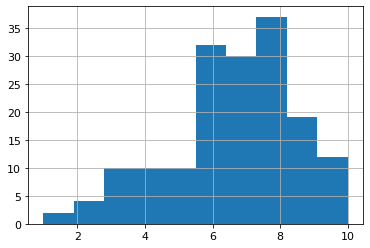

In [274]:
data.df[~data.df['ados_sa'].isna()]['ados_sa'].hist()

In [222]:



df = pd.read_csv("/Users/samperochon/Duke/work/notes_on_stats/df_all.csv")

df['stimuli_version'] = df['path'].apply(lambda path: path.split('/')[-2])
df.loc[~df['stimuli_version'].isin(['Older_Than_18', '12_Months', '9_Months', '6_Months']), 'stimuli_version'] = 'Older_Than_18'


for i, feats in grouped_features.items():
    df['Z_grouped_{}'.format(i)] = 0
    df.loc[df.drop(index=df.dropna(subset=missing_feats, how='all').index).index, 'Z_grouped_{}'.format(i)] = 1
del i 

features_name = [feat for feat in CVA_COLUMNS + CLINICAL_COLUMNS + VALIDITY_COLUMNS if (((idx_grouped_missing_features not in [8, 9, 10]) and (feat not in missing_feats)) or
                                                                                        ((idx_grouped_missing_features in [8, 9, 10]) and (feat not in touch_features)))]
data = Dataset(df=df, 
                   use_missing_indicator_variables=False,
                   missing_data_handling='encoding', 
                   imputation_method='without', 
                   sampling_method='without',
                   outcome_column='Z_grouped_{}'.format(idx_grouped_missing_features),
                   features_name=features_name, 
                   scenario=None,
                   scale_data=False, 
                   verbosity=0, 
                   proportion_train=1)

exp = Experiments(data.dataset_name,
          dataset=data, 
        approach='ebm', 
        resolution=RESOLUTION, 
        bandwidth=BANDWIDTH, 
        previous_experiment=None,        
        verbosity=1, 
        debug=True, 
        save_experiment=False)

exp.dataset.filter(administration={'complete': True})

print(grouped_features_label[idx_grouped_missing_features])

# Removing the administration without the game by design (6, 9 nd 12 months versions), or playing with blocks
if idx_grouped_missing_features in [6, 7, 8, 9]:
    exp.dataset.df = exp.dataset.df[exp.dataset.df['stimuli_version']=='Older_Than_18']

# removing the 18 Mo version for the Peakaboo features 
elif idx_grouped_missing_features == 5:
    exp.dataset.df = exp.dataset.df[exp.dataset.df['stimuli_version']!='Older_Than_18']


if idx_grouped_missing_features in dict_check_1_0.keys():
    for idx_group_that_should_be_there in dict_check_1_0[idx_grouped_missing_features]:
        exp.dataset.df = exp.dataset.df[exp.dataset.df['Z_grouped_{}'.format(idx_group_that_should_be_there)]==0]
exp.fit_predict()
exp.plot()

ebm_local = exp.model.explain_local(data.X_train, data.y_train)
show(ebm_local)

['BB_gaze_percent_right',
 'BB_gaze_silhouette_score',
 'S_gaze_percent_right',
 'S_gaze_silhouette_score',
 'FP_gaze_speech_correlation',
 'FP_gaze_silhouette_score',
 'proportion_of_name_call_responses',
 'average_response_to_name_delay',
 'name_call_response_binary',
 'FB_postural_sway',
 'FB_postural_sway_derivative',
 'DIGC_postural_sway',
 'DIGC_postural_sway_derivative',
 'DIGRRL_postural_sway',
 'DIGRRL_postural_sway_derivative',
 'ST_postural_sway',
 'ST_postural_sway_derivative',
 'MP_postural_sway',
 'MP_postural_sway_derivative',
 'PB_postural_sway',
 'PB_postural_sway_derivative',
 'BB_postural_sway',
 'BB_postural_sway_derivative',
 'RT_postural_sway',
 'RT_postural_sway_derivative',
 'MML_postural_sway',
 'MML_postural_sway_derivative',
 'PWB_postural_sway',
 'PWB_postural_sway_derivative',
 'FP_postural_sway',
 'FP_postural_sway_derivative',
 'number_of_touches',
 'average_length',
 'std_length',
 'average_error',
 'std_error',
 'number_of_target',
 'pop_rate',
 'averag

FunAtThePark missing 1840 85


AUROC  AUC-PR  AUC-PR-Gain  AUC-PR-Corrected  AUC-PR-Gain-Corrected  F1 score (2 PPVxTPR/(PPV+TPR))  F1 score Corrected  Accuracy  Matthews correlation coefficient (MCC)  Sensitivity, recall, hit rate, or true positive rate (TPR)  Specificity, selectivity or true negative rate (TNR)  Precision or positive predictive value (PPV)  Negative predictive value (NPV)  Miss rate or false negative rate (FNR)  False discovery rate (FDR=1-PPV)  False omission rate (FOR=1-NPV)
0    1.0     1.0          1.0               1.0                    1.0                             1.0                 1.0     0.999                                   0.998                                              0.997                                                         1.0                                              1.0                            0.999                                   0.003                               0.0                            0.001

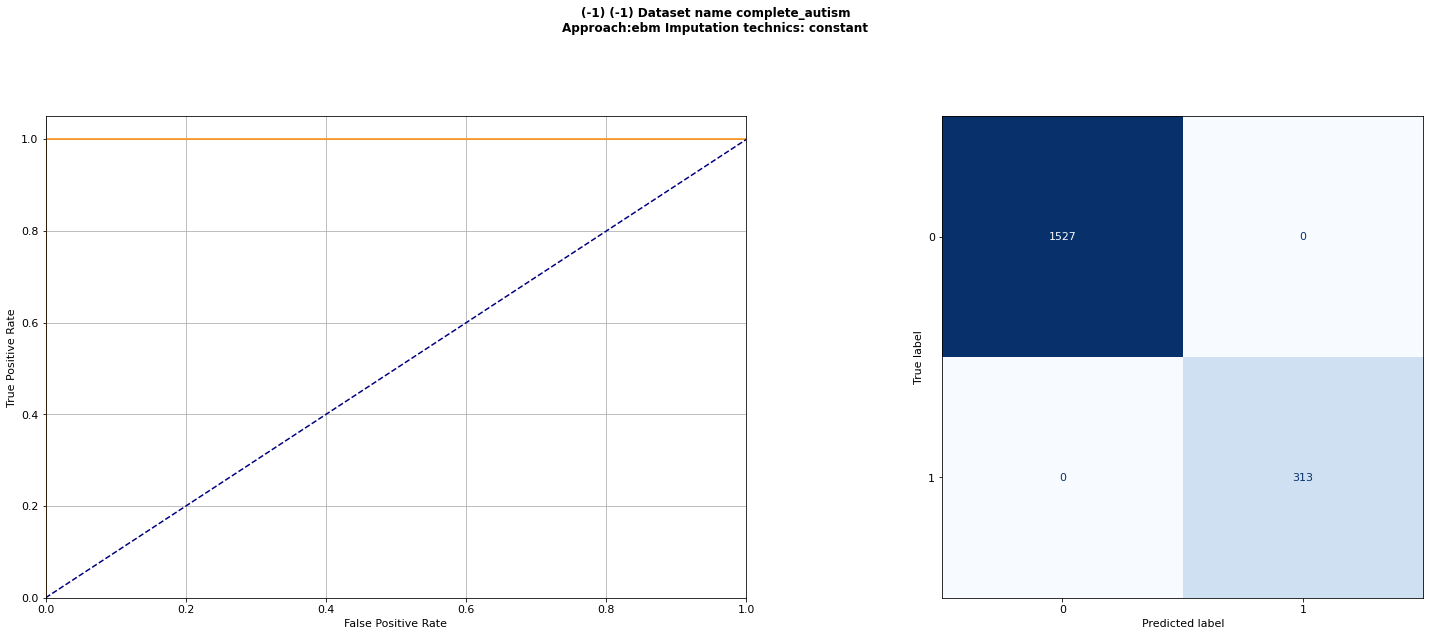

<!-- http://127.0.0.1:7491/140318922579216/ -->

<!-- http://127.0.0.1:7491/140320300481744/ -->

In [275]:
idx_grouped_missing_features = 4
missing_feats = ['FP_gaze_speech_correlation',
  'FP_gaze_silhouette_score',
  'FP_postural_sway',
  'FP_postural_sway_derivative']

#df = pd.read_csv("/home01/sam/df_all.csv")
df = pd.read_csv("/Users/samperochon/Duke/work/notes_on_stats/df_all.csv")

for i, feats in grouped_features.items():
    df['Z_grouped_{}'.format(i)] = 0
    df.loc[df.drop(index=df.dropna(subset=missing_feats, how='all').index).index, 'Z_grouped_{}'.format(i)] = 1
del i 


d = df.copy()

if idx_grouped_missing_features in dict_check_1_0.keys():
    for idx_group_that_should_be_there in dict_check_1_0[idx_grouped_missing_features]:
        d = d[d['Z_grouped_{}'.format(idx_group_that_should_be_there)]==0]


features_name = [feat for feat in CVA_COLUMNS + CLINICAL_COLUMNS + VALIDITY_COLUMNS if (((idx_grouped_missing_features not in [8, 9, 10]) and (feat not in missing_feats)) or
                                                                                        ((idx_grouped_missing_features in [8, 9, 10]) and (feat not in touch_features)) or
                                                                                        (feat not in ['completed']))]

data = Dataset(df=d, 
               use_missing_indicator_variables=False,
               missing_data_handling='encoding', 
               imputation_method='without', 
               sampling_method='without',
               outcome_column='Z_grouped_{}'.format(idx_grouped_missing_features),
               features_name=features_name,
               scenario=None,#'asd_td_age_matched_n_balanced',
               verbosity=0, 
               proportion_train=1)
data.filter(administration={'complete': True})

print(grouped_features_label[idx_grouped_missing_features], len(data.df), data.X_train.shape[1])

exp = Experiments(data.dataset_name,
              dataset=data, 
            approach='ebm', 
            resolution=RESOLUTION, 
            bandwidth=BANDWIDTH, 
            previous_experiment=None,        
            verbosity=1, 
            debug=True, 
            save_experiment=False)

exp.fit_predict()
exp.plot()


ebm_local = exp.model.explain_local(data.X_train, data.y_train)
show(ebm_local)

In [275]:
df = pd.read_csv("/Users/samperochon/Duke/work/notes_on_stats/df_all.csv")
data = Dataset(df=df, 
               use_missing_indicator_variables=False,
               missing_data_handling='encoding', 
               imputation_method='without', 
               sampling_method='without',
               outcome_column='diagnosis',#'Z_grouped_{}'.format(idx_grouped_missing_features),
               features_name=features_name,
               scenario=None,#'asd_td_age_matched_n_balanced',
               verbosity=0, 
               proportion_train=1)
data.filter(administration={'complete': True})

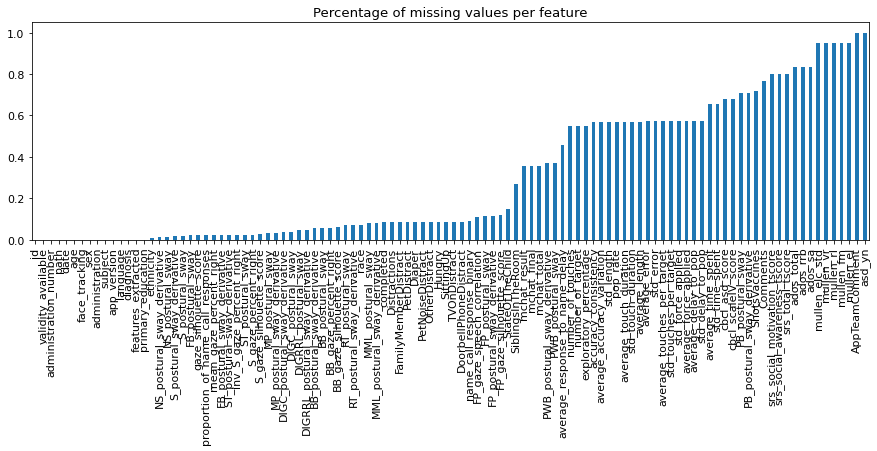

In [276]:
data.df.isna().mean().sort_values().plot(
    kind="bar", figsize=(15, 4),
    title="Percentage of missing values per feature");

# Building calibratedprobabilities

In [ ]:
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
# generate dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
	n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=4)
# define model
model = SVC(gamma='scale', class_weight='balanced')
# wrap the model
calibrated = CalibratedClassifierCV(model, method='isotonic', cv=3)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(calibrated, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))

# Description

# Dataset Illustration

In [101]:
#df = pd.read_csv("/home01/sam/df_all.csv")
df = pd.read_csv("/Users/samperochon/Duke/work/notes_on_stats/df_all.csv")
# Data definition
data = Dataset(df=df, 
               missing_data_handling='encoding',
               imputation_method='without',
               sampling_method='without',
               scenario = None, 
               features_name = DEFAULT_PREDICTORS,
               scale_data=True, 
               use_missing_indicator_variables=False,
               verbosity=0, 
               proportion_train=1)

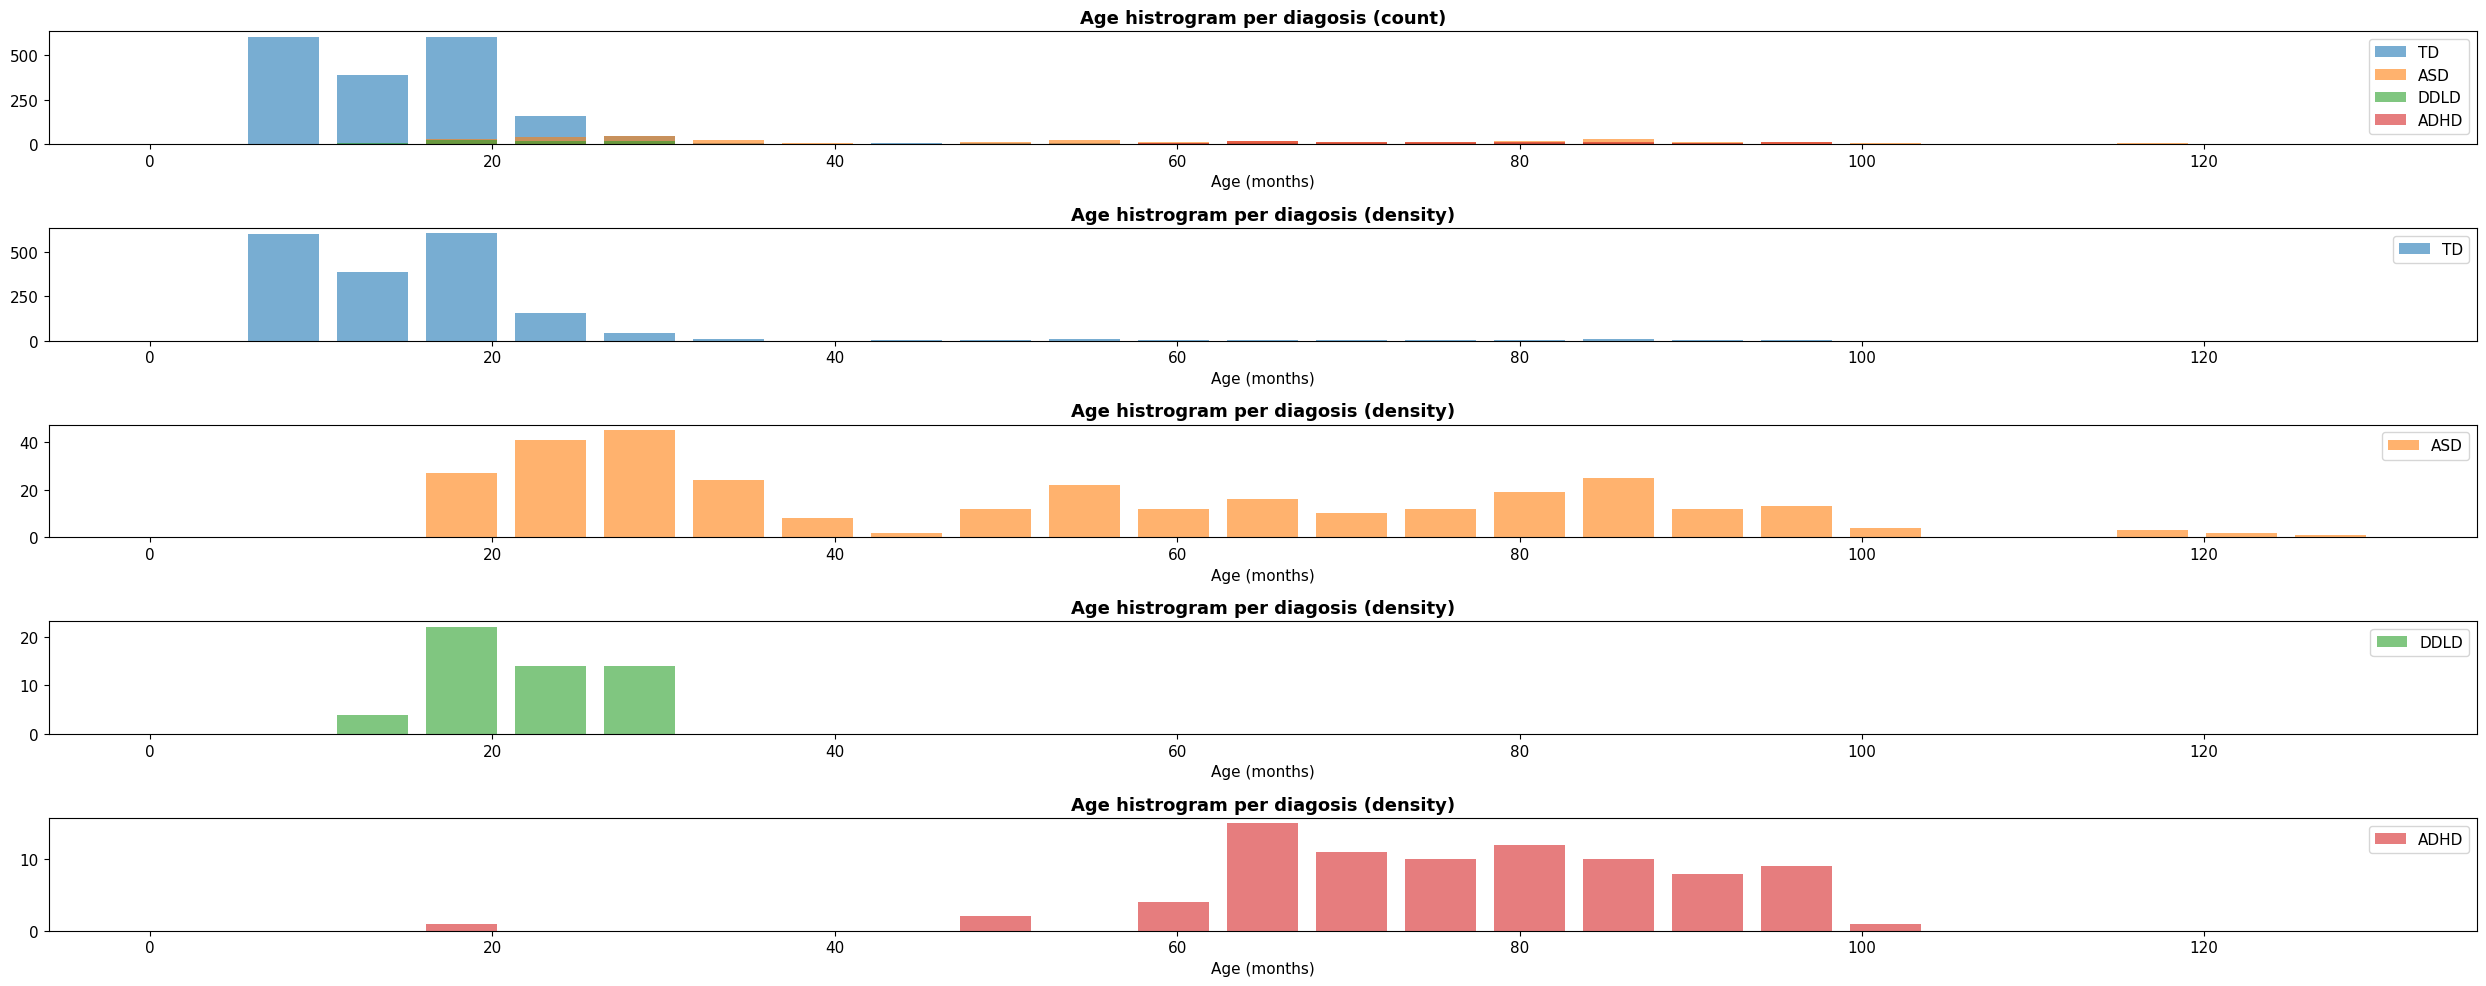

In [102]:
DIAG_DICT = {'TD':0., 
            'ASD':1., 
            'DDLD':2., 
            'ADHD':3.}
DIAG_DICT_REVERSE = {v: k for k, v in DIAG_DICT.items()}

colors = {'TD':'#1f77b4',
          'ASD': '#ff7f0e',
          'DDLD':'#2ca02c',
          'ADHD':'#d62728',
          'comorbid':'#9467bd'}
           
    
fig, axes = plt.subplots(5, 1, figsize=(25, 10)); axes=axes.flatten()

for i, d in df.groupby('diagnosis'):
    axes[0].hist(d['age'], bins=np.linspace(0, 130, 26), density=False, alpha=.6, rwidth=.8, color=colors[DIAG_DICT_REVERSE[i]], label=DIAG_DICT_REVERSE[i])
axes[0].legend(); axes[0].set_title("Age histrogram per diagosis (count)", weight='bold', fontsize=13); axes[0].set_xlabel("Age (months)")

for i, d in df.groupby('diagnosis'):
    axes[int(i+1)].hist(d['age'], bins=np.linspace(0, 130, 26), density=False, alpha=.6, rwidth=.8, color=colors[DIAG_DICT_REVERSE[i]], label=DIAG_DICT_REVERSE[i])
    axes[int(i+1)].legend(); axes[int(i+1)].set_title("Age histrogram per diagosis (density)", weight='bold', fontsize=13);axes[int(i+1)].set_xlabel("Age (months)")
plt.tight_layout()

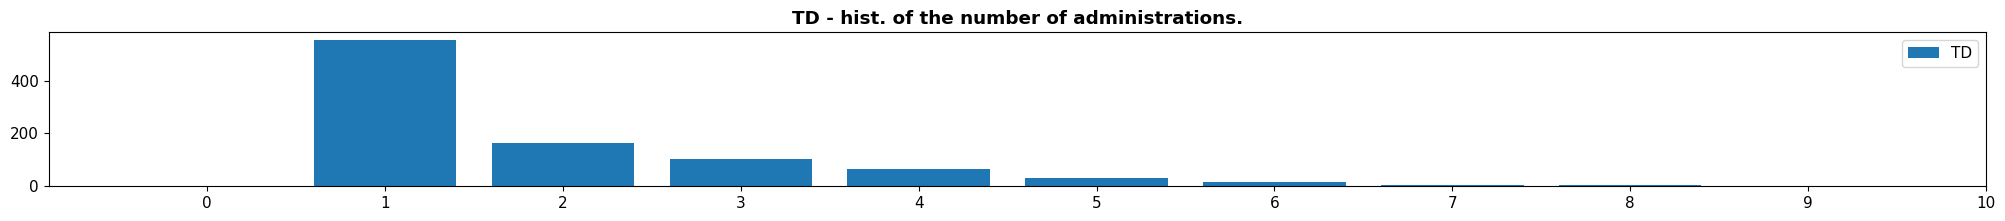

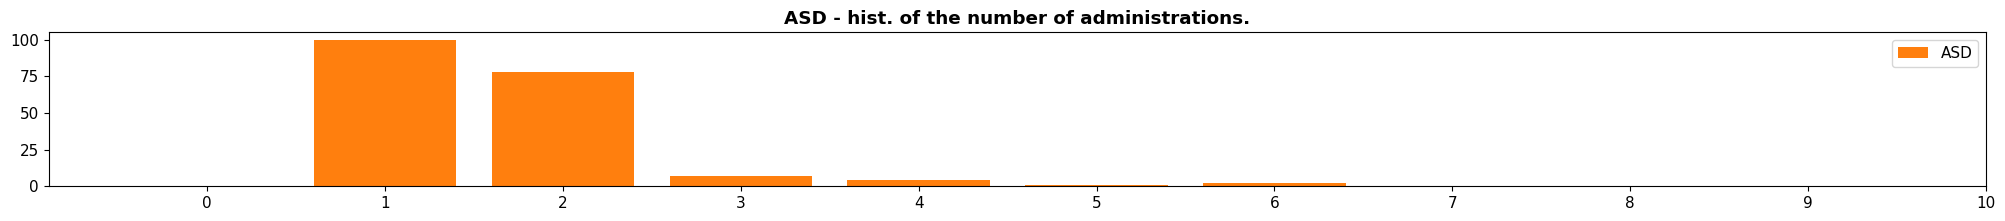

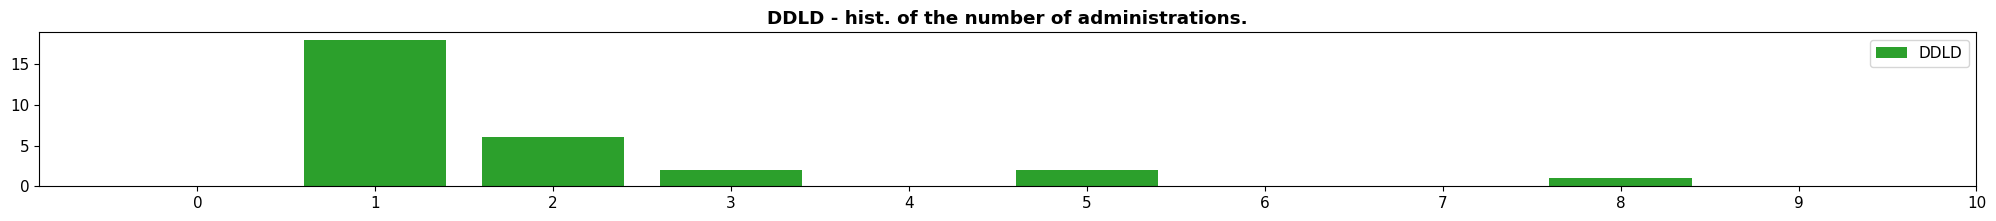

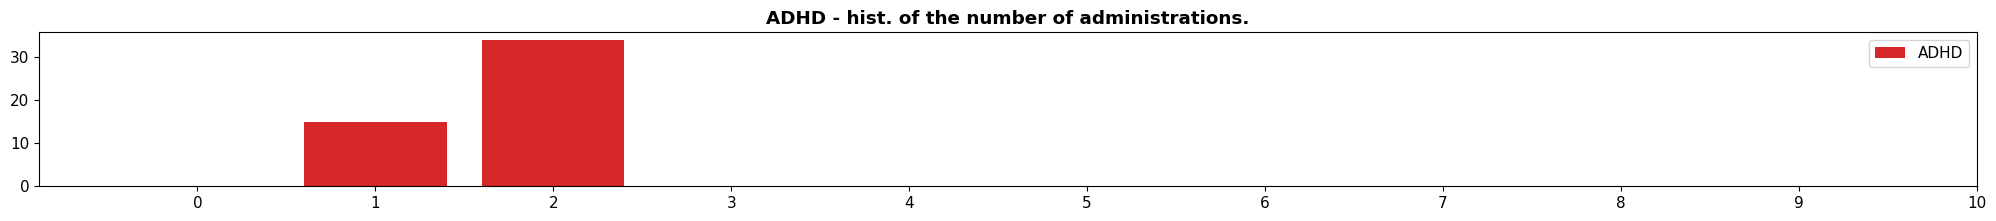

In [54]:
for i, d in df.groupby('diagnosis'):
    plt.figure(figsize=(25, 2)), 
    plt.hist(d.groupby("id")['diagnosis'].count().to_numpy(), bins = np.linspace(0, 10 , 11), rwidth=.8,color=colors[DIAG_DICT_REVERSE[i]], label=DIAG_DICT_REVERSE[i])
    plt.xticks(ticks=np.linspace(0, 10 , 11)+.5, labels=np.linspace(0, 10 , 11).astype(int));plt.legend()
    plt.title("{} - hist. of the number of administrations.".format(DIAG_DICT_REVERSE[i]), weight='bold')

In [20]:
def select(data,feature,value,unique=False):
    """Example : select(data,'ASD+',1,unique=True)
                 select(data,'sex','Male')
    """
    if unique:
        data_unique=data.drop_duplicates(subset = "id",keep='first')
        selected_data = data_unique[data_unique[feature]==value]
    else:
        selected_data = data[data[feature]==value]
    return(selected_data)

def my_fmt(x):
    return '{:.1f}%\n({:.0f})'.format(x, len(df)*x/100)

df_unique = deepcopy(df[df.duplicated(subset=['id'], keep='first')])

for col in ['diagnosis', 'sex']:
    n = df_unique.groupby(col).count().id.to_numpy()
    labels = df_unique.groupby(col).count().index

    plt.figure(figsize=(12, 8))
    plt.pie(n, labels=labels, autopct=my_fmt)
    plt.title(col)
    plt.show()

Predicting diagnosis based on 40 features

**********************************
 statistics:

**********************************
1220 subjects 
697  male
523  female
0  unknown sex beacause of missing clinical data 


**********************************
192 subjects in the ASD group
136 number of male
56 number of female 
 

**********************************
950 subjects in the TD group
502 number of male
448 number of female 


**********************************
29 subjects in the DL/DD group
21 number of male
8 number of female 


**********************************
49 subjects in the ADHD group
38 number of male
38 number of female 



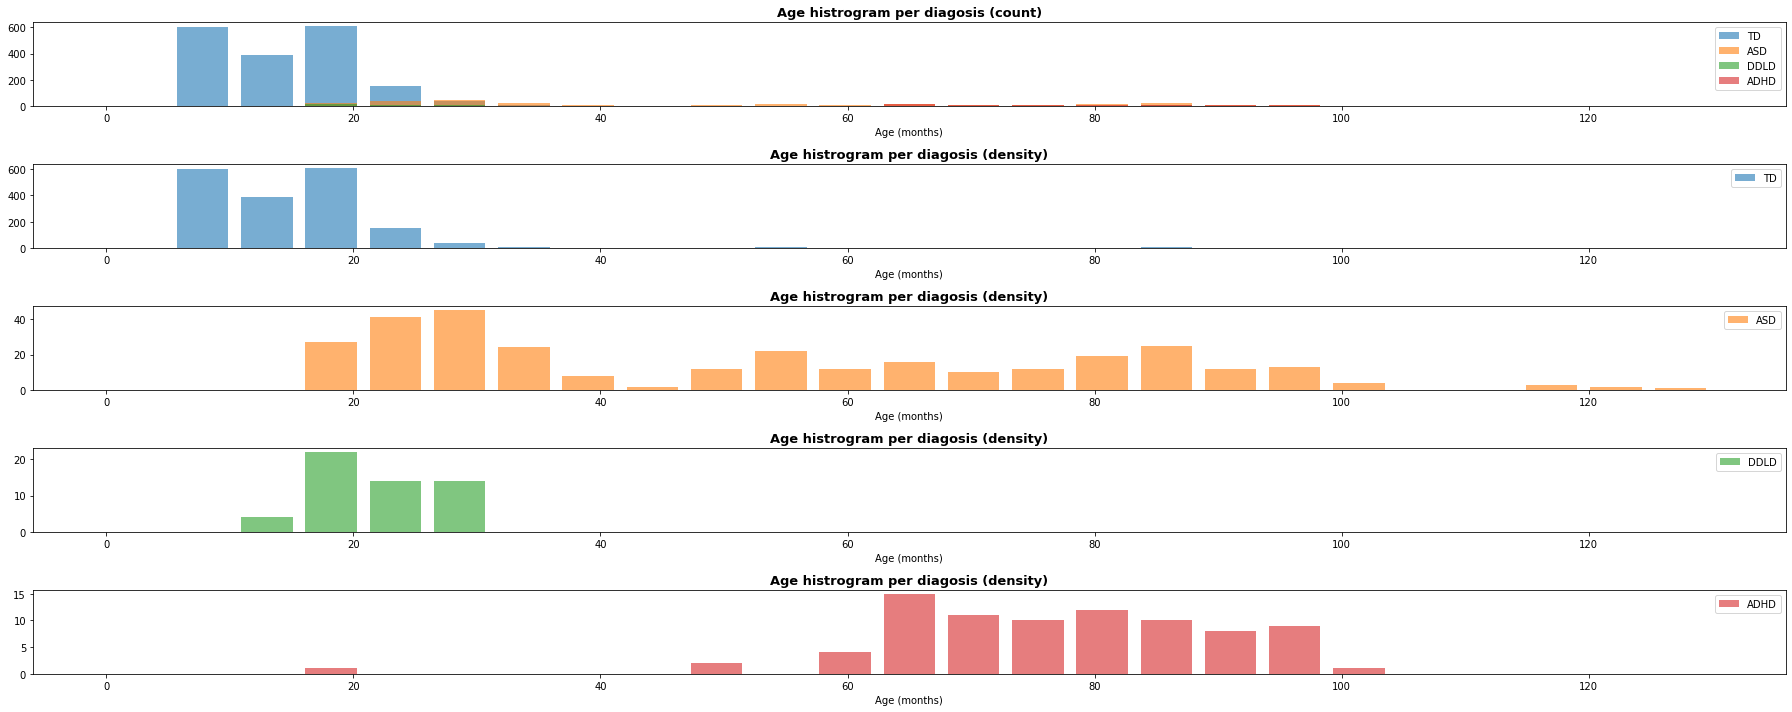

In [54]:
df = pd.read_csv("/home01/sam/df_all.csv")

data = Dataset(df=df, 
               missing_data_handling='encoding', 
               imputation_method='without', 
               proportion_train=1)

DIAG_DICT = {'TD':0., 
            'ASD':1., 
            'DDLD':2., 
            'ADHD':3.}
DIAG_DICT_REVERSE = {v: k for k, v in DIAG_DICT.items()}

colors = {'TD':'#1f77b4',
          'ASD': '#ff7f0e',
          'DDLD':'#2ca02c',
          'ADHD':'#d62728',
          'comorbid':'#9467bd'}
           
    
fig, axes = plt.subplots(5, 1, figsize=(25, 10)); axes=axes.flatten()

for i, d in df.groupby('diagnosis'):
    axes[0].hist(d['age'], bins=np.linspace(0, 130, 26), density=False, alpha=.6, rwidth=.8, color=colors[DIAG_DICT_REVERSE[i]], label=DIAG_DICT_REVERSE[i])
axes[0].legend(); axes[0].set_title("Age histrogram per diagosis (count)", weight='bold', fontsize=13); axes[0].set_xlabel("Age (months)")

for i, d in df.groupby('diagnosis'):
    axes[int(i+1)].hist(d['age'], bins=np.linspace(0, 130, 26), density=False, alpha=.6, rwidth=.8, color=colors[DIAG_DICT_REVERSE[i]], label=DIAG_DICT_REVERSE[i])
    axes[int(i+1)].legend(); axes[int(i+1)].set_title("Age histrogram per diagosis (density)", weight='bold', fontsize=13);axes[int(i+1)].set_xlabel("Age (months)")
plt.tight_layout()


"""
    Print population statistics at the beginning of the notebook.
"""
print('\n**********************************')
print(' statistics:')
print('\n**********************************')
data = df
# Masks
data_unique=data.drop_duplicates(subset = "id",keep='first')
data_unique_asd = select(data,'diagnosis',1,True)
data_unique_nasd = select(data,'diagnosis',0,True)
data_male = select(data,'sex',0)
data_female = select(data,'sex',1)
data_asd = select(data,'diagnosis',1)
data_nasd = select(data,'diagnosis',0)


#Count the number of subjects
subjects_id = np.unique(data['id'])
number_of_subjects = len(subjects_id)

subject_male = np.sum(data_unique['sex']==0)
subject_female = np.sum(data_unique['sex']==1)
subject_unknown = np.sum(pd.isna(data_unique['sex']))

print('{} subjects '.format(number_of_subjects))
print('{}  male'.format(subject_male))
print('{}  female'.format(subject_female)) 
print('{}  unknown sex beacause of missing clinical data \n'.format(subject_unknown)) 

# mchat_total_1_positive=data_unique.loc[data_unique['clinical_mchat_total_score']>=3]
# mchat_final_1_positive = mchat_total_1_positive.loc[mchat_total_1_positive['clinical_final_mchat_score']>=2]    
# mchat_total_2_positive=data_unique.loc[data_unique['clinical_mchat_total_score2']>=3]
# mchat_final_2_positive = mchat_total_1_positive.loc[mchat_total_1_positive['clinical_final_mchat_score2']>=2]    

# print('\n**********************************')
# print('{} subjects are "mchat positive" (First Adminisstration) '.format(len(mchat_final_1_positive)))
# print('{} subjects are "mchat positive" (Second Adminisstration) '.format(len(mchat_final_2_positive)))


nasd_subjects_id = data_unique_nasd[['id','sex']]
nasd_subject_male = np.sum(data_unique_nasd['sex']==0)
nasd_subject_female = np.sum(data_unique_nasd['sex']==1)

asd_subjects_id = data_unique_asd[['id','sex']]
asd_subject_male = np.sum(data_unique_asd['sex']==0)
asd_subject_female = np.sum(data_unique_asd['sex']==1)

dd_subjects_id = select(data_unique,'diagnosis', 2)[['id','sex']]
dd_subject_male = np.sum(dd_subjects_id['sex']==0)
dd_subject_female = np.sum(dd_subjects_id['sex']==1)

adhd_subjects_id = select(data_unique,'diagnosis', 3)[['id','sex']]
adhd_subject_male = np.sum(adhd_subjects_id['sex']==0)
adhd_subject_female = np.sum(adhd_subjects_id['sex']==1)

print('\n**********************************')
print('{} subjects in the ASD group'.format(len(asd_subjects_id)))
print('{} number of male'.format(asd_subject_male))
print('{} number of female \n '.format(asd_subject_female)) 


print('\n**********************************')
print('{} subjects in the TD group'.format(len(nasd_subjects_id)))
print('{} number of male'.format(nasd_subject_male))
print('{} number of female \n'.format(nasd_subject_female)) 



print('\n**********************************')
print('{} subjects in the DL/DD group'.format(len(dd_subjects_id)))
print('{} number of male'.format(dd_subject_male))
print('{} number of female \n'.format(dd_subject_female)) 

print('\n**********************************')
print('{} subjects in the ADHD group'.format(len(adhd_subjects_id)))
print('{} number of male'.format(adhd_subject_male))
print('{} number of female \n'.format(adhd_subject_male)) 

In [6]:
import missingno as msno

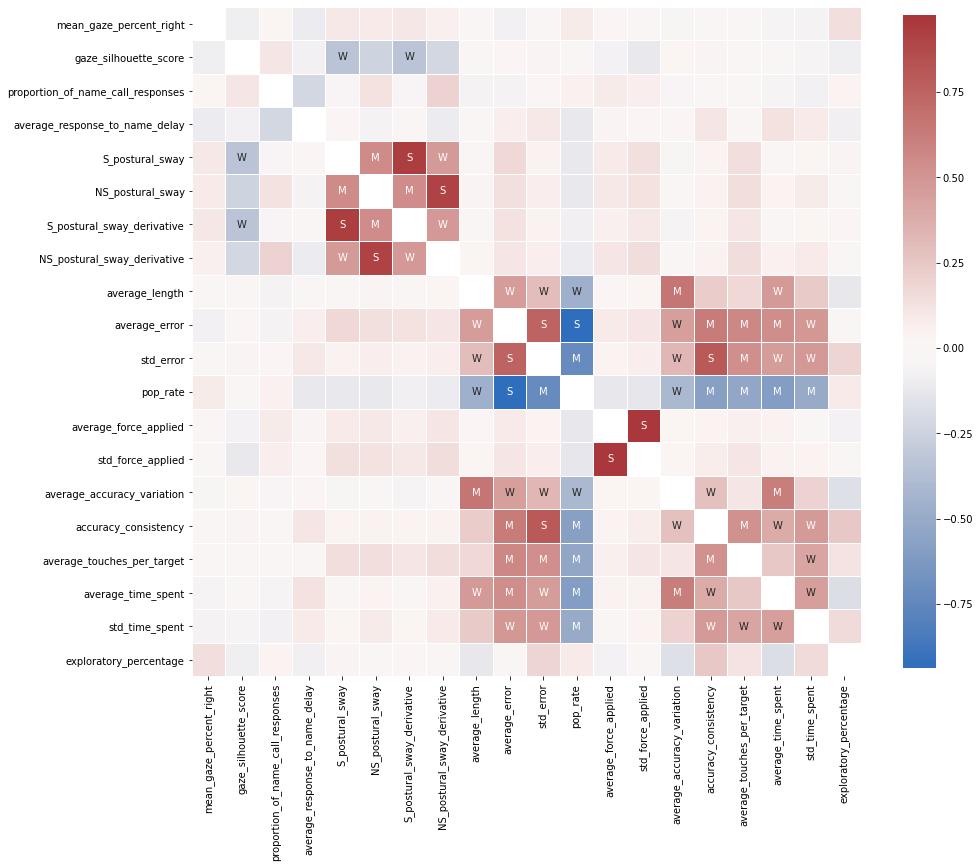

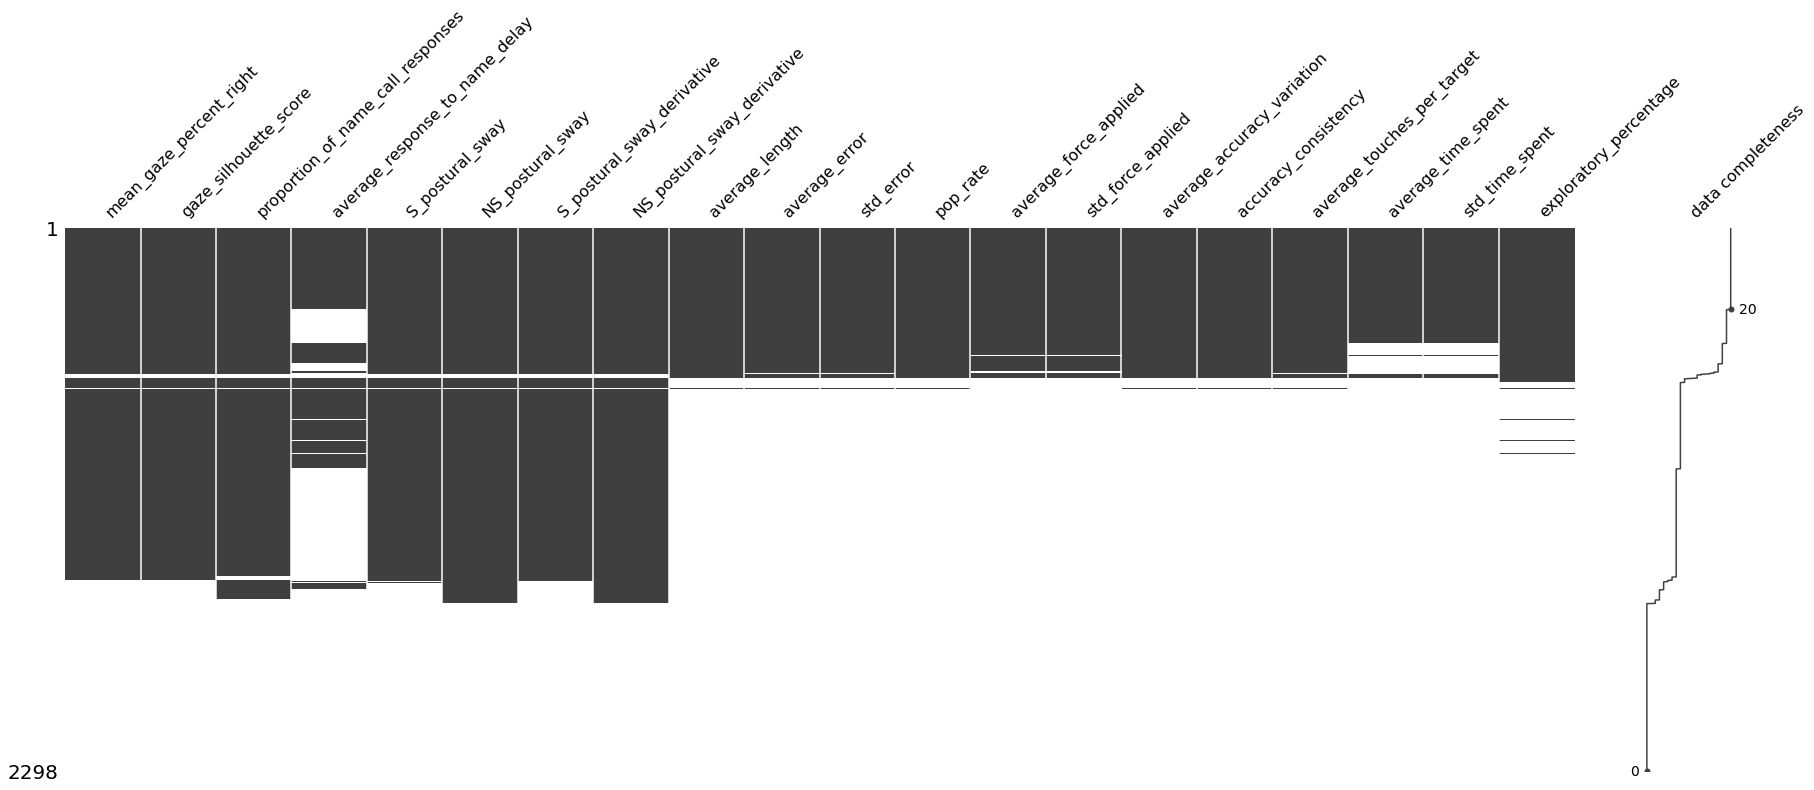

In [89]:
df_X = df[data.features_name[:int(len(data.features_name)//2)]]
# Computes feature correlation
df_corr = df_X.corr(method="pearson")

labels = np.where(np.abs(df_corr)>0.75, "S",
                  np.where(np.abs(df_corr)>0.5, "M",
                           np.where(np.abs(df_corr)>0.25, "W", "")))

# Plot correlation matrix
plt.figure(figsize=(15, 15))
sns.heatmap(df_corr, mask=np.eye(len(df_corr)), square=True,
            center=0, annot=labels, fmt='', linewidths=.5,
            cmap="vlag", cbar_kws={"shrink": 0.8});


msno.matrix(df_X, labels=True, sort="descending", figsize=(30, 10));

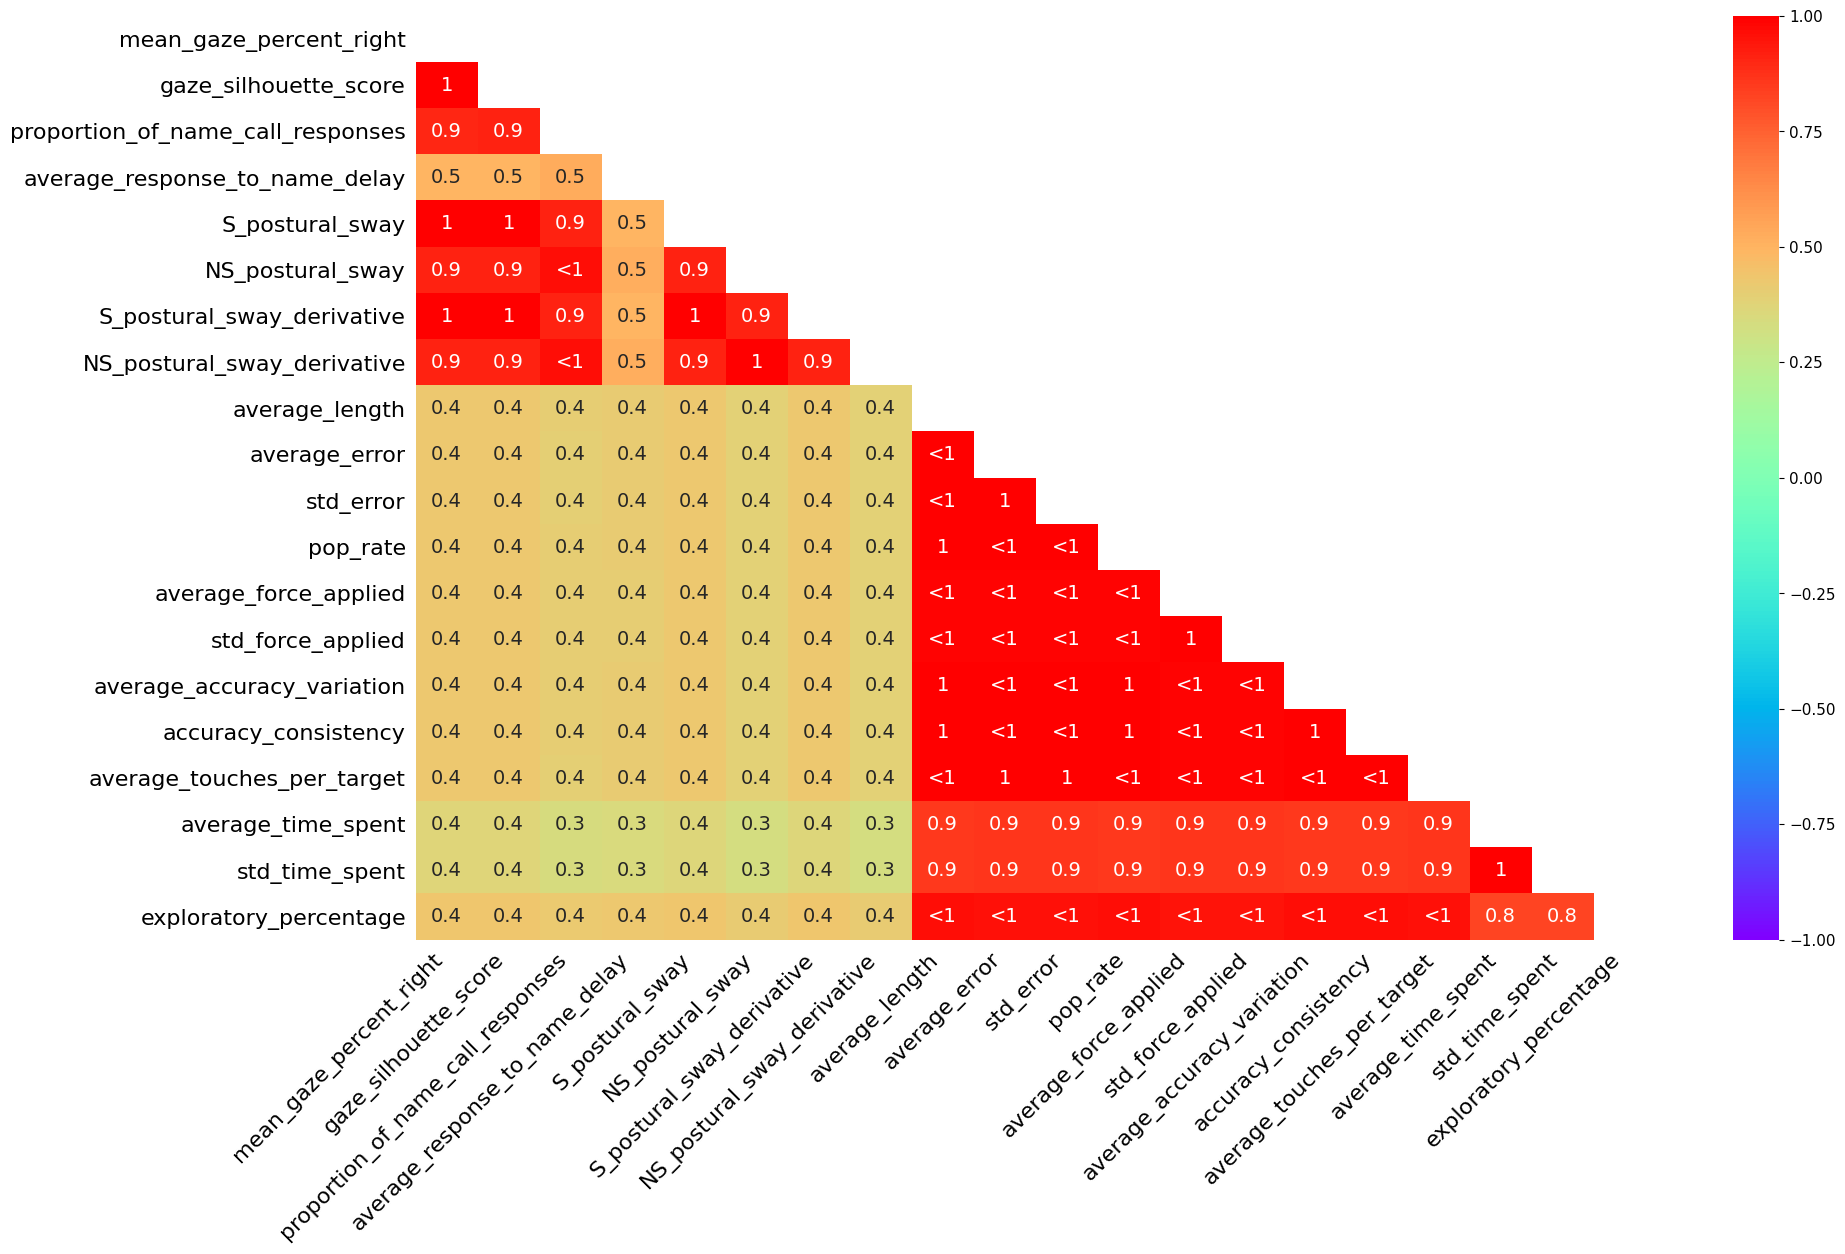

In [8]:
msno.heatmap(df_X, cmap='rainbow');


<AxesSubplot:>

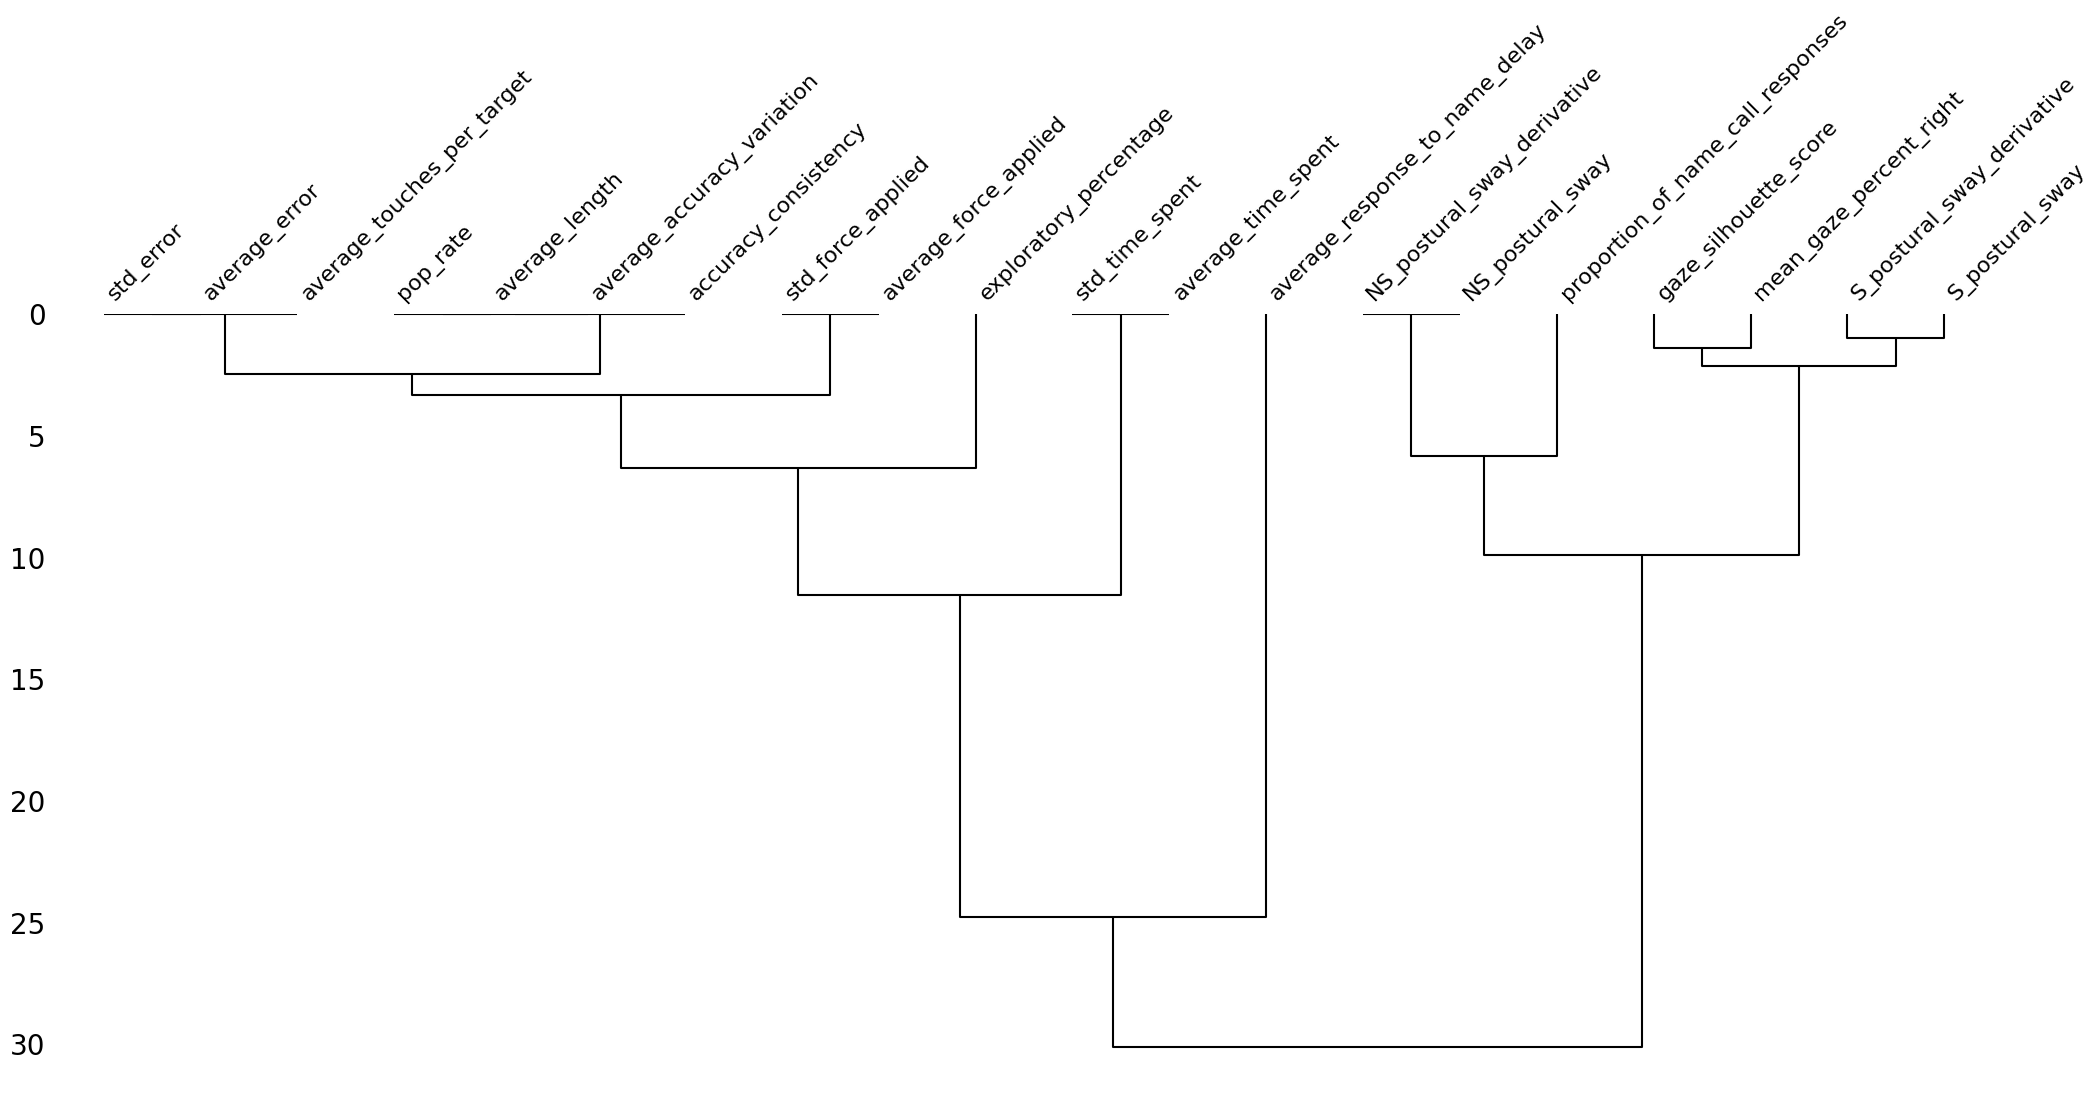

In [10]:
msno.dendrogram(df_X)

In [102]:
#  Creates a mask to remove the diagonal and the upper triangle.
lower_triangle_mask = np.tril(np.ones(df_corr.shape), k=-1).astype("bool")

#  Stack all correlations, after applying the mask
df_corr_stacked = df_corr.where(lower_triangle_mask).stack().sort_values()

#  Showing the lowest and highest correlations in the correlation matrix
display(df_corr_stacked)

pop_rate                     average_error           -0.936662
                             std_error               -0.723631
average_time_spent           pop_rate                -0.593849
accuracy_consistency         pop_rate                -0.582379
average_touches_per_target   pop_rate                -0.532550
                                                        ...   
std_error                    average_error            0.756120
accuracy_consistency         std_error                0.801857
NS_postural_sway_derivative  NS_postural_sway         0.912165
S_postural_sway_derivative   S_postural_sway          0.935392
std_force_applied            average_force_applied    0.973714
Length: 190, dtype: float64

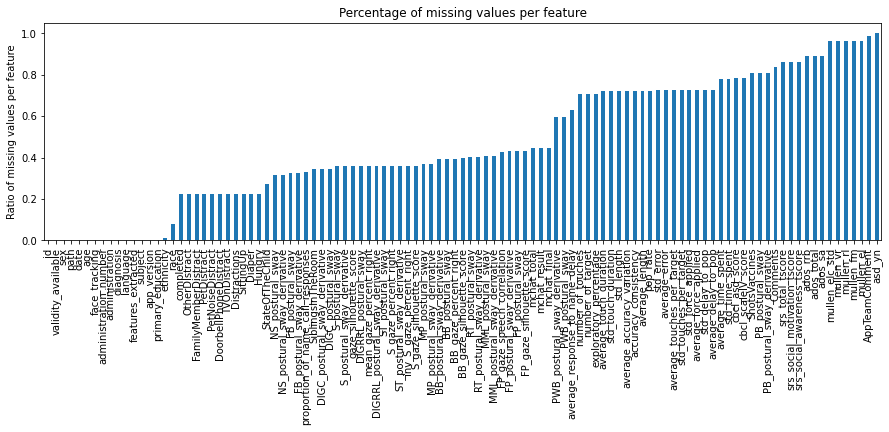

In [85]:
df.isna().mean().sort_values().plot(
    kind="bar", figsize=(15, 4),
    title="Percentage of missing values per feature",
    ylabel="Ratio of missing values per feature");

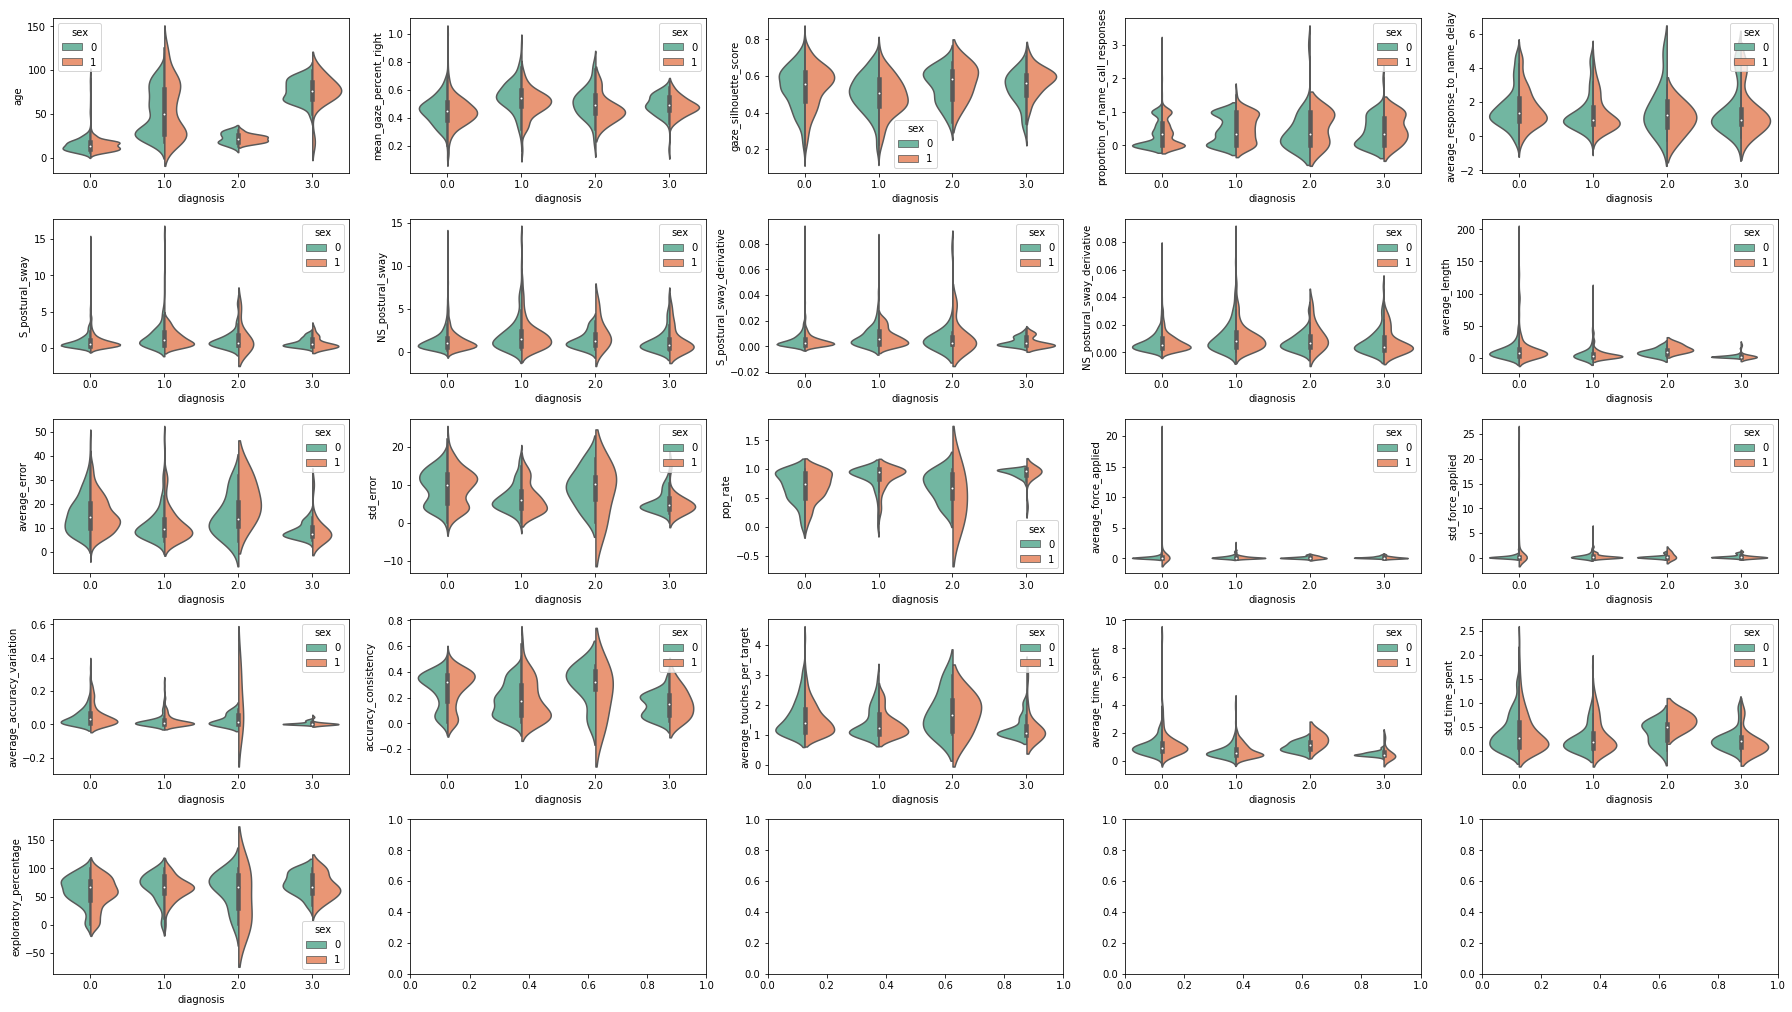

In [129]:
selected_features = ['age'] + data.features_name[:int(len(data.features_name)//2)]

# Create a figure with 3 x 2 subplots
fig, axes = plt.subplots(ncols=5, nrows=len(selected_features)//5 +1, figsize=(25, 14))
# Loop through these features and plot entries from each feature against `Latitude`
for col, ax in zip(selected_features, axes.ravel()):
    sns.violinplot(data=df, y=col, x='diagnosis', hue='sex', palette="Set2",
                   split=True, ax=ax)
plt.tight_layout()